In [ ]:
""" MNIST Exploration
Goal: Explore different architectures, initializations, activations, optimizers for much learning! 
Architectures:
X -> Softmax -> Argmax -> Y
X -> Hidden -> Relu/Sigmoid -> Softmax -> Argmax -> Y
X -> Hidden -> Relu/Sigmoid -> Hidden -> Relu/Sigmoid -> Softmax -> Argmax -> Y
X -> Hidden -> Relu -> Dropout -> Hidden -> Relu -> Dropout -> Softmax -> Argmax -> Y
"""

In [456]:
# load libraries
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import math


Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
training label shape:  (55000, 10)
training input shape:  (55000, 784)
test label shape:  (10000, 10)
test input shape:  (10000, 784)
number of training examples:  55000
number of classes:  10
number of input:  784


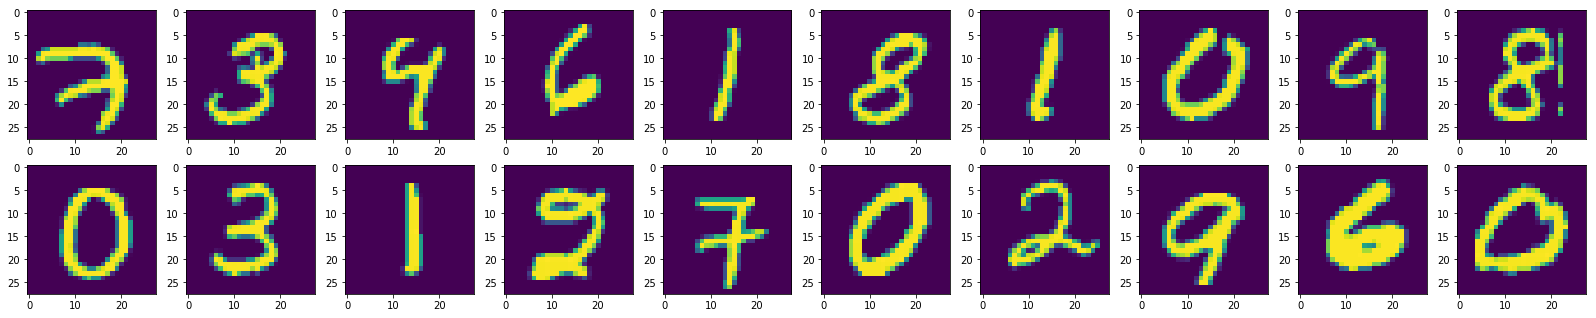

In [457]:
# import mnist dataset
mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=True)

n_train_examples = mnist.train.labels.shape[0]
n_test_examples = mnist.test.labels.shape[0]
n_Y = mnist.train.labels.shape[1]
n_X = mnist.train.images.shape[1]

# exploration around shapes and dimensions
print("training label shape: ", mnist.train.labels.shape)
print("training input shape: ", mnist.train.images.shape)
print("test label shape: ", mnist.test.labels.shape)
print("test input shape: ", mnist.test.images.shape)
print("number of training examples: ", n_train_examples)
print("number of classes: ", n_Y)
print("number of input: ", n_X)

image_width = 28
image_height = 28

def plot_images(images, w, h):
    """Plots array of image vectors into grid using matplotlib.
    
    Args:
        images: [n, 784] - array of flattened image vectors
        w: int - width of reshaped image
        h: int - height of reshaped image
    
    Returns:
        plot of images filled into 10 x 10 grids
    """
    reshaped_images = [ np.reshape(image, (w, h)) * 255 for image in images ]
    fig = plt.figure(figsize=(w, h))
    for i in range(len(reshaped_images)):
        fig.add_subplot(10,10,i + 1)
        plt.imshow(reshaped_images[i])
    plt.show()

def xavier_initializer(shape):
    """Initializes tensor with random values normalized by square root of 1/n_input, 
    should help keep control exploding/vanishing gradients for sigmoid activations
    http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
    
    Args:
        shape: [int,int] - size of input and output tensor
    
    Returns:
        returns tensor of size shape 
    """
    return tf.random_normal(shape) * math.sqrt(1.0/shape[0])

def relu_initializer(shape):
    """Initializes tensor with random values normalized by square root of 2/n_input, 
    should help keep control exploding/vanishing gradients for relu activation
    https://arxiv.org/pdf/1502.01852.pdf
    
    Args:
        shape: [int,int] - size of input and output tensor
    
    Returns:
        returns tensor of size shape
    """
    return tf.random_normal(shape) * math.sqrt(1.0/shape[0])

def pass_through_activation(z):
    """Pass through activation function, useful for output layer without activation
    
    Args:
        z: tensor - input tensor
    
    Returns:
        returns origin tensor
    """
    return z

def nn_layer(input, n_input, n_output, weight_initializer=tf.random_normal, bias_initializer=tf.random_normal, activation=pass_through_activation):
    """Creates dense nn layer
    
    Args:
        input: tensor - input tensor
        n_input: int - size of input tensor
        n_output: int - size of output tensor
        weight_initializer: function - weight initialization function
        bias_initializer: function - bias initialization function
        activation: function - activation function
    
    Returns:
        returns dictionary  {
            'W': weights tensor,
            'b': bias tensor,
            'z': z tensor,
            'output': post activation tensor
        }
    """
    W = tf.Variable(weight_initializer([n_input, n_output]))
    b = tf.Variable(bias_initializer([n_output]))
    z = tf.matmul(input,W) + b
    return {
        'W': W,
        'b': b,
        'z': z,
        'output': activation(z)
    }

def train(model, optimizer, epochs=10, batch_size=64, print_progress=True):
    """trains model using specified optimizer and returns as dictionary of results
    
    Args:
        model: tf graph - tf graph to train
        optimizer: tf optimizer - optimizer to use during training
        epochs: int - number of training epochs to perform
        batch_size: int - batch_size to use during training
        print_progress: boolean - flag to print progress during training
    
    Returns:
        returns dictionary  {
            'summaries': array of dictionary results,
            'model': tf model graph useful for inference or further examination
        }
    """
    Y = tf.placeholder(tf.float32, shape=[None, n_Y])
    
    # Define loss graph
    loss_graph = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y))
    training_graph = optimizer.minimize(loss_graph)

    # Define accuracy
    correct_predictions = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
    accuracy_graph = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    summaries = []
    with tf.device('/gpu:0'):
        with tf.Session() as session:

            # initialize inputs
            session.run(tf.global_variables_initializer())

            # run optimization
            for epoch in range(epochs):
                # train through each batch
                batch_count = int(mnist.train.num_examples/batch_size)
                for batch in range(batch_count):
                    batch_x, batch_y = mnist.train.next_batch(batch_size)
                    session.run(training_graph, feed_dict={X: batch_x, Y: batch_y})

                    if batch % batch_count == 0:
                        train_loss, train_accuracy = session.run([loss_graph, accuracy_graph], feed_dict={X: mnist.train.images, Y: mnist.train.labels})
                        test_loss, test_accuracy = session.run([loss_graph, accuracy_graph], feed_dict={X: mnist.test.images, Y: mnist.test.labels})
                        summary = {
                            'epoch': epoch,
                            'batch': batch, 
                            'train_loss': train_loss,
                            'train_accuracy': train_accuracy,
                            'test_loss': test_loss,
                            'test_accuracy': test_accuracy
                        }
                        summaries.append(summary)
                        if print_progress:
                            print("Epoch:", epoch, 
                                  "Batch:", batch, 
                                  "Training Loss:", train_loss, 
                                  "Training Accuracy:", train_accuracy, 
                                  "Test Loss:", test_loss, 
                                  "Test Accuracy:", test_accuracy)
    
    return {
        'summaries': summaries,
        'model': model
    }

def plot_summaries(summaries):
    """plots loss during training 
    
    Args:
        summaries: array of dictionaries
    
    Returns:
        returns matplotlib of training losses
    """
    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    for i in range(len(summaries)):
        plt.plot(i, summaries[i]['train_loss'], 'b+', label='training loss')
        plt.plot(i, summaries[i]['test_loss'], 'r+', label='test loss')
    plt.xlabel('epochs')
    plt.ylabel('cross entropy loss')
#     for i in range(len(summaries)):
    plt.subplot(2,1,2)
    for i in range(len(summaries)):
        plt.plot(i, summaries[i]['train_accuracy'], 'b+', label='train accuracy')
        plt.plot(i, summaries[i]['test_accuracy'], 'r+', label='test accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

# sample training images
plot_images(mnist.train.images[0:20], image_width, image_height)

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


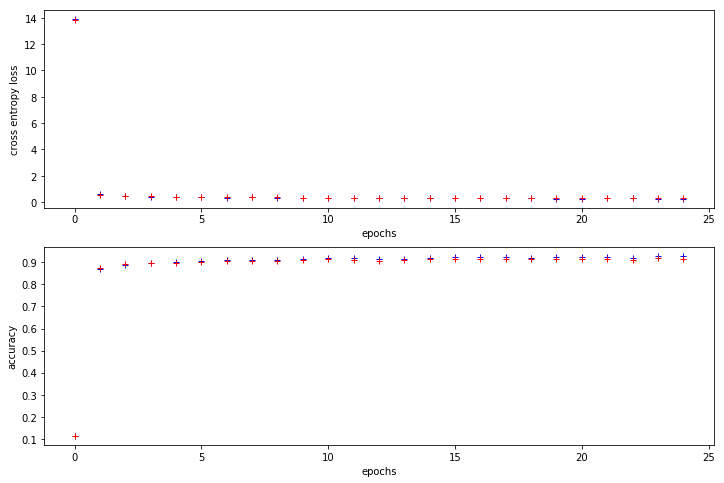

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


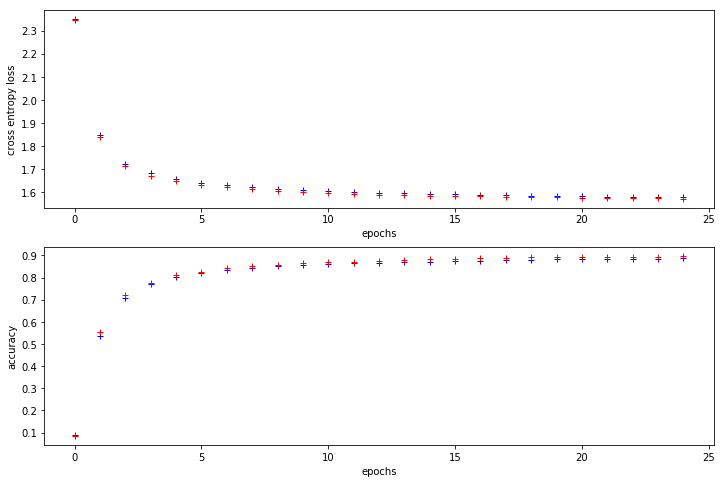

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


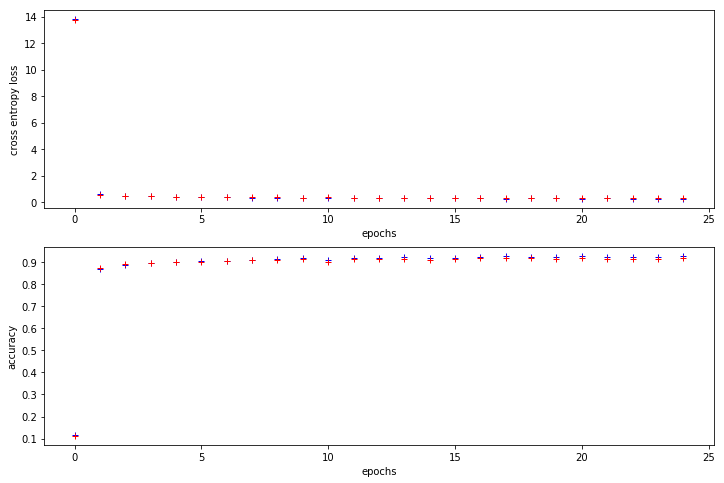

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


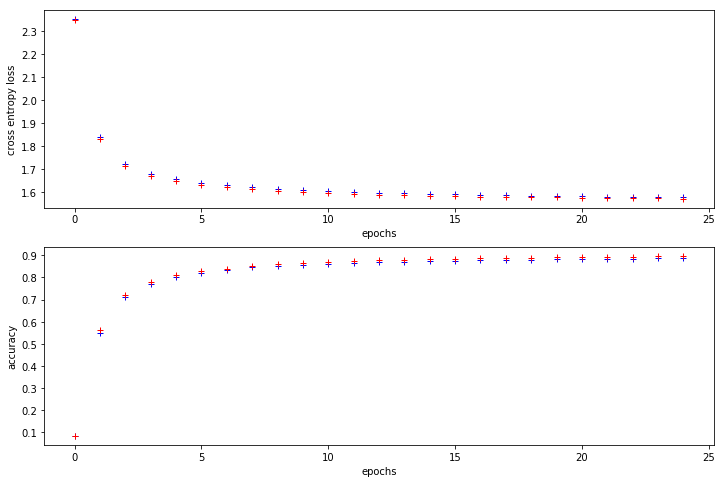

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


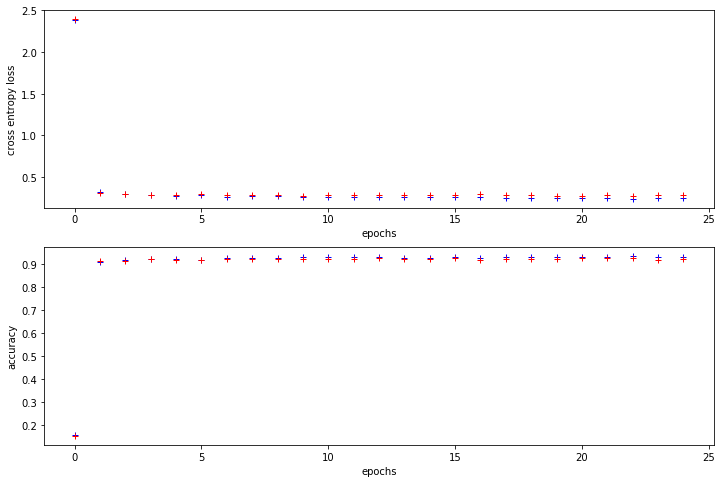

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


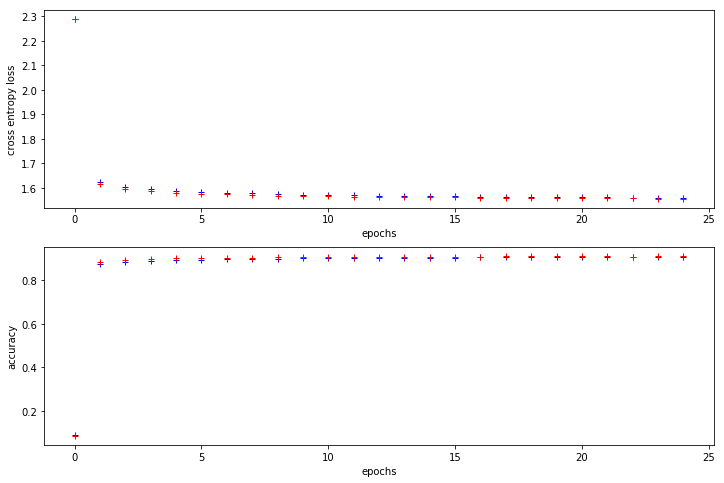

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


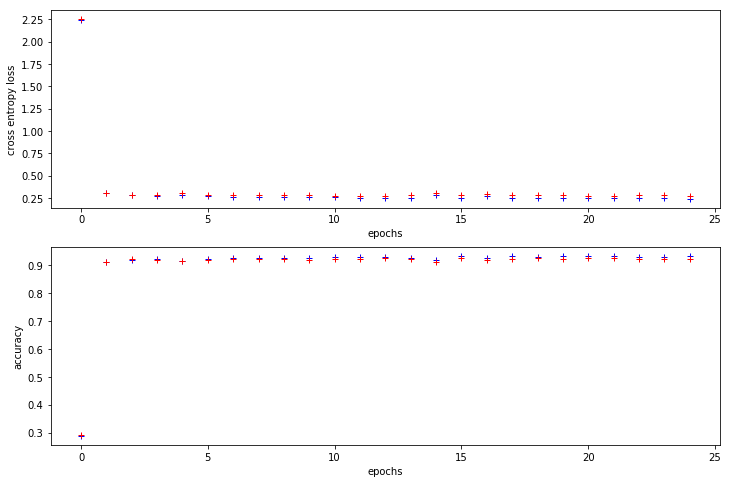

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


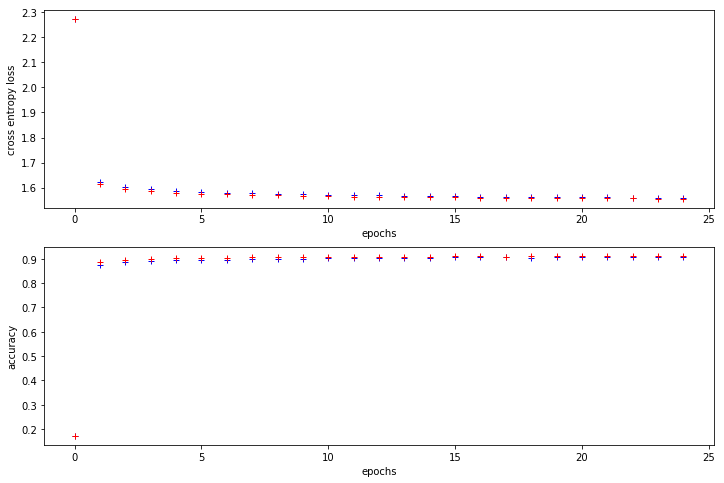

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


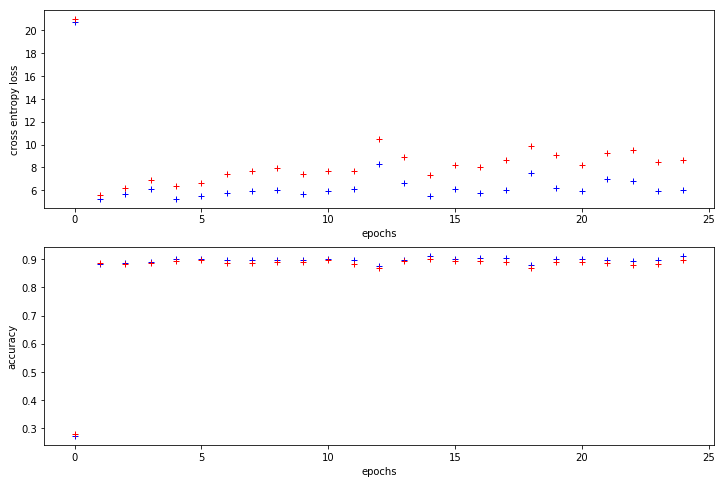

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


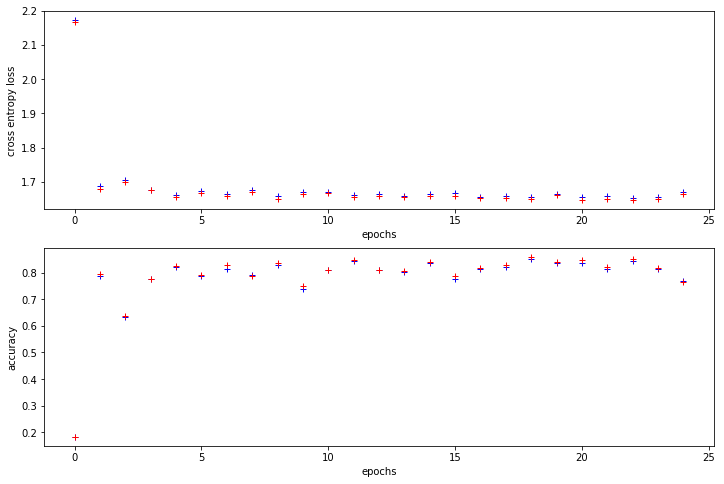

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


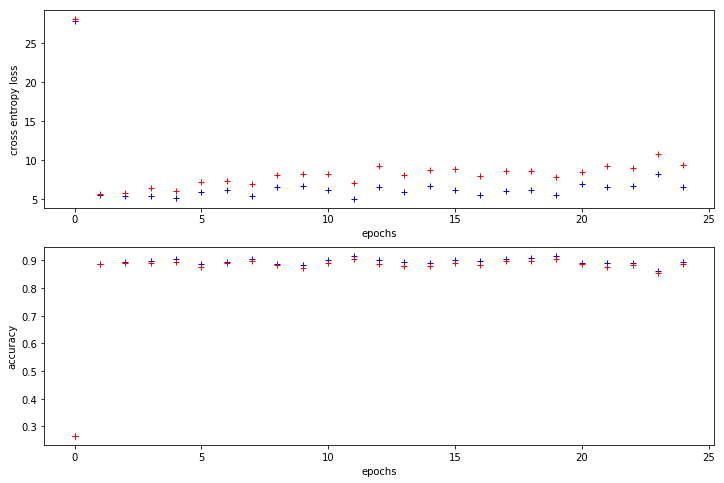

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


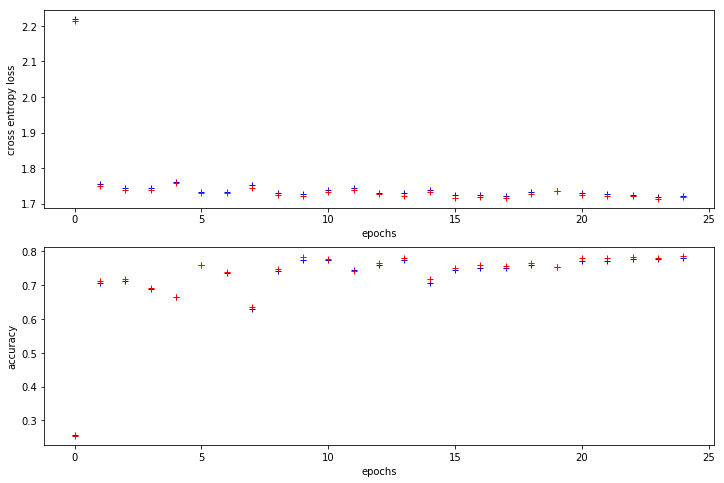

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


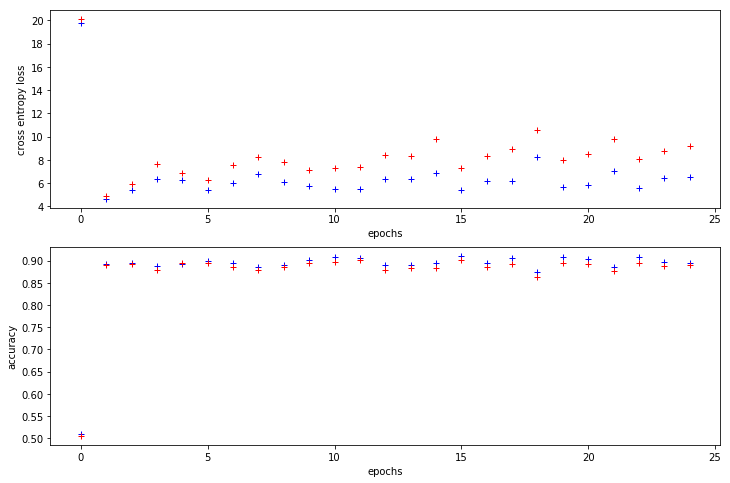

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


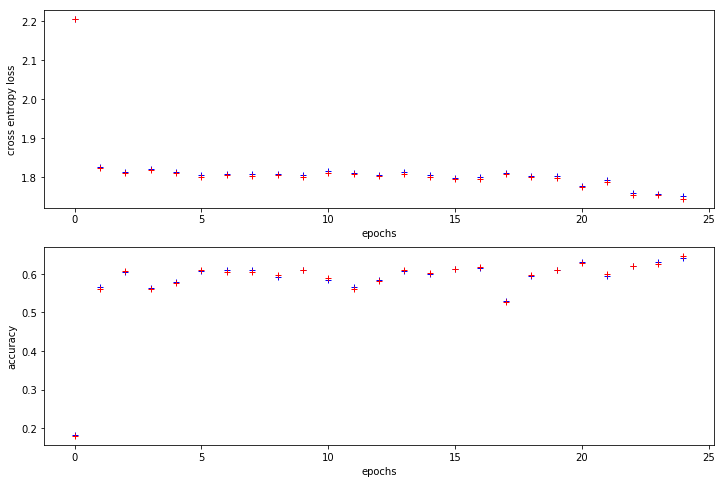

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


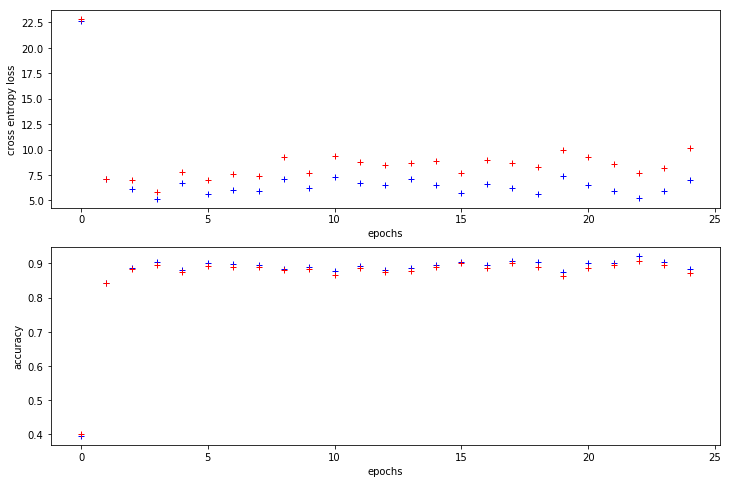

parameters:  {'learning_rate': 0.5, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


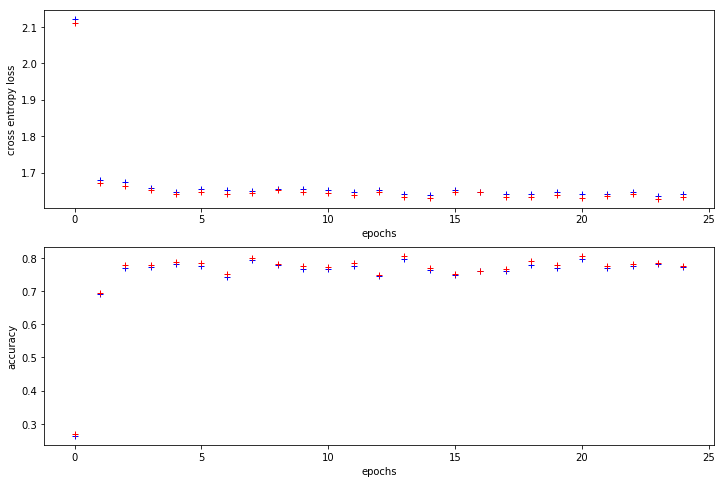

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


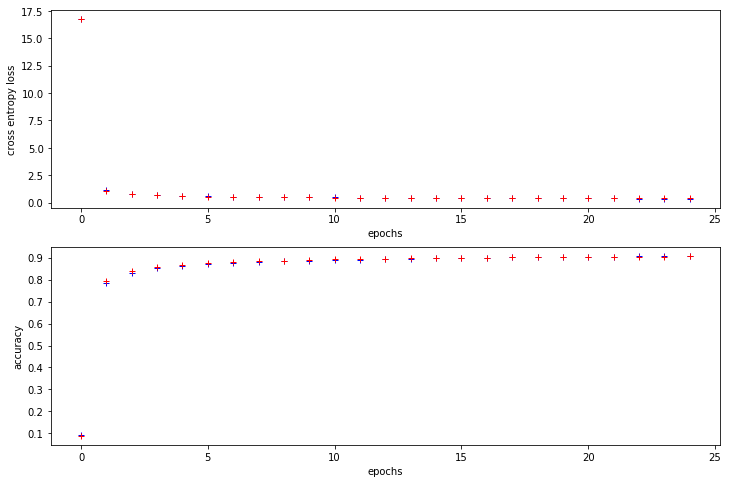

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


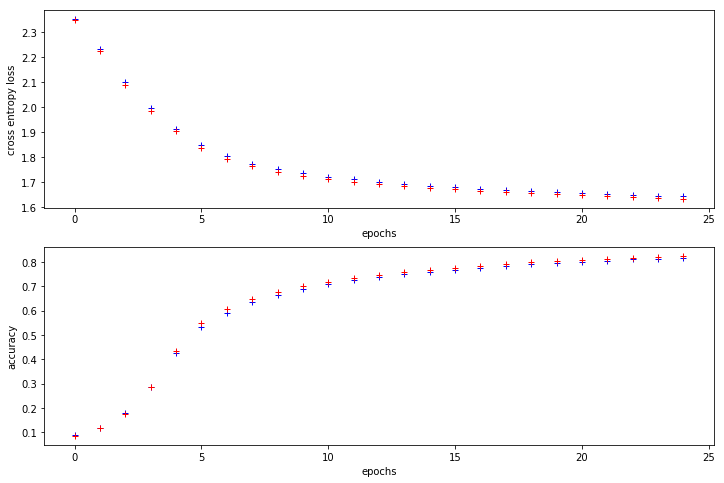

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


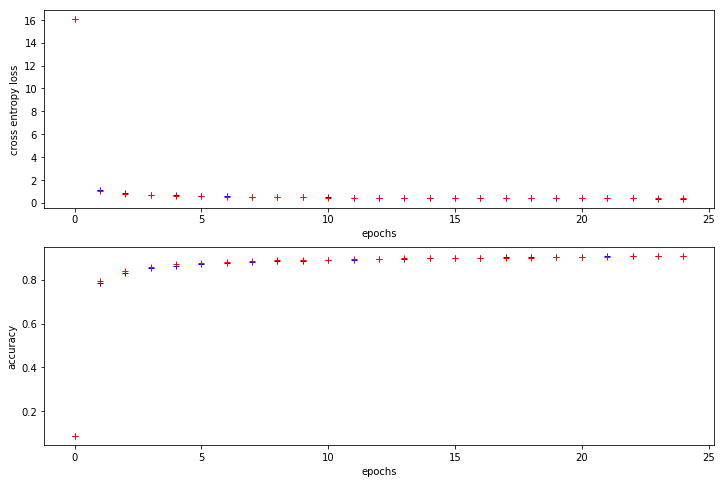

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


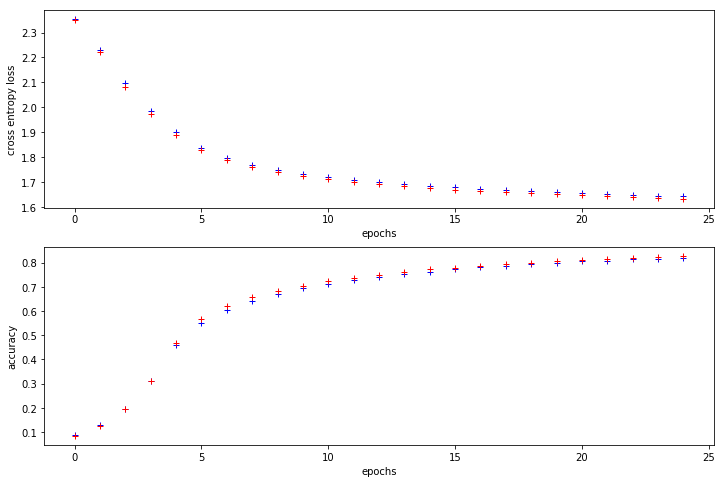

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


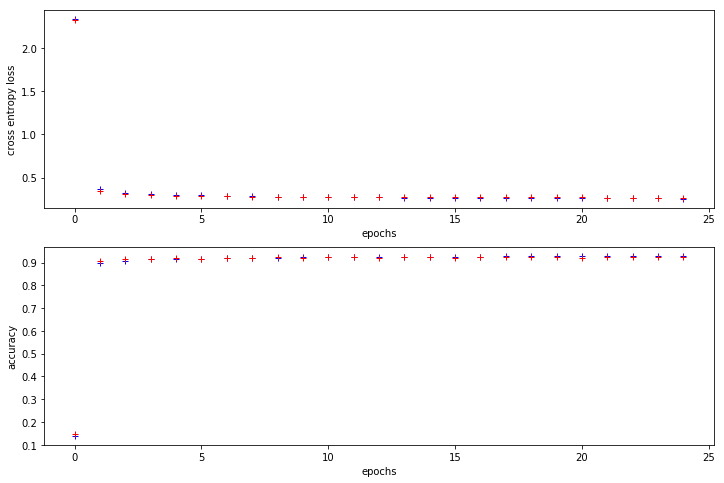

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


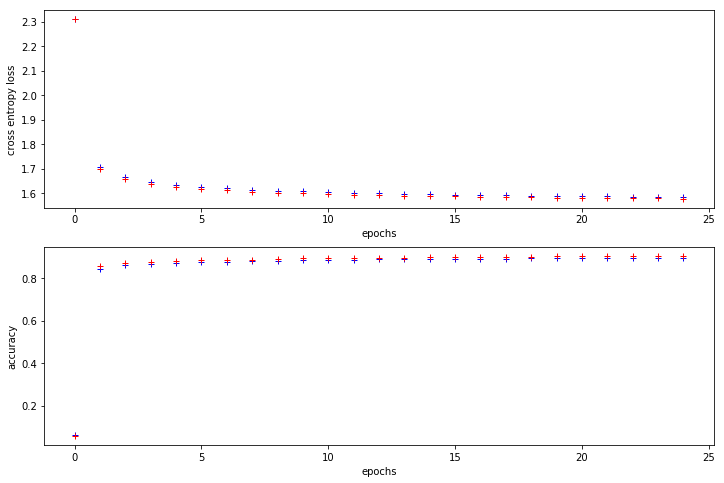

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


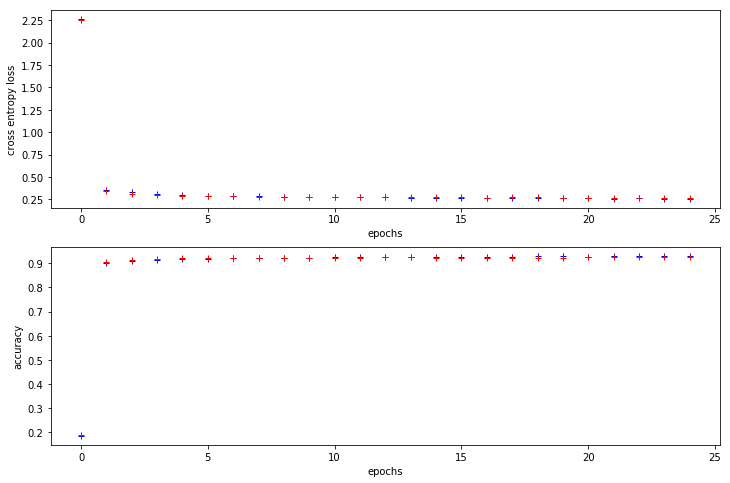

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


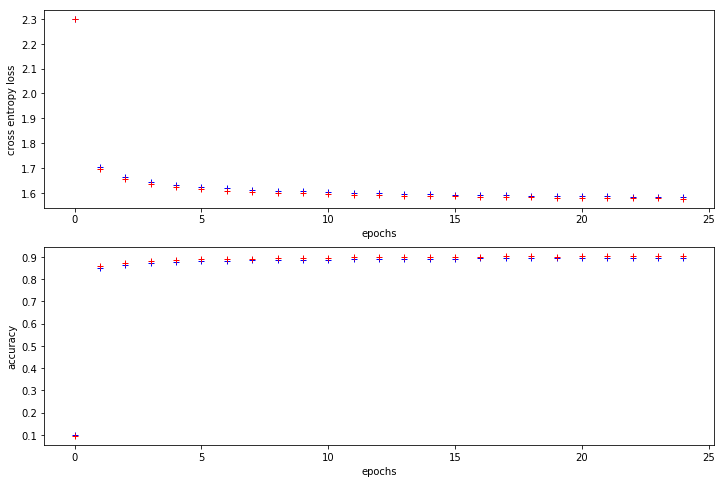

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


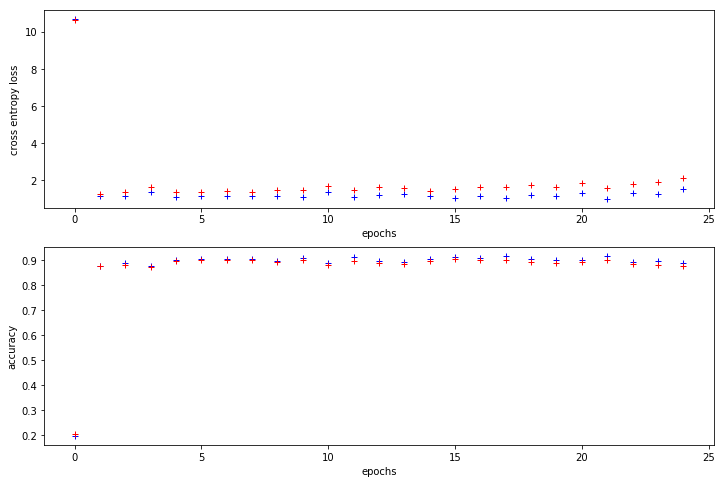

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


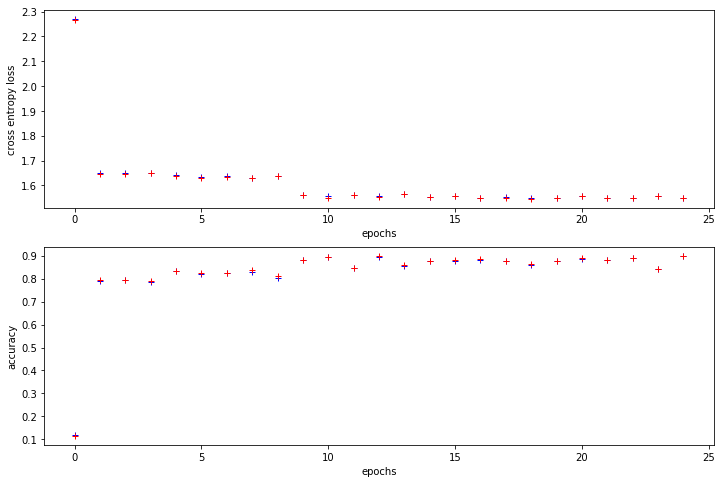

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


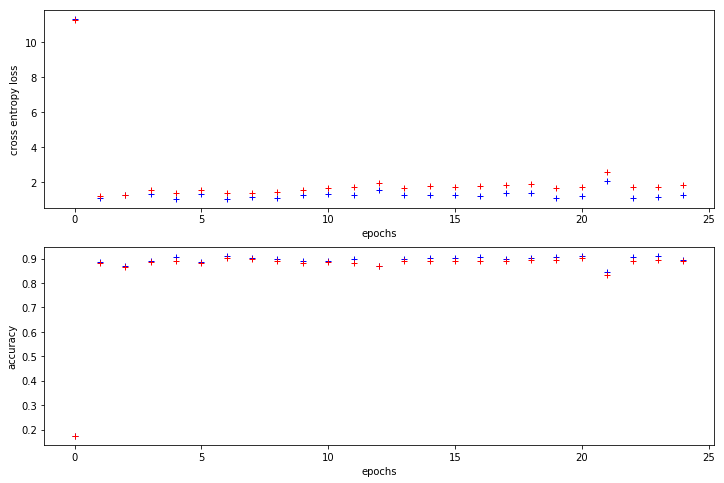

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


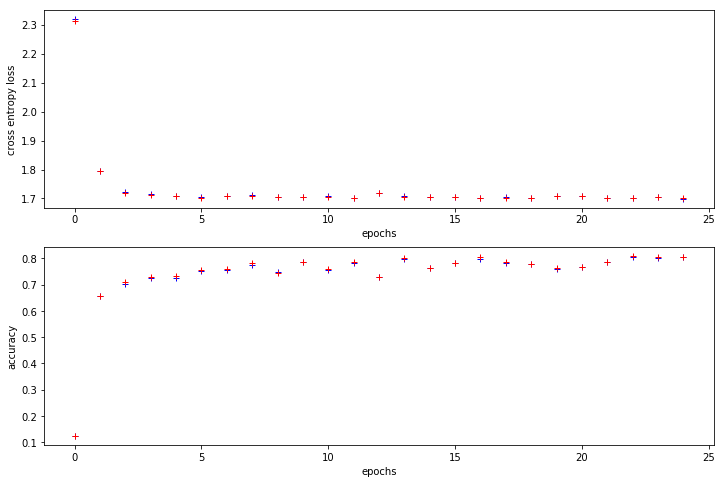

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


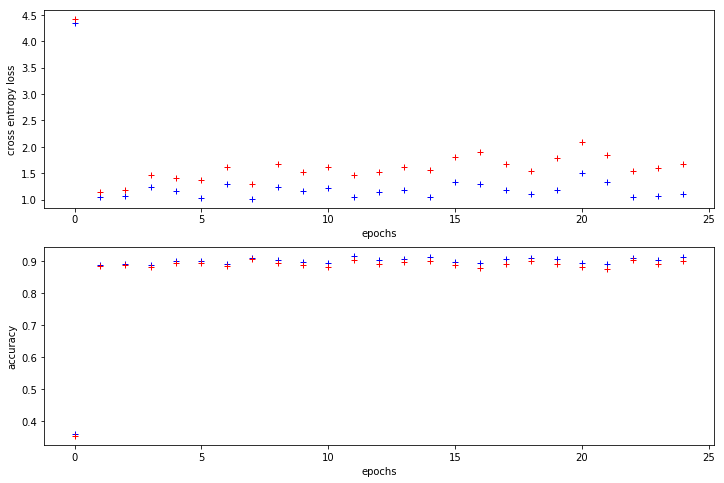

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


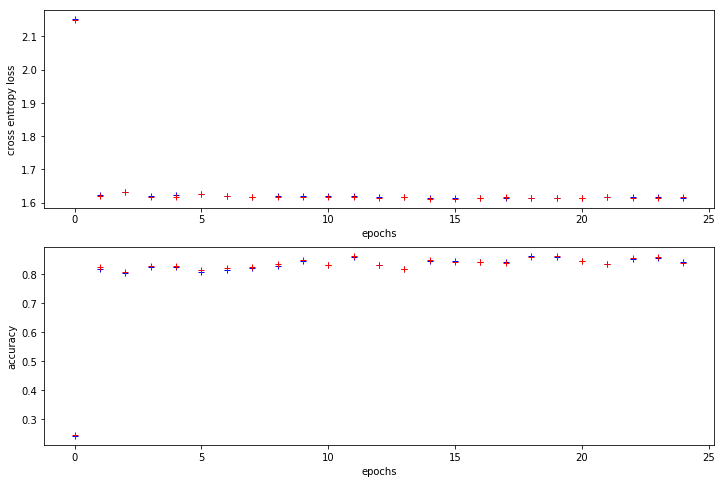

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


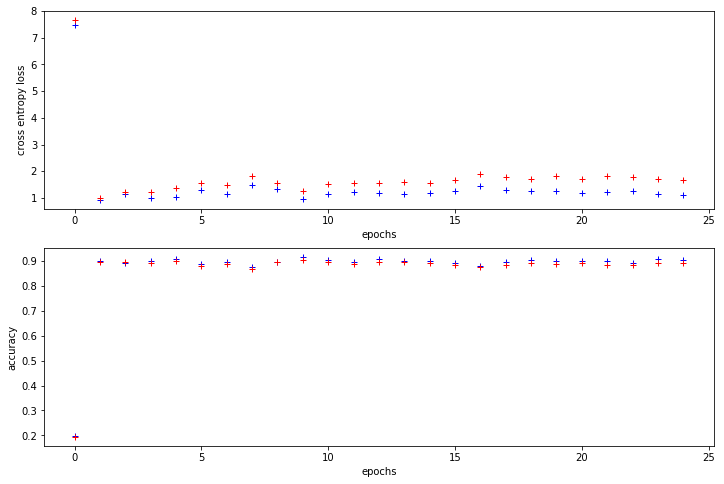

parameters:  {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


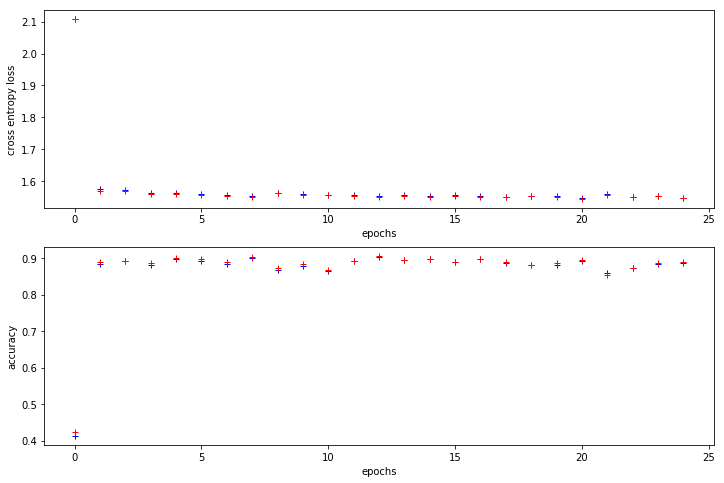

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


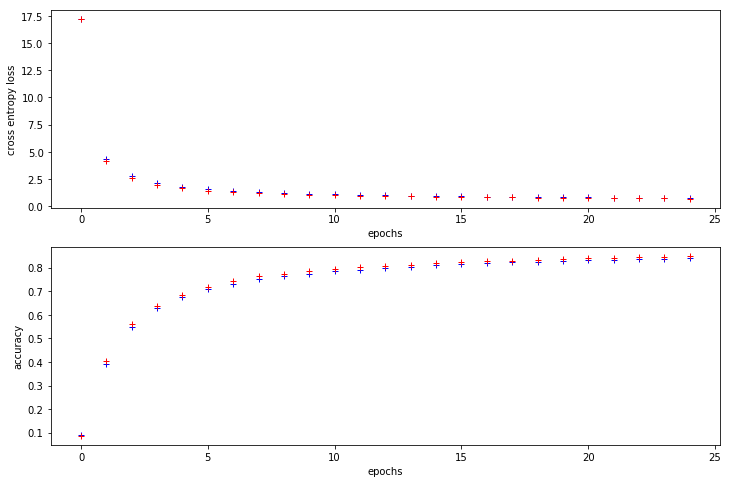

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


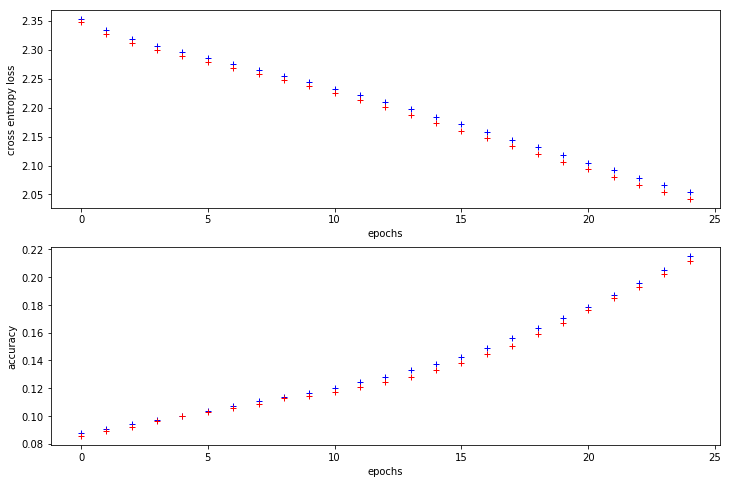

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


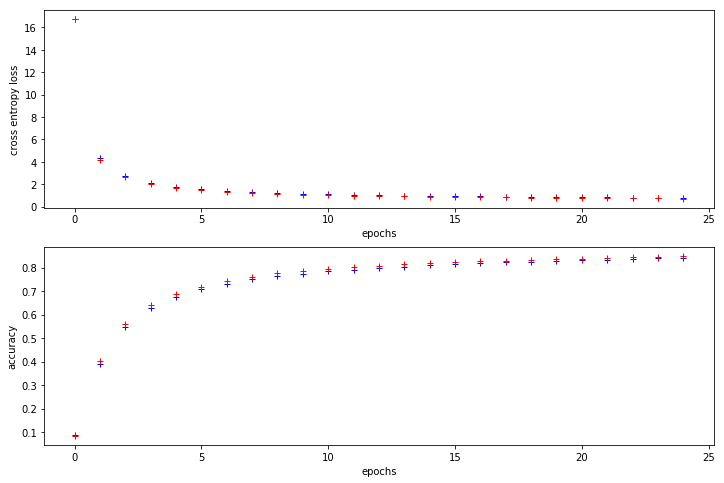

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


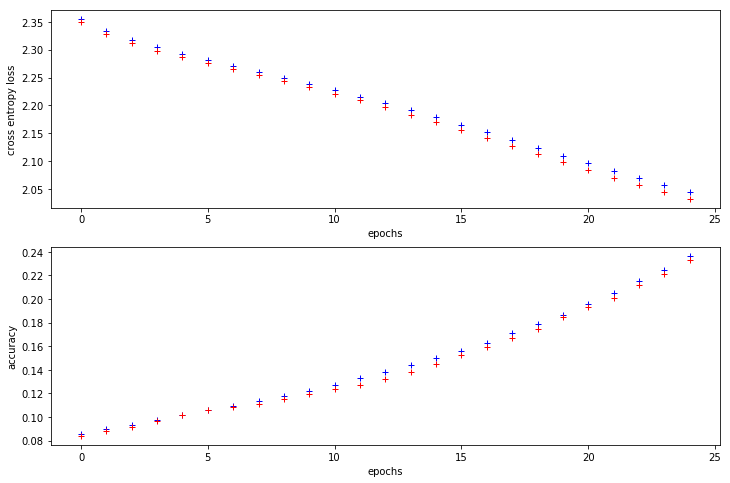

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


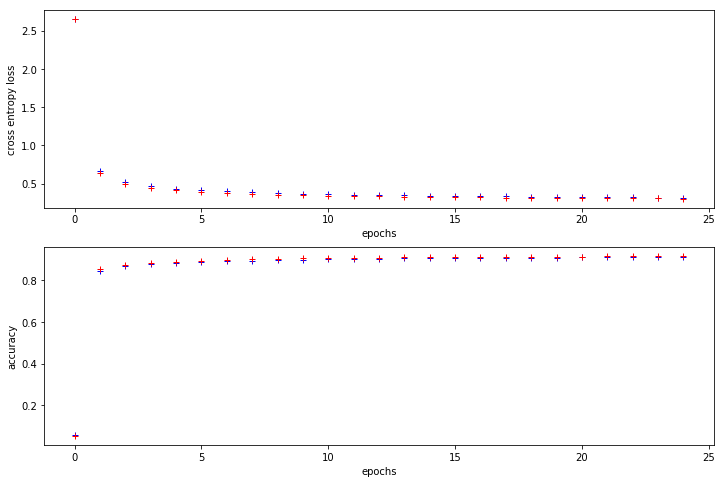

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


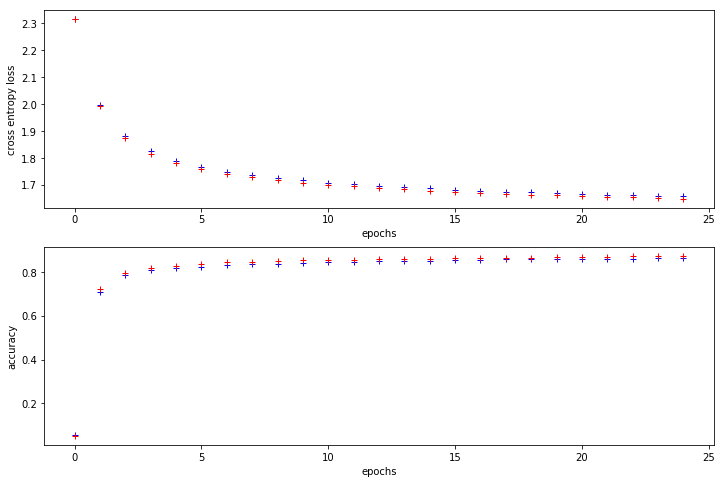

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


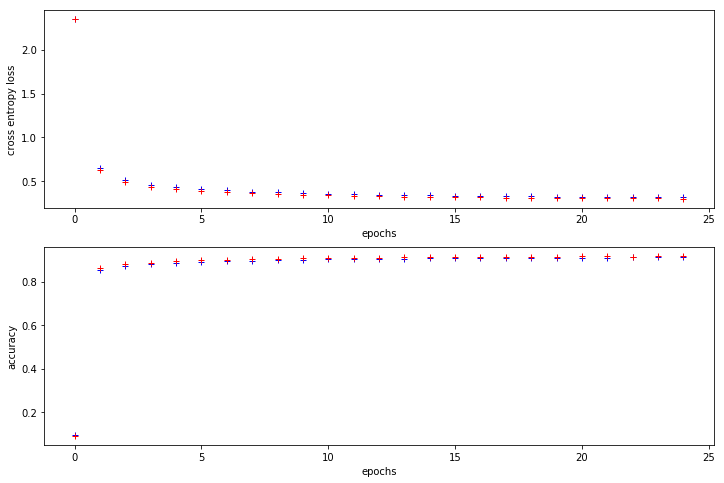

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


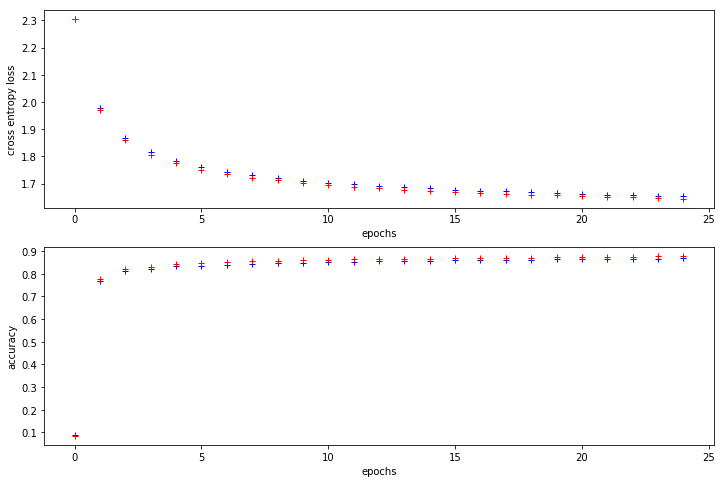

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


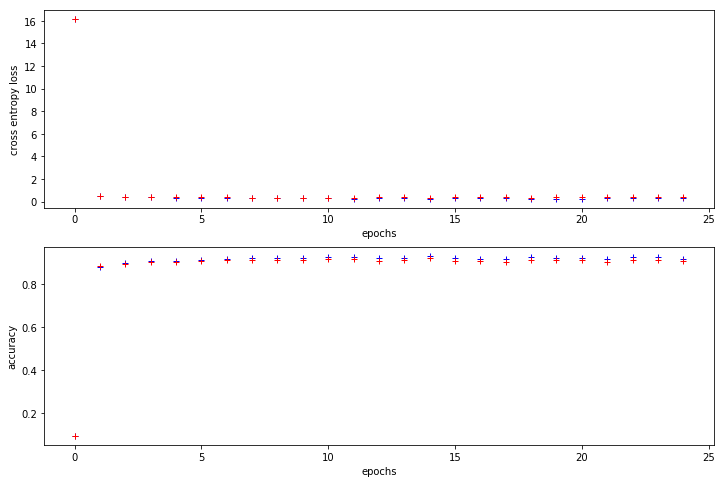

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


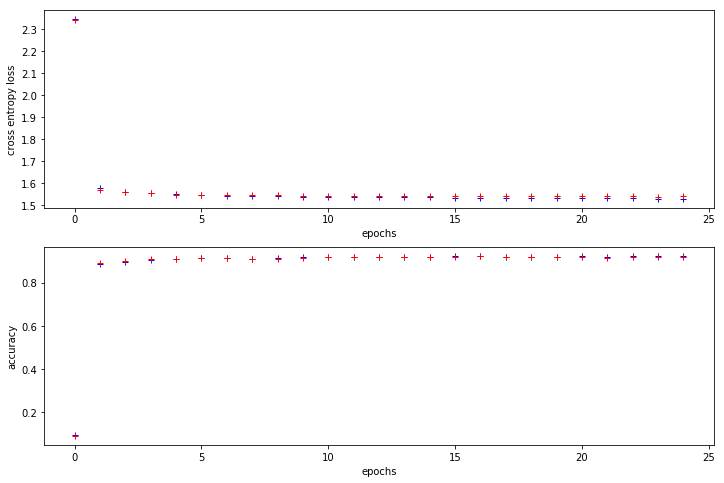

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


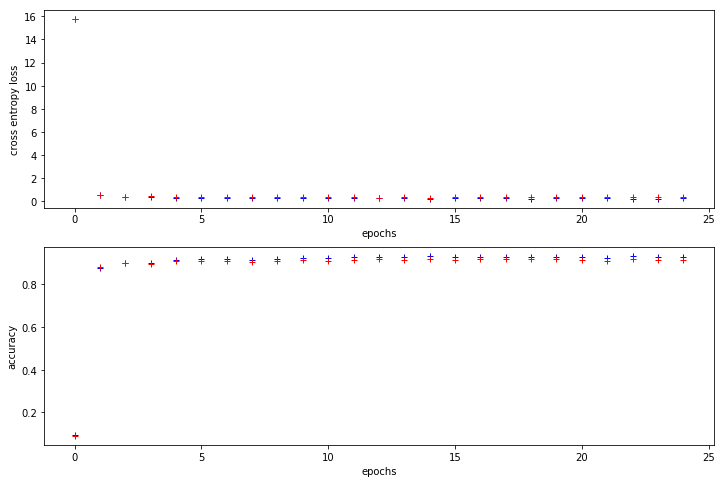

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


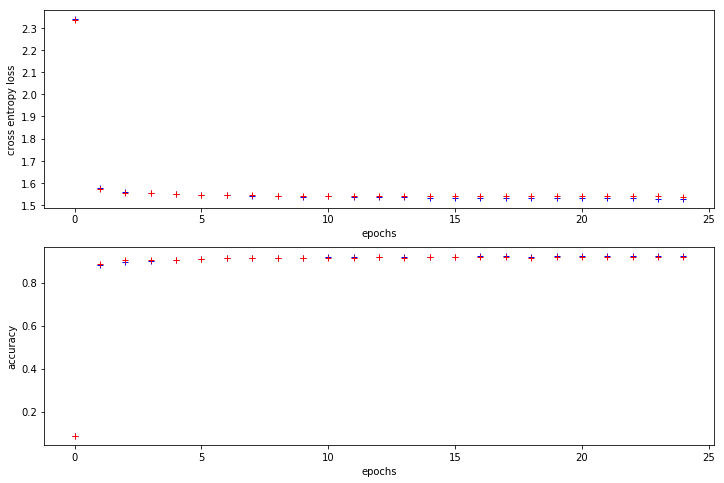

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


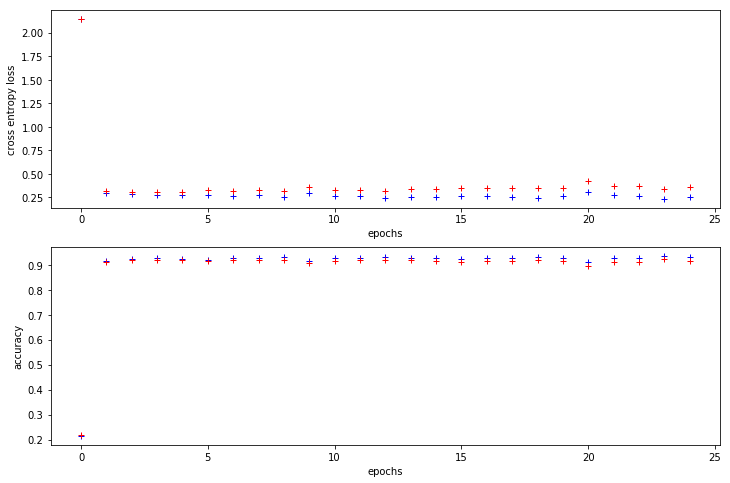

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function random_normal at 0x7f9df02c0730>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


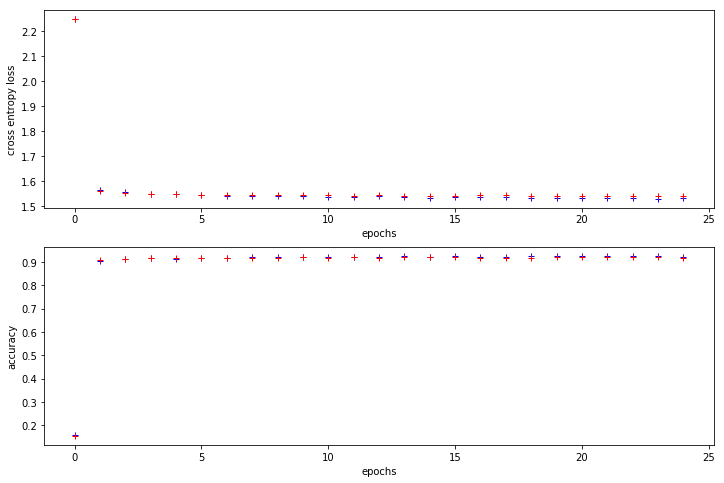

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}


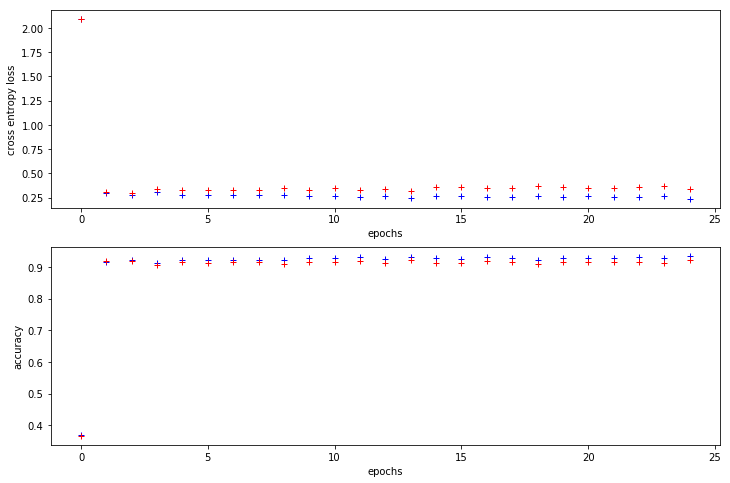

parameters:  {'learning_rate': 0.01, 'optimizer_fn': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function sigmoid at 0x7f9df035ea60>}


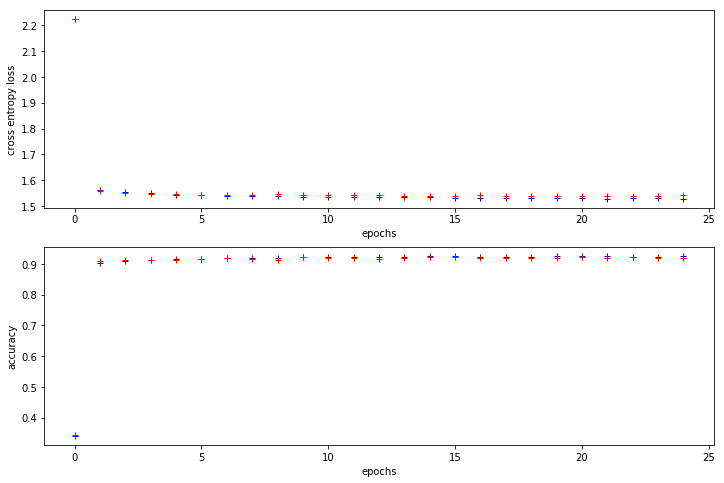

[{'parameters': {'learning_rate': 0.1, 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>, 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>, 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>}, 'summaries': [{'epoch': 0, 'batch': 0, 'train_loss': 2.2659247, 'train_accuracy': 0.1862, 'test_loss': 2.2588975, 'test_accuracy': 0.1909}, {'epoch': 1, 'batch': 0, 'train_loss': 0.35909176, 'train_accuracy': 0.90105456, 'test_loss': 0.33930463, 'test_accuracy': 0.9066}, {'epoch': 2, 'batch': 0, 'train_loss': 0.32724407, 'train_accuracy': 0.90754545, 'test_loss': 0.31216922, 'test_accuracy': 0.913}, {'epoch': 3, 'batch': 0, 'train_loss': 0.3084811, 'train_accuracy': 0.9125636, 'test_loss': 0.29600278, 'test_accuracy': 0.9178}, {'epoch': 4, 'batch': 0, 'train_loss': 0.29843938, 'train_accuracy': 0.9164182, 'test_loss': 0.28924945, 'test_accuracy'

In [443]:
# 1 Layer Shallow Network
# Architecture: X -> Output Layer -> Argmax -> Y
# Grid search over learning rate, optimizers, weight initializations, bias initializations, output activation fns
# Goal: find optimal hyper parameters for shallow network

parameter_combinations = []
for learning_rate in [0.5, 0.1, 0.01]:
    for optimizer_fn in [tf.train.GradientDescentOptimizer, tf.train.AdamOptimizer]:
        for weight_initializer_fn in [tf.random_normal, xavier_initializer]:
            for bias_initializer_fn in [tf.random_normal, tf.zeros]:
                for output_activation_fn in [pass_through_activation, tf.sigmoid]:
                    parameters = {
                        'learning_rate': learning_rate,
                        'optimizer_fn': optimizer_fn,
                        'weight_initializer_fn': weight_initializer_fn,
                        'bias_initializer_fn': bias_initializer_fn,
                        'output_activation_fn': output_activation_fn
                    }
                    parameter_combinations.append(parameters)
results = []
for parameters in parameter_combinations:
    print('parameters: ', parameters)
    tf.reset_default_graph()
    tf.set_random_seed(0)
    X = tf.placeholder(tf.float32, shape=[None, n_X])                    
    output_layer = nn_layer(X, n_X, n_Y, weight_initializer=parameters['weight_initializer_fn'], bias_initializer=parameters['bias_initializer_fn'], activation=parameters['output_activation_fn'])['output']
    optimizer = parameters['optimizer_fn'](learning_rate=parameters['learning_rate'])
    summaries = train(output_layer, optimizer, epochs=25, print_progress=False)['summaries']
    plot_summaries(summaries)
    results.append({
        'parameters': parameters,
        'summaries': summaries
    })

sorted_results = sorted(results, key=lambda x: x['summaries'][-1]['test_accuracy'], reverse=True)  
print(sorted_results)
                                                                                                                             

## Observations on Output Layer Results
Best result yield 92.5% test set accuracy on with following parameters:
- 'learning_rate': 0.1
- 'optimizer_fn': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>
- 'weight_initializer_fn': <function xavier_initializer at 0x7f9cafdf3e18>
- 'bias_initializer_fn': <function zeros at 0x7f9df071eae8>
- 'output_activation_fn': <function pass_through_activation at 0x7f9cafdf37b8>

Notes:
- Gradient Descent Optimizer likes bigger learning rates, 0.1-0.5 range, expected
- Adam Optimizer likes smaller learning rates should be 0.01-0.1 range, expected
- Suprisingly, Gradient Descent optimizer performed better than Adam optimizer, caveat being this is shallow network and further tuning required. I suspect Adam will shine on deeper networks.
- Xavier Init for weights and 0 bias initializations consistently outperformed any other normalized random, expected 
- Passthrough Activation (raw output) outperformed than sigmoid activation at output layer. I think I made mistake in training with tf.softmax_cross_entropy_with_logits on both sigmoid outputs and raw outputs.  I believe it expects unconstrained raw outputs. 
- Sigmoid activations performed better with Adam optimizer
- Saw several instances of overfitting when bias uses normalized random or when learning rate was too large for adam optimizer
- It would be nice to store outputs to SQL database on grid search results, slice and dice easier

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 32}


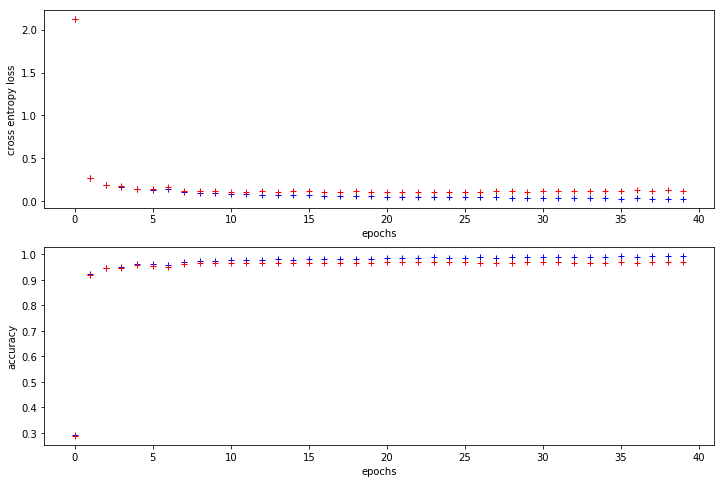

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 64}


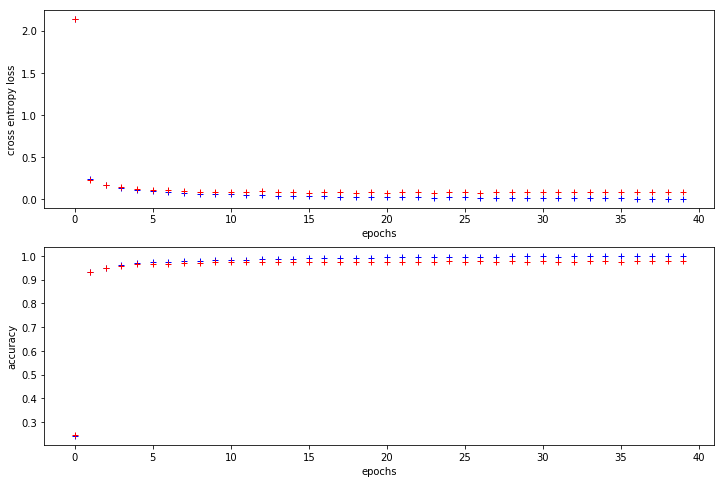

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 128}


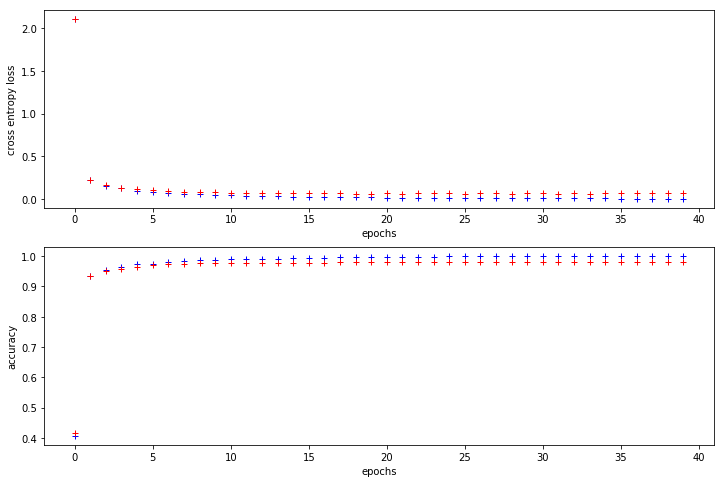

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


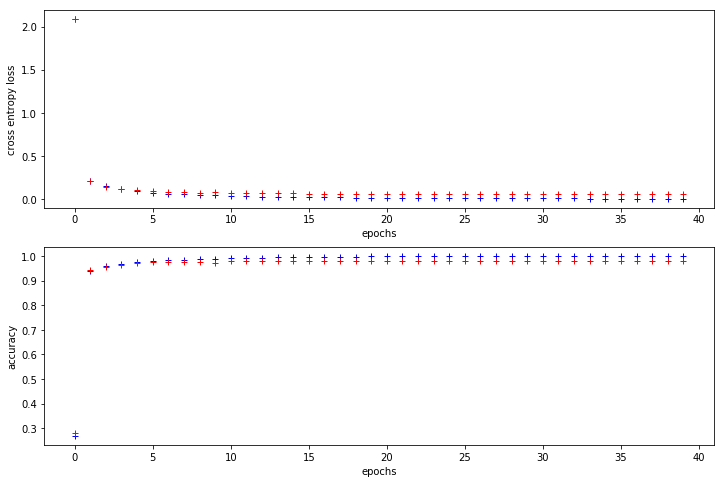

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 32}


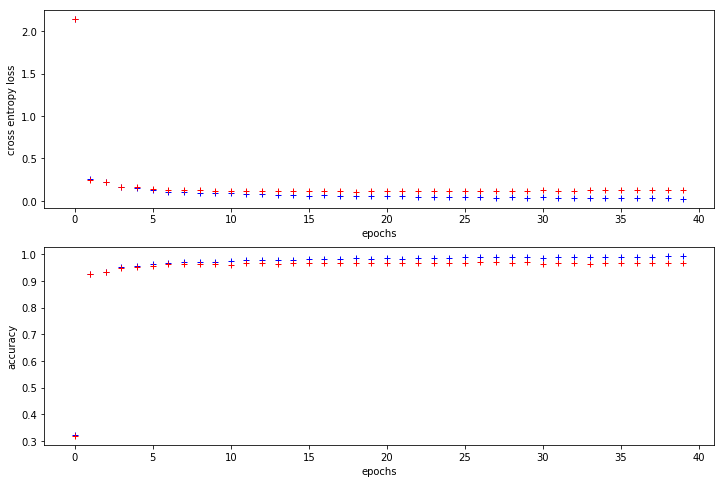

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 64}


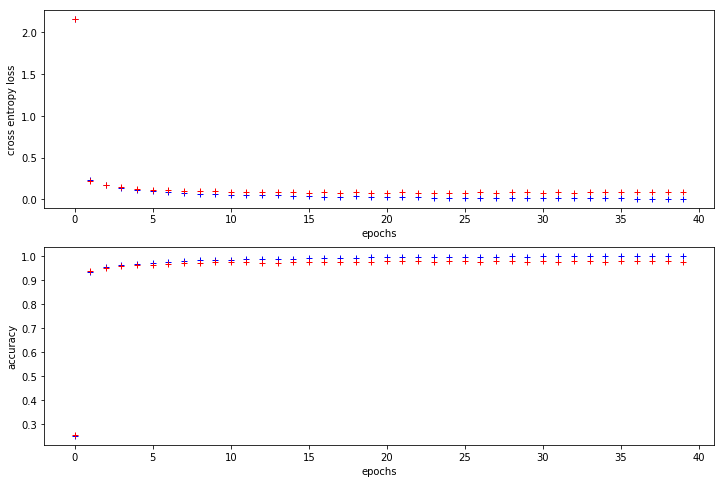

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 128}


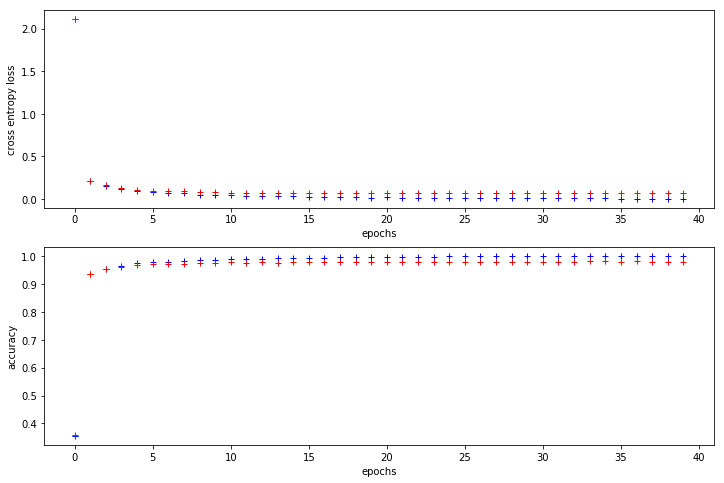

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


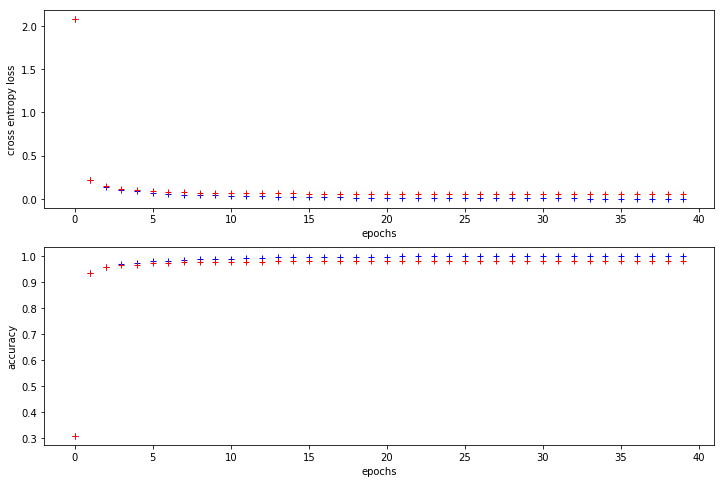

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 32}


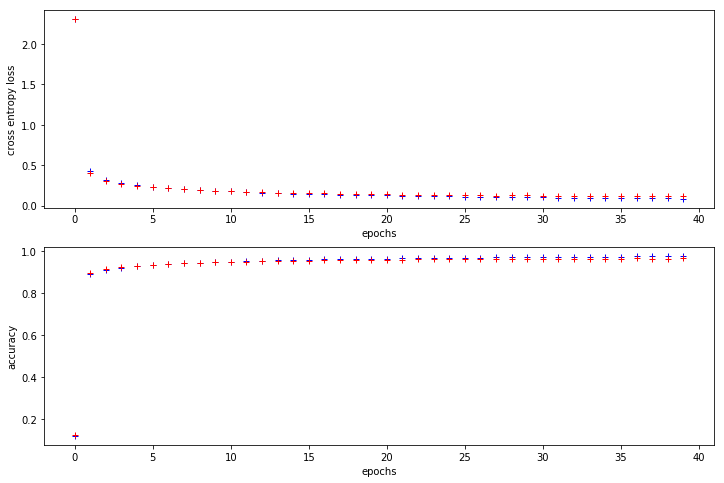

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 64}


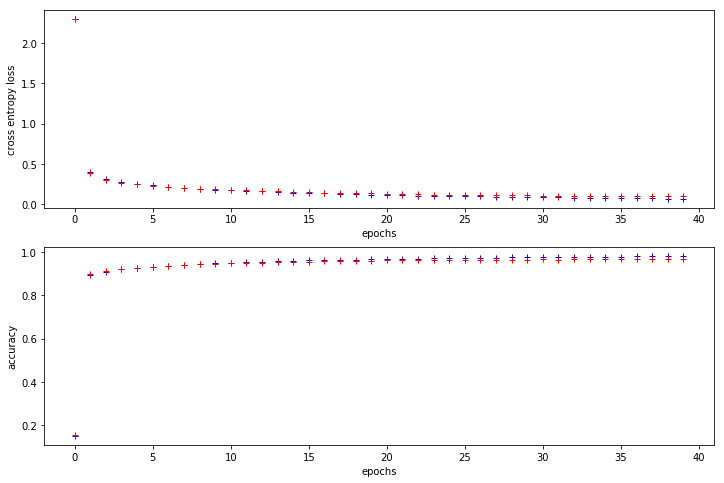

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 128}


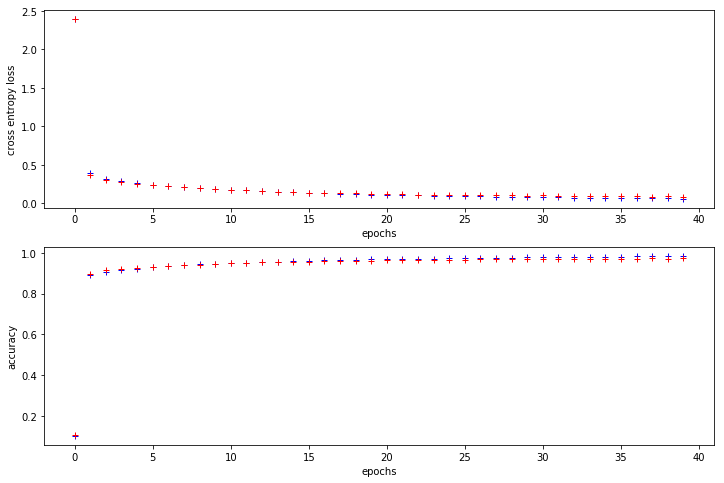

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


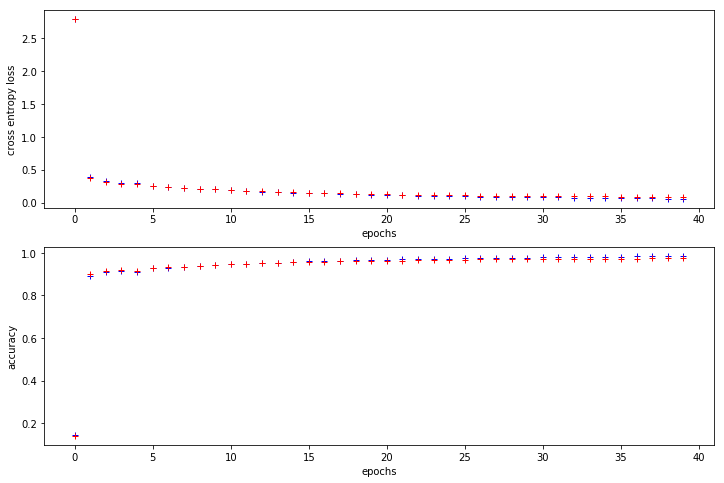

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 32}


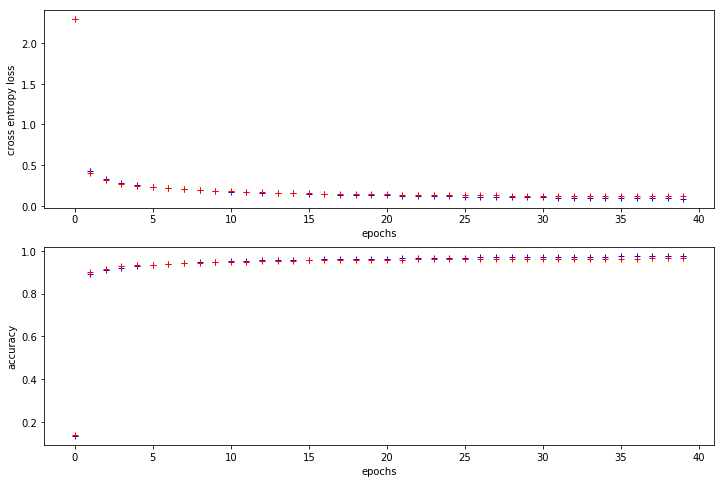

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 64}


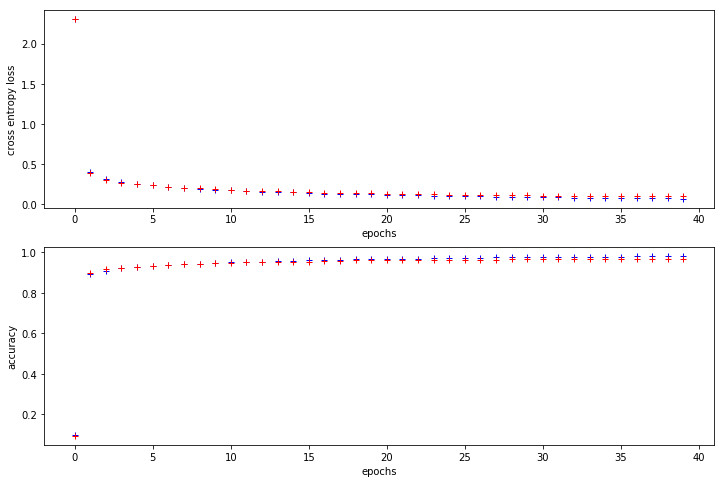

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 128}


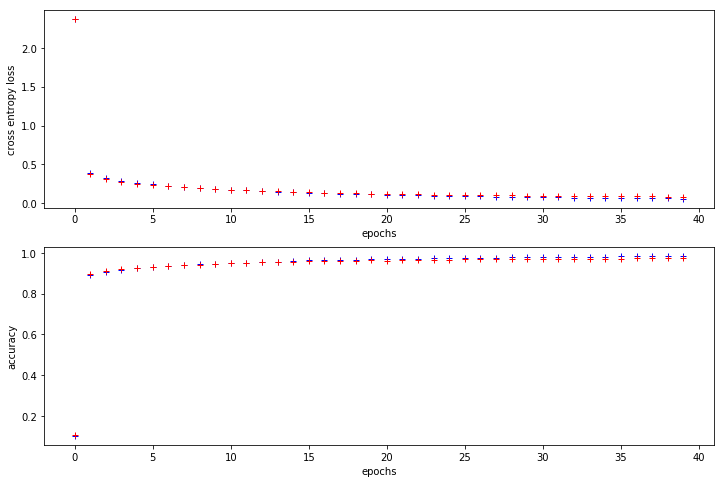

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


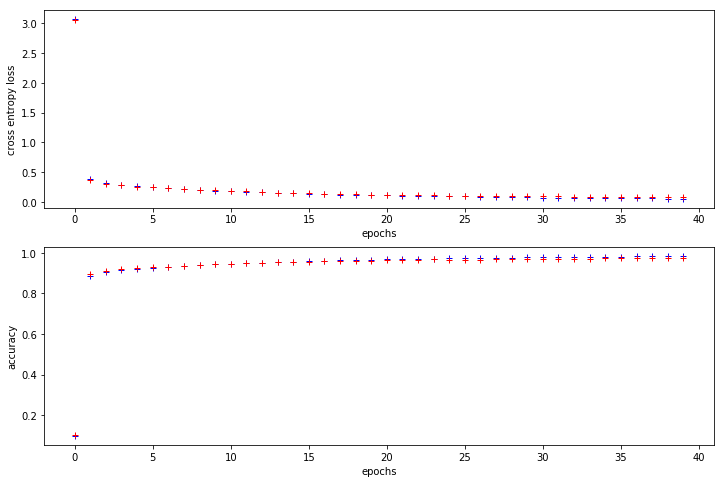

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 32}


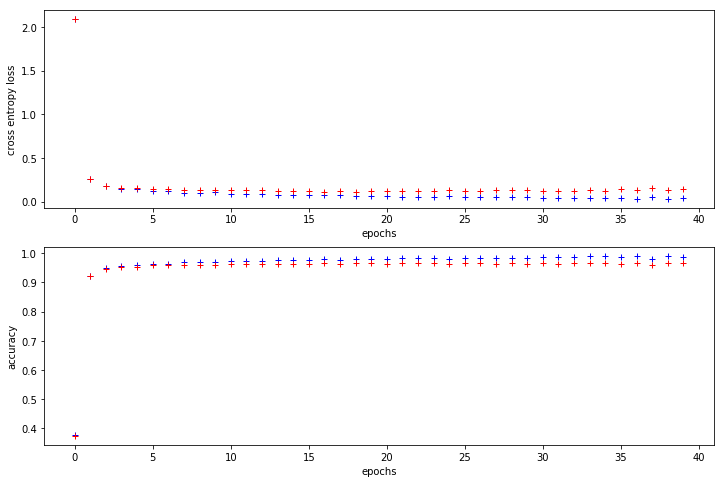

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 64}


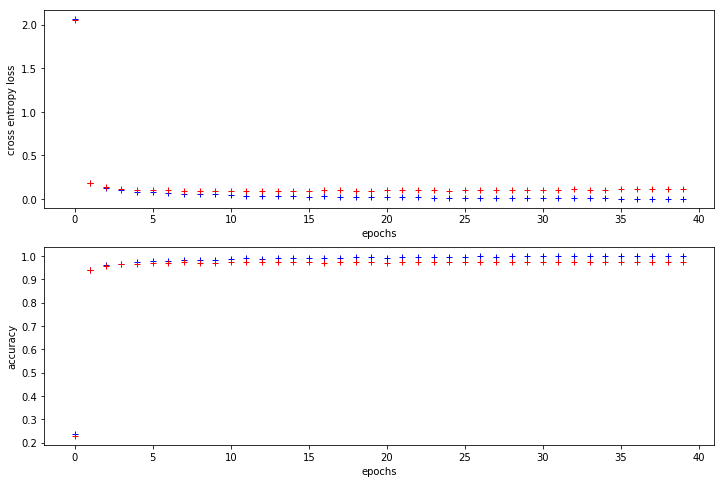

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 128}


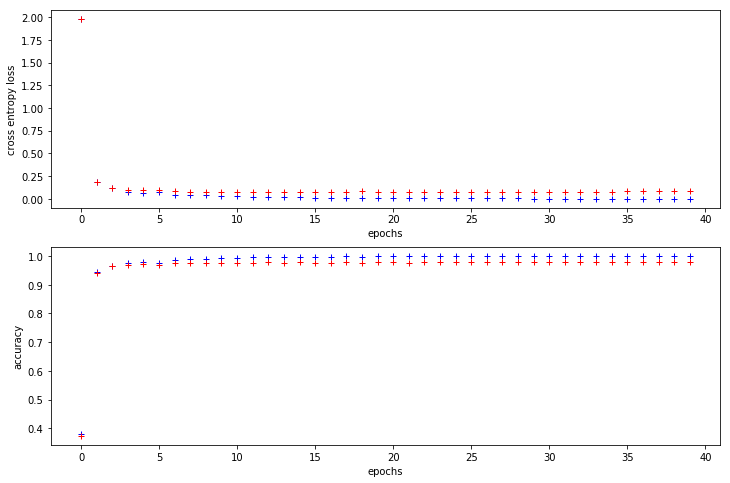

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


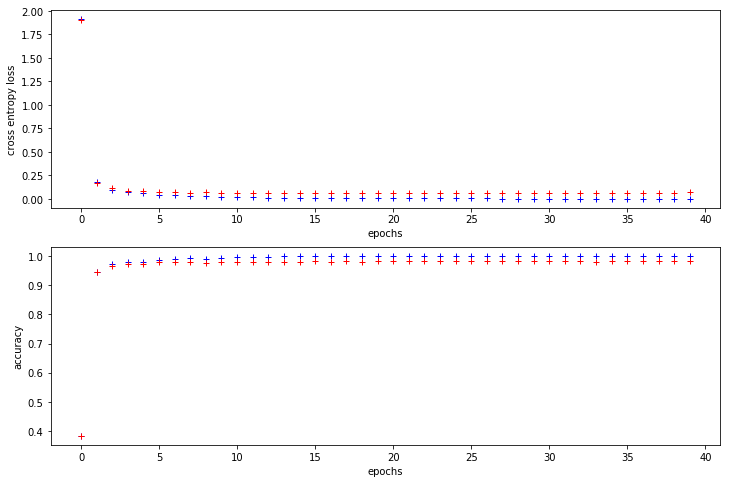

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 32}


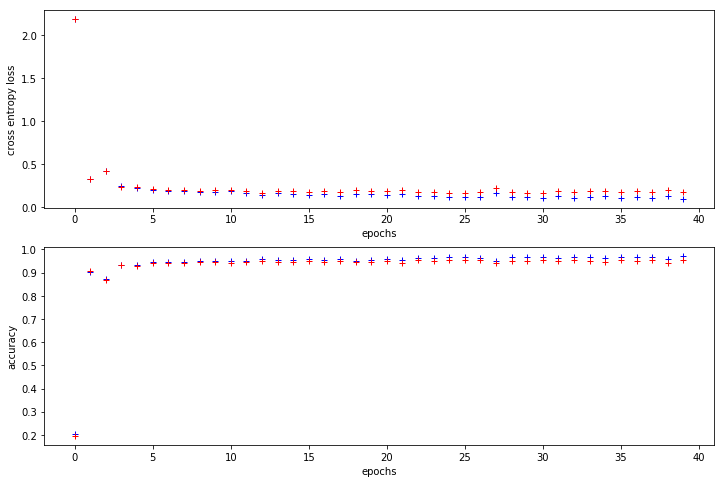

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 64}


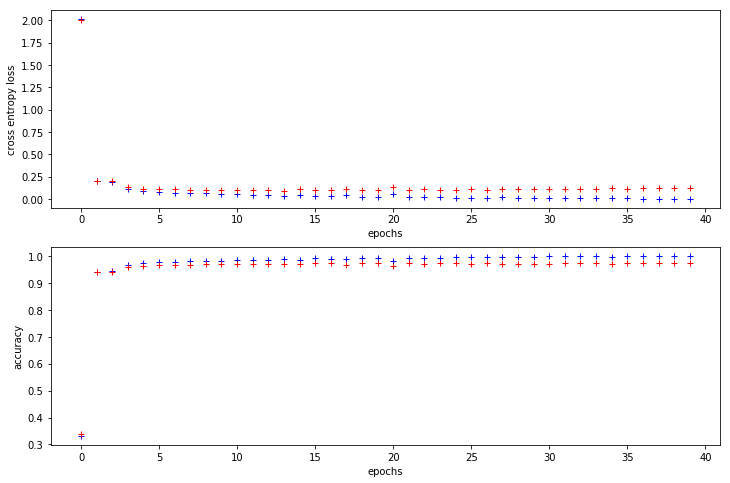

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 128}


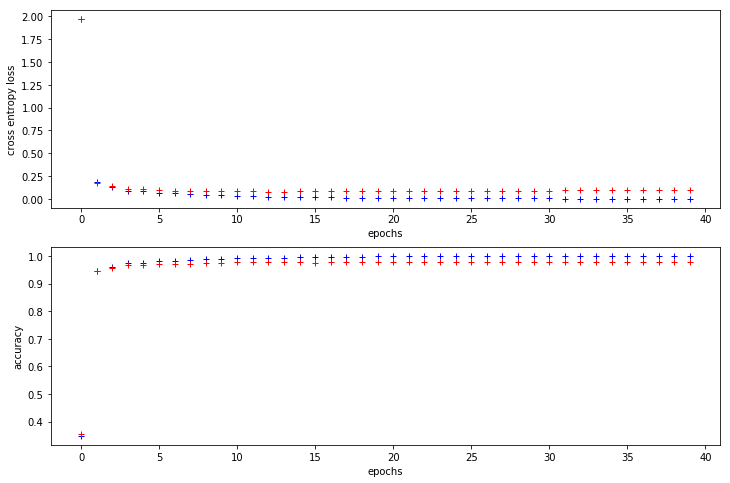

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


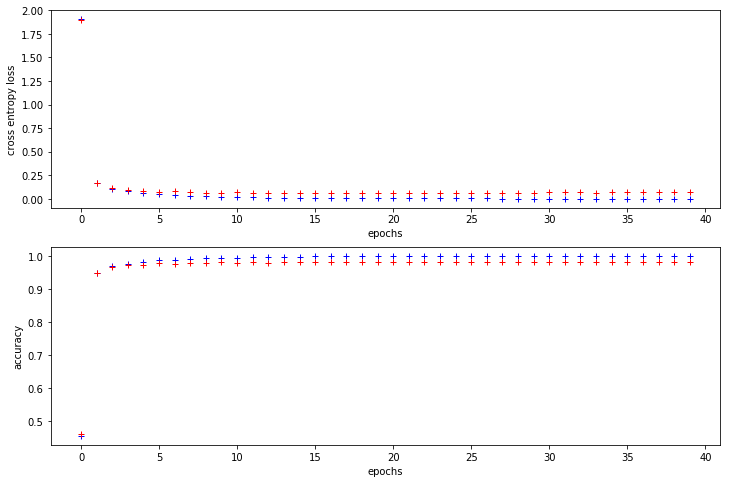

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 32}


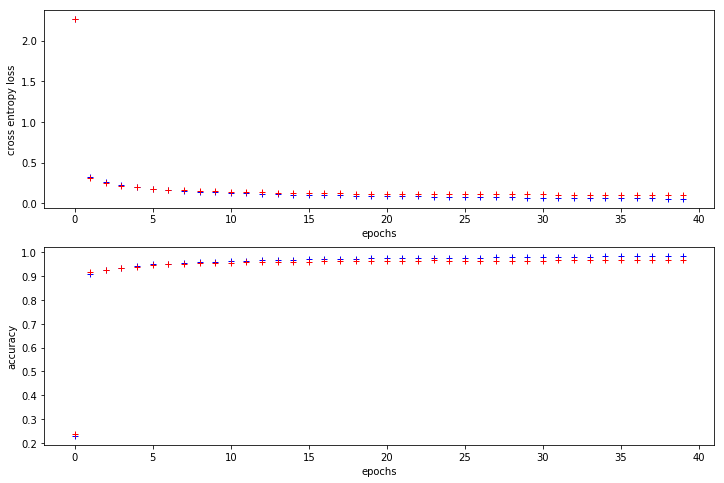

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 64}


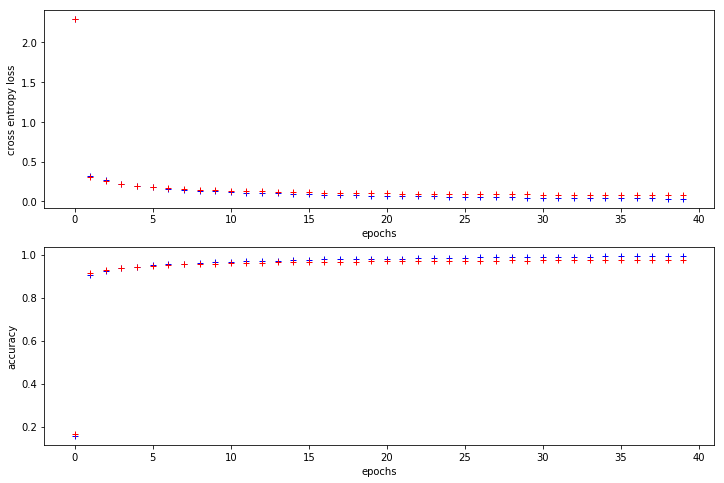

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 128}


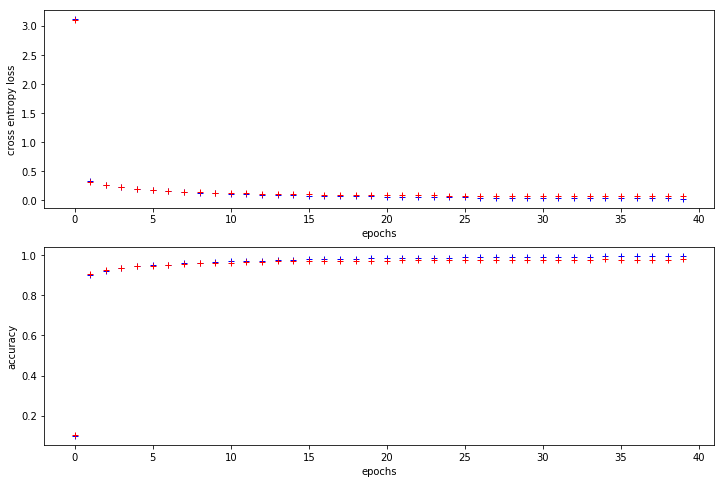

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


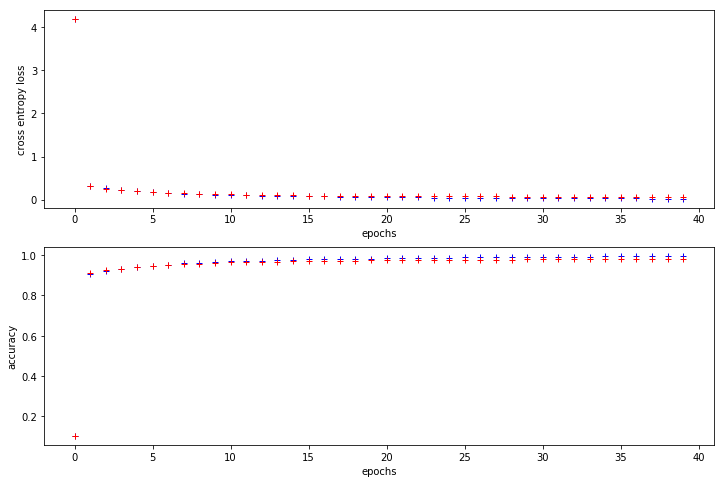

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 32}


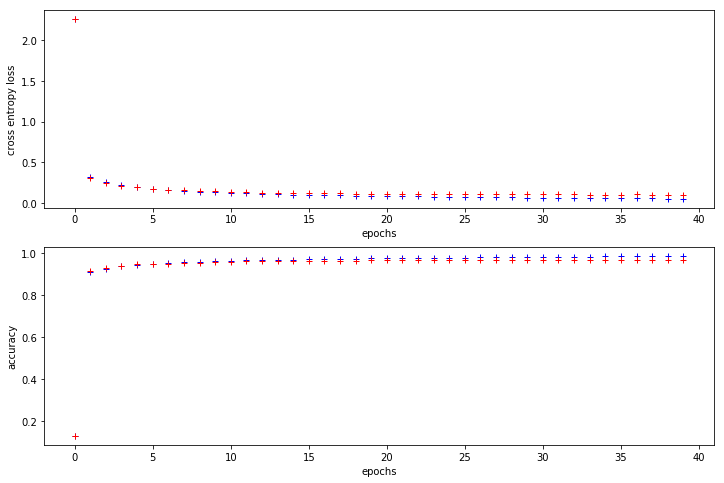

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 64}


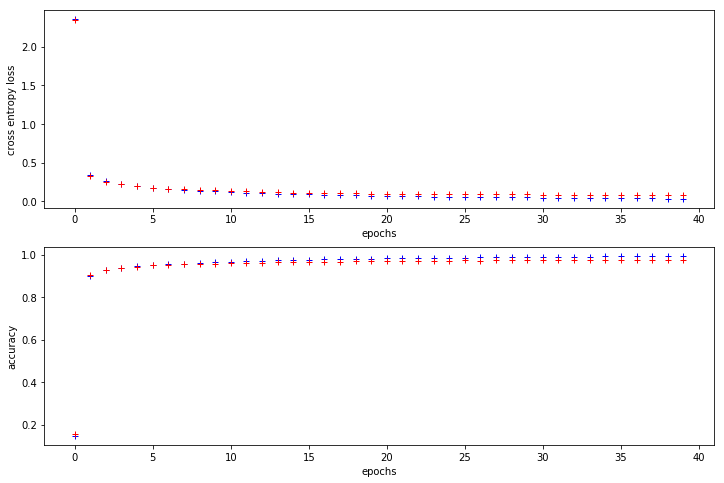

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 128}


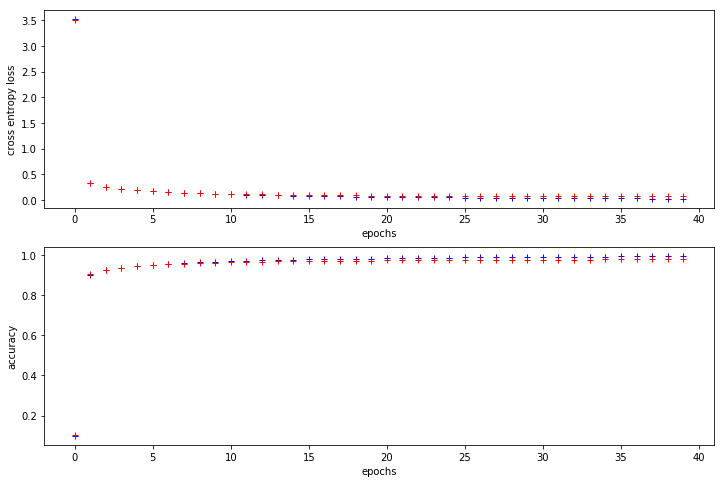

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


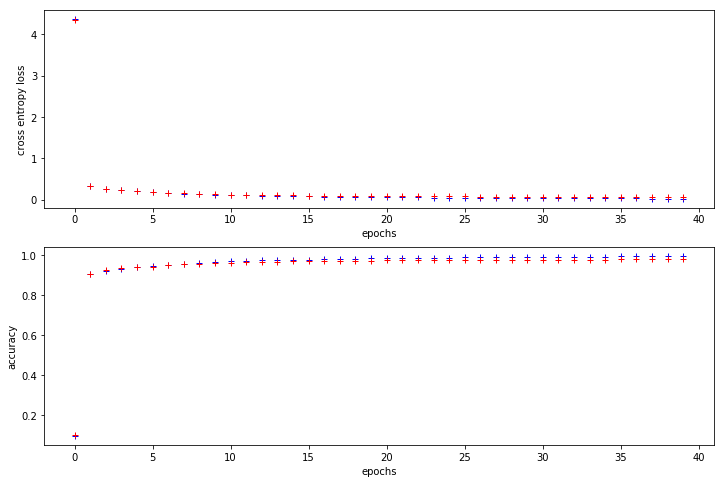

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 32}


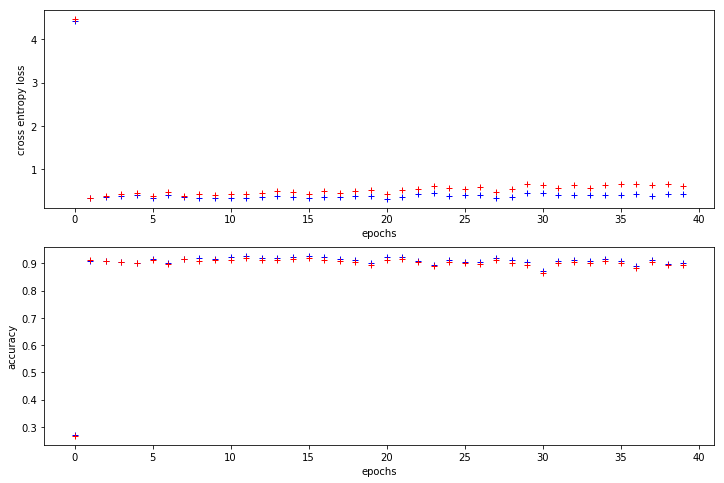

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 64}


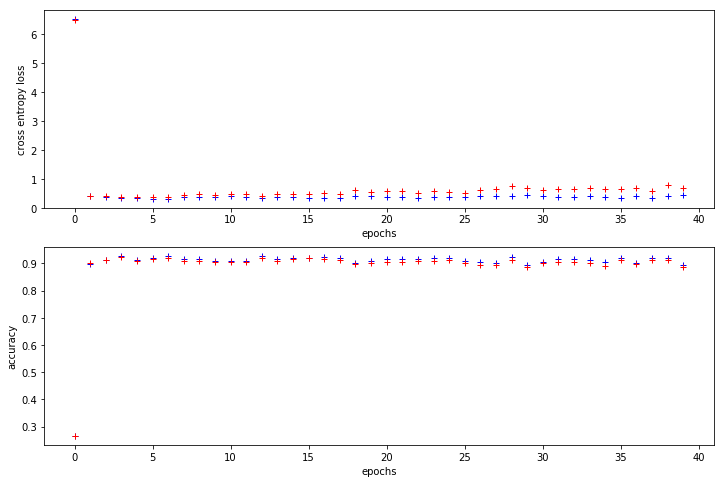

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 128}


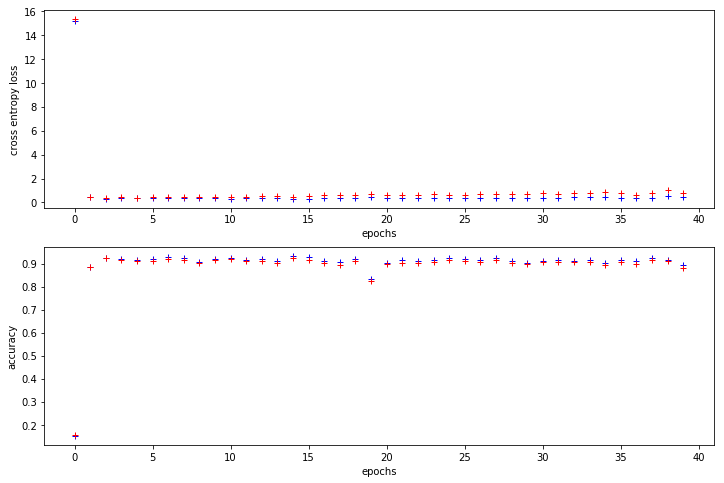

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


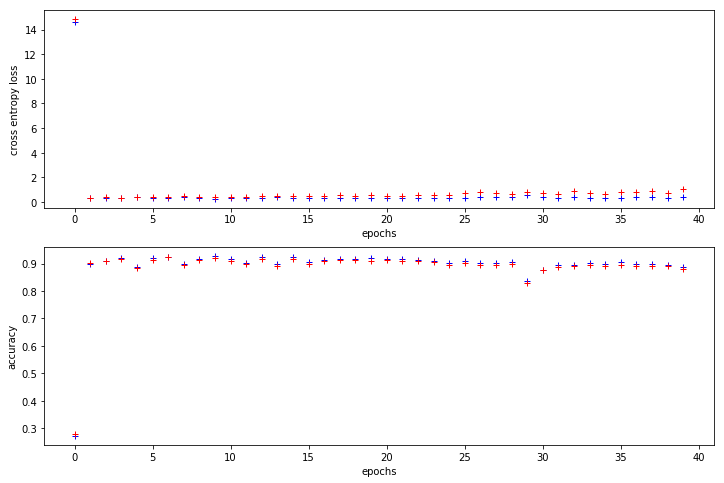

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 32}


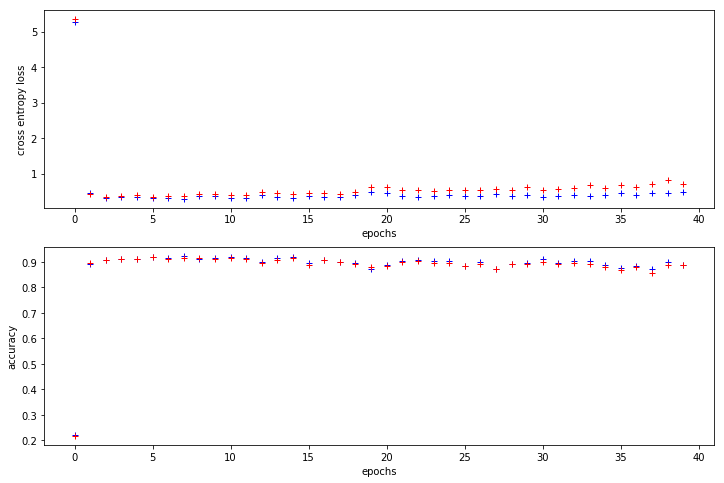

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 64}


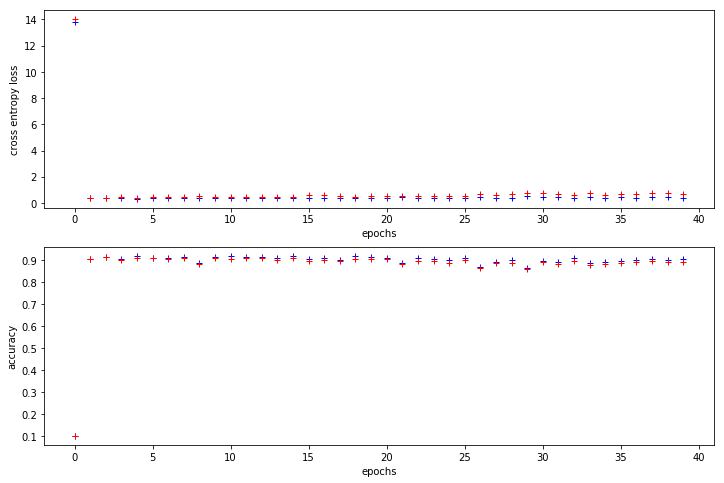

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 128}


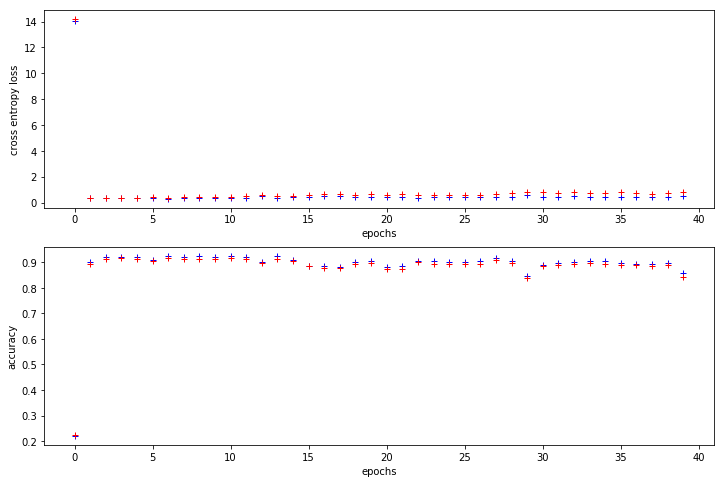

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


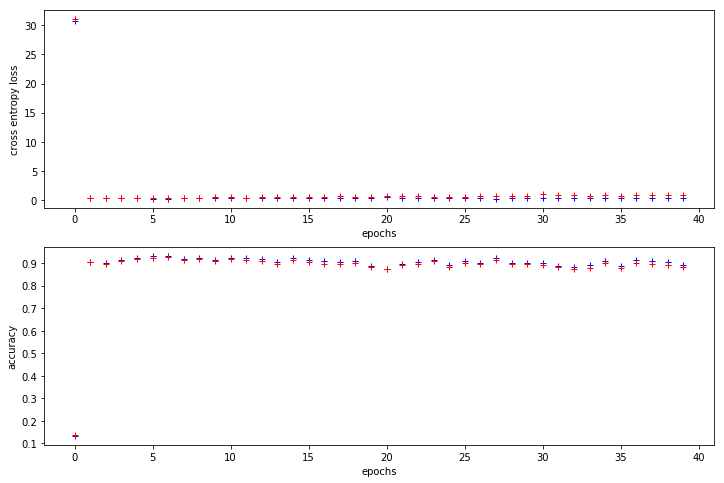

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 32}


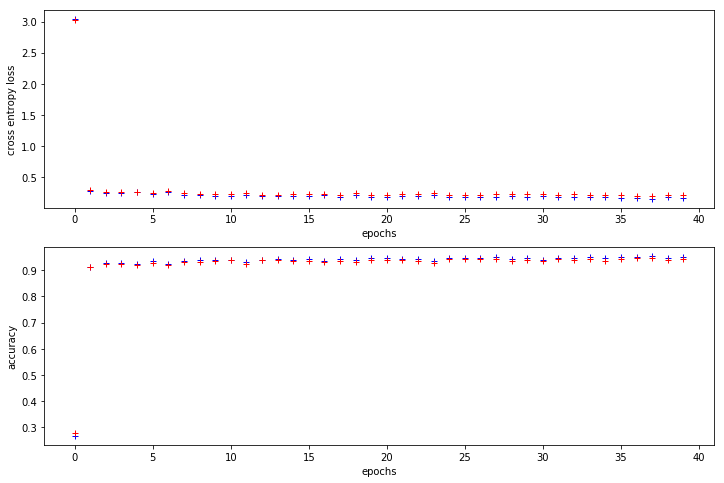

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 64}


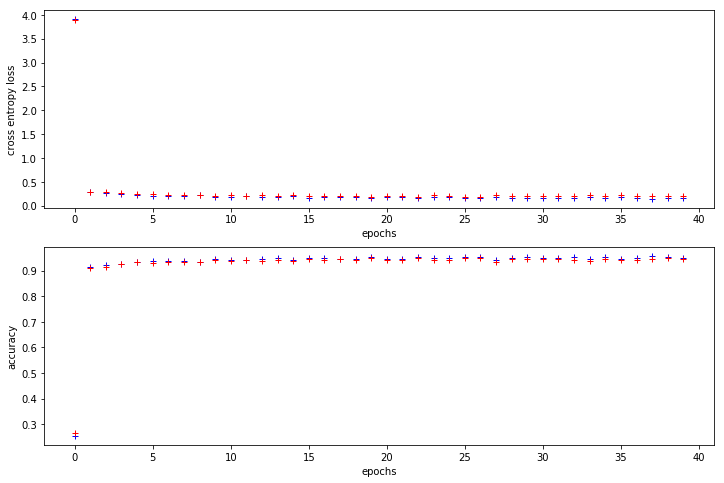

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 128}


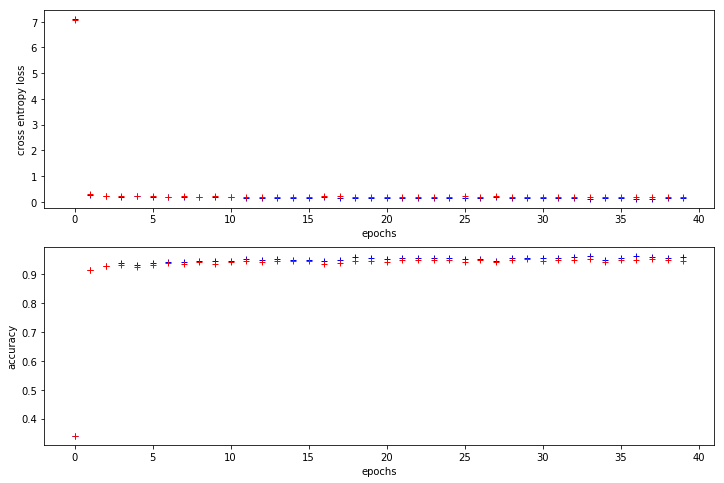

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


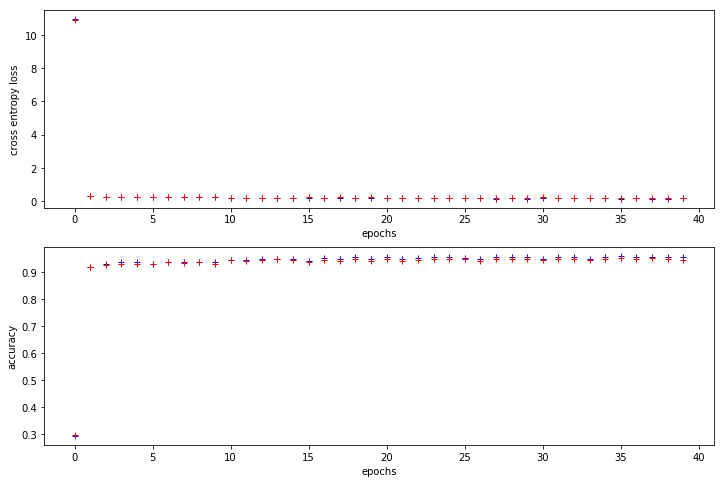

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 32}


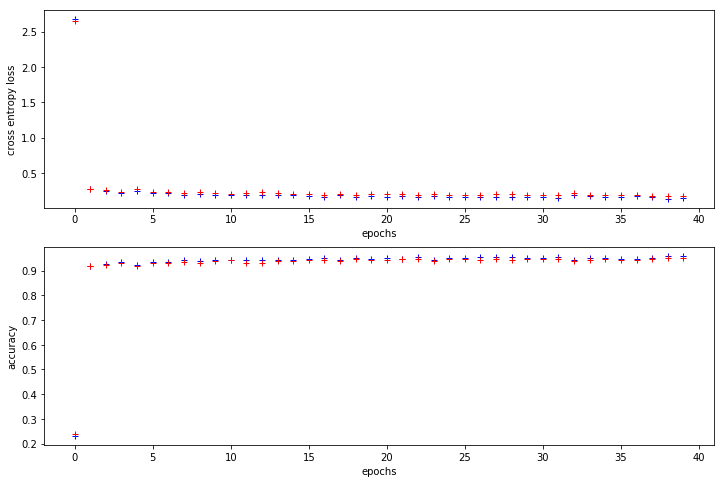

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 64}


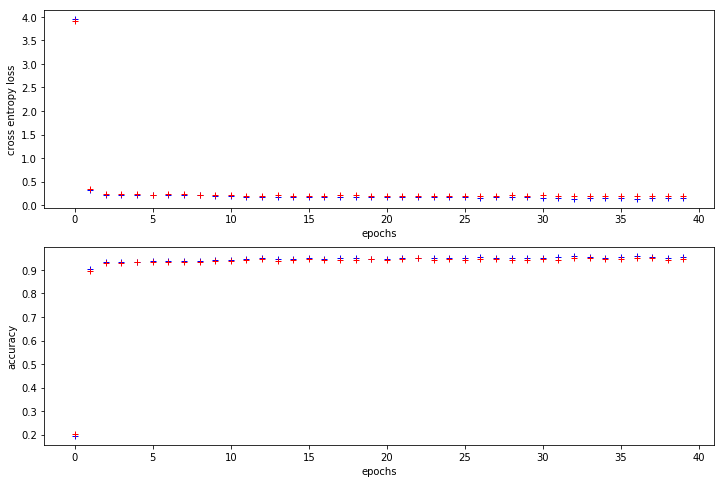

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 128}


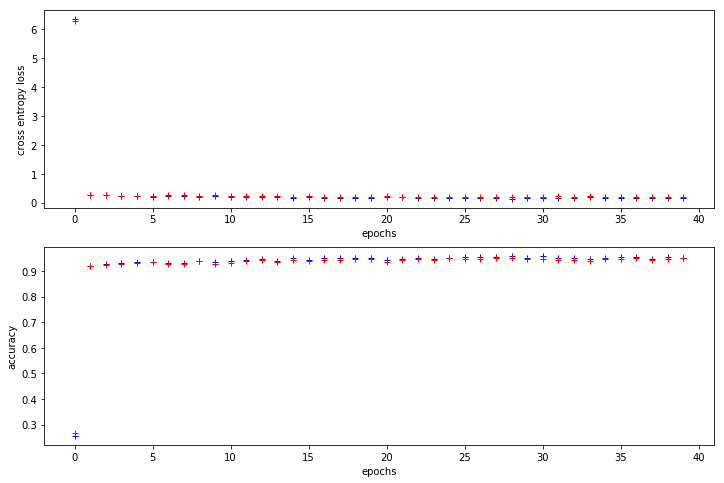

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


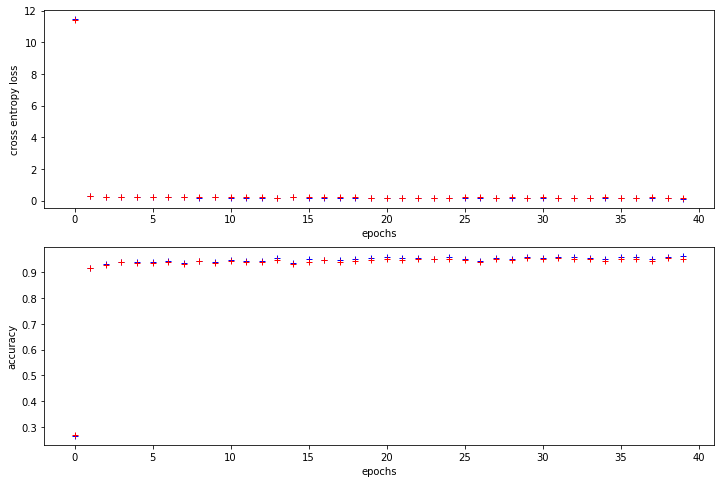

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 32}


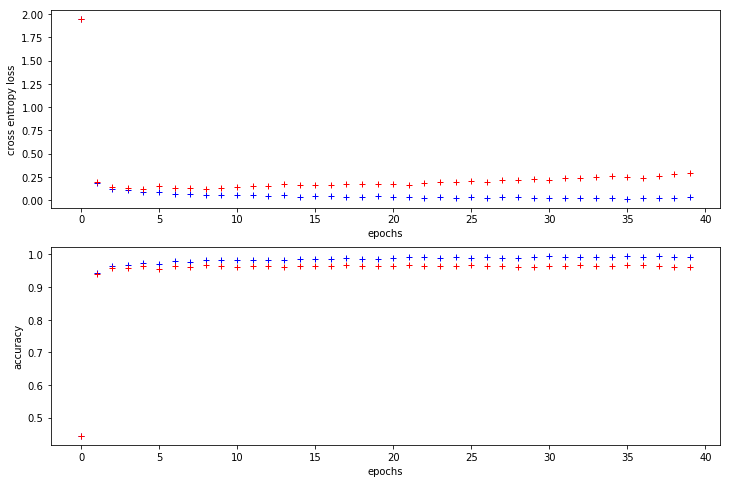

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 64}


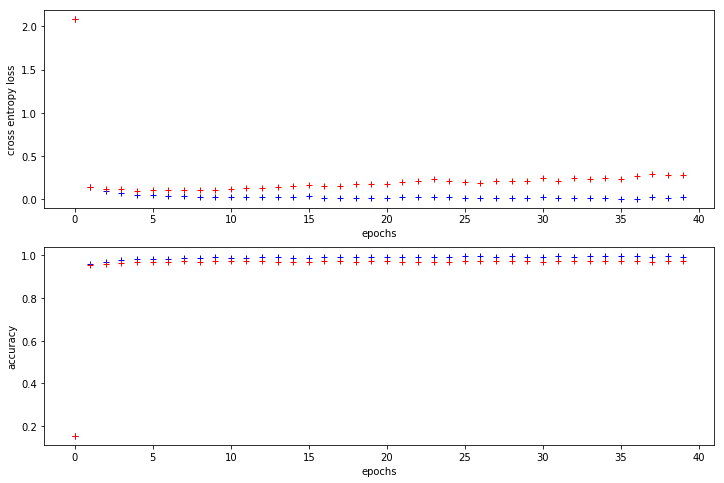

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 128}


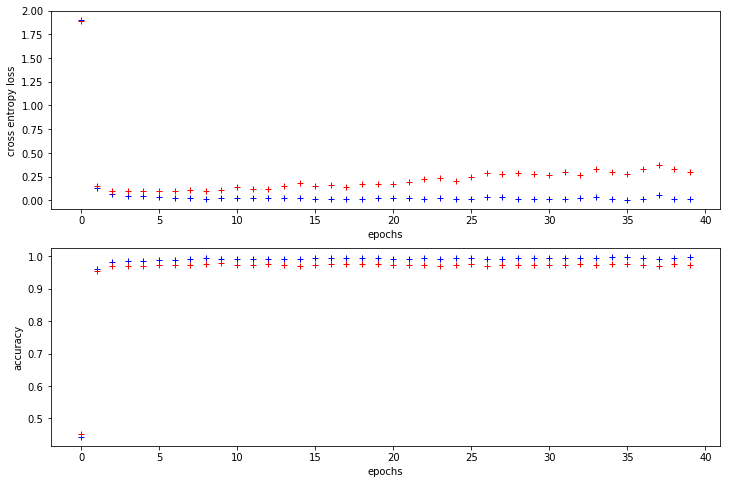

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


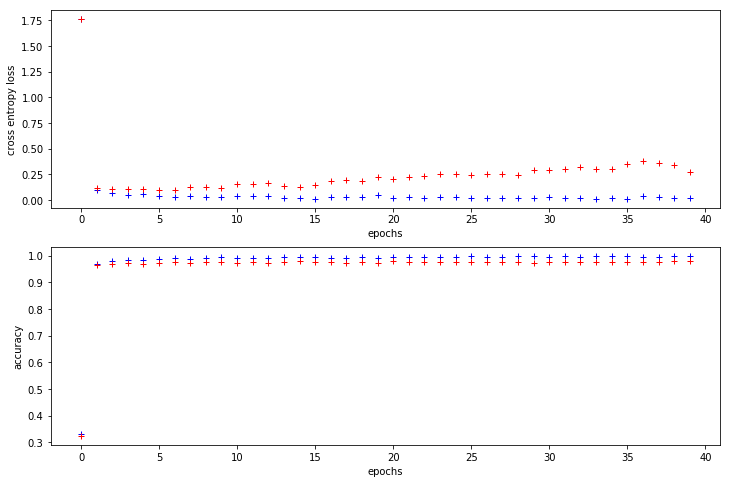

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 32}


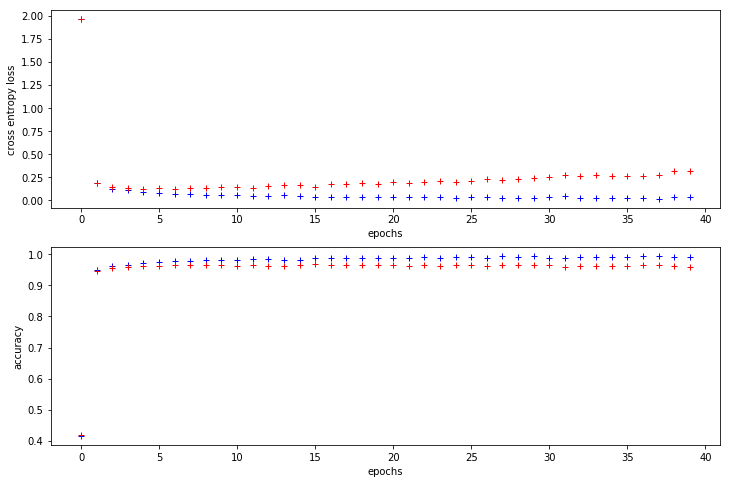

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 64}


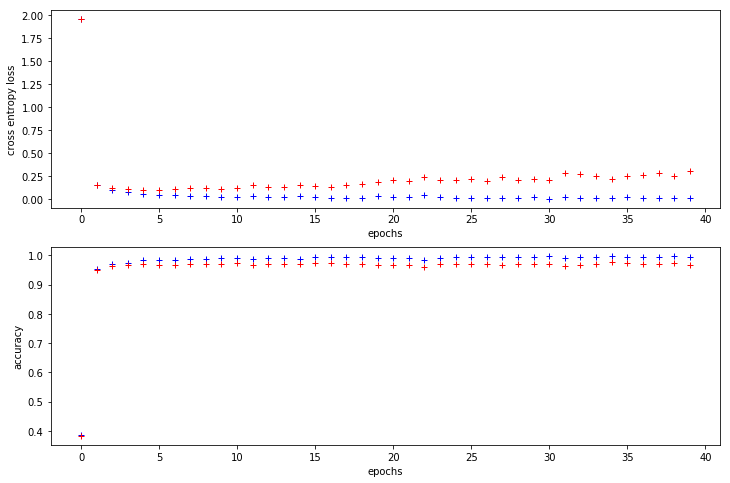

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 128}


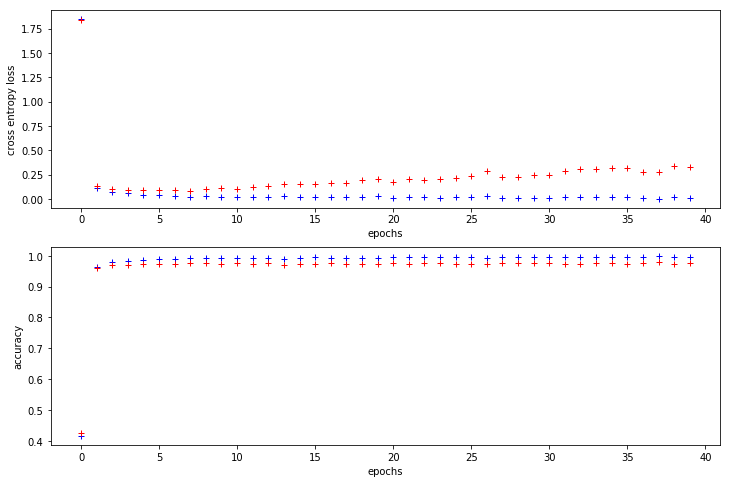

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


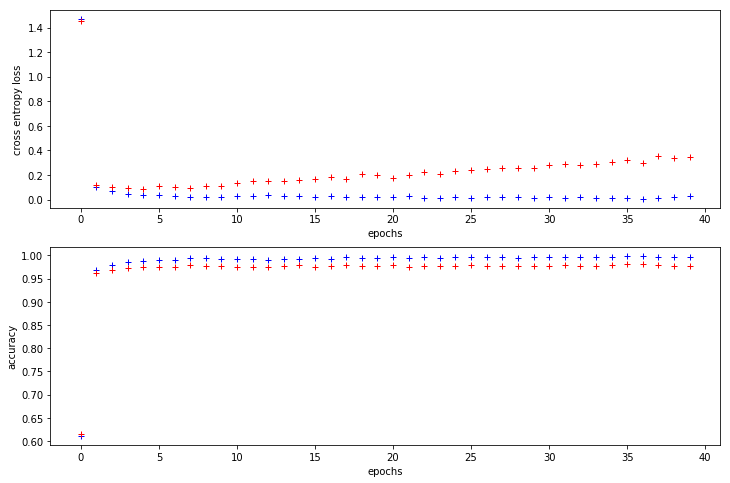

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 32}


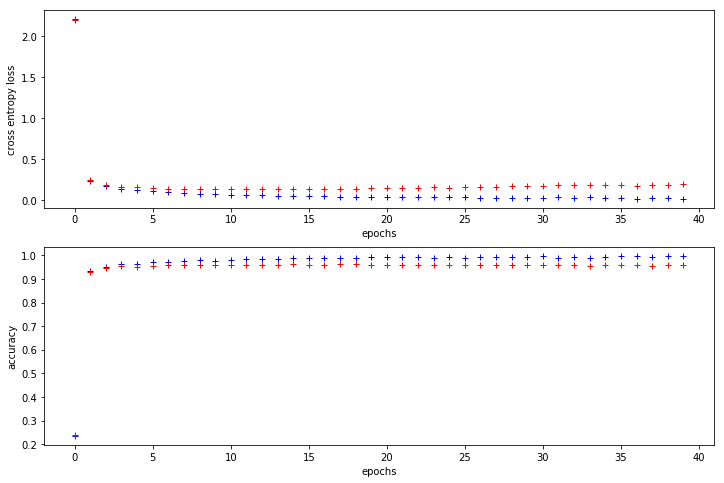

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 64}


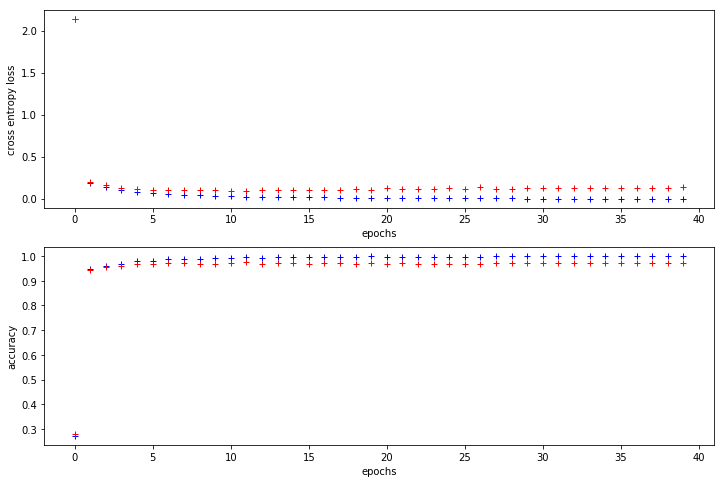

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 128}


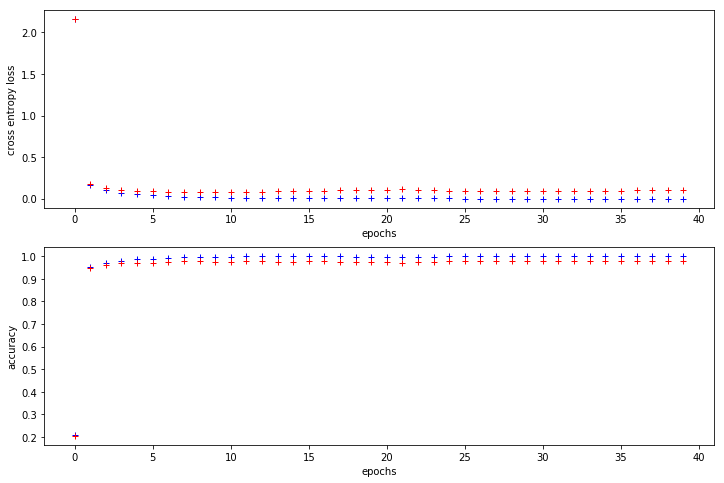

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


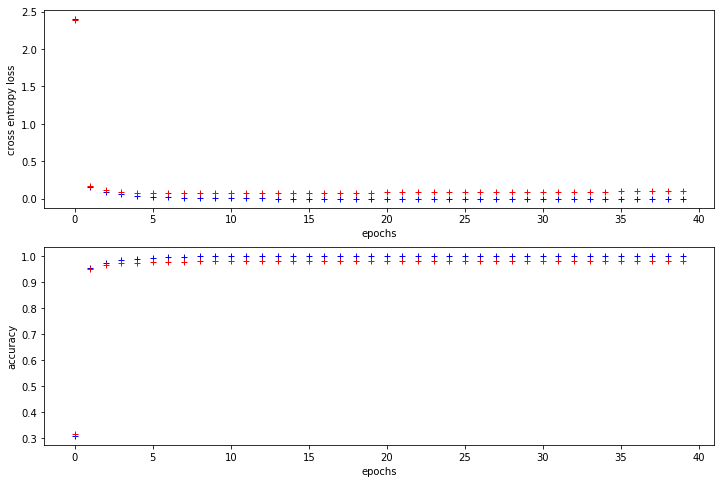

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 32}


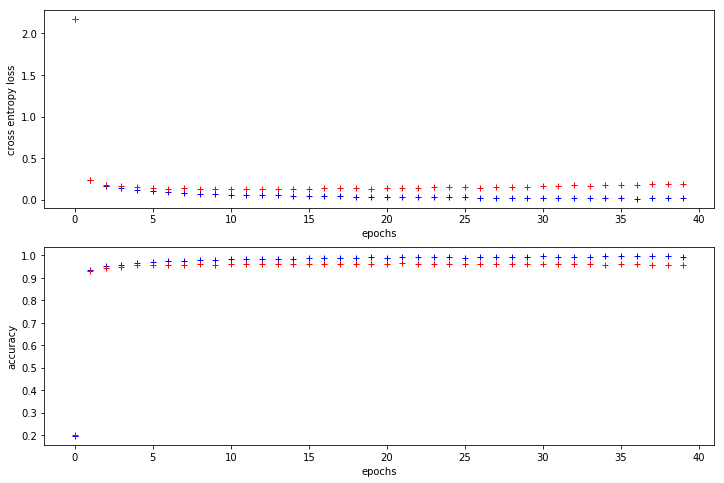

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 64}


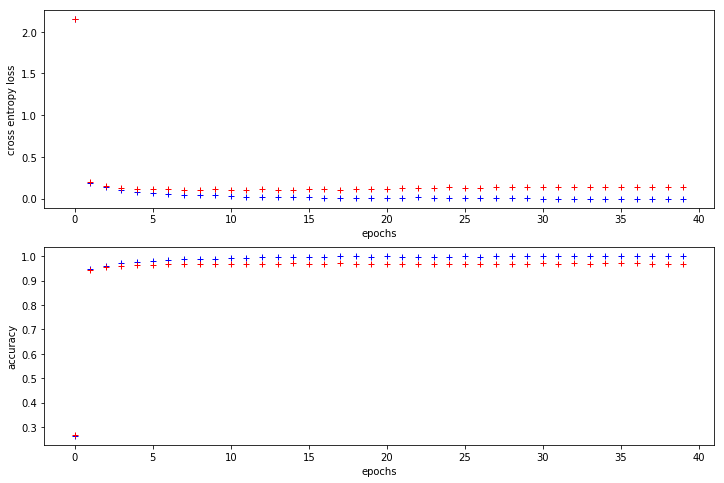

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 128}


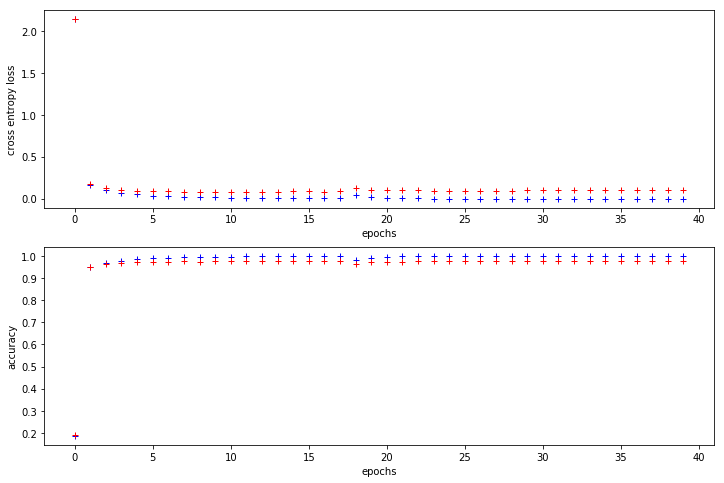

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


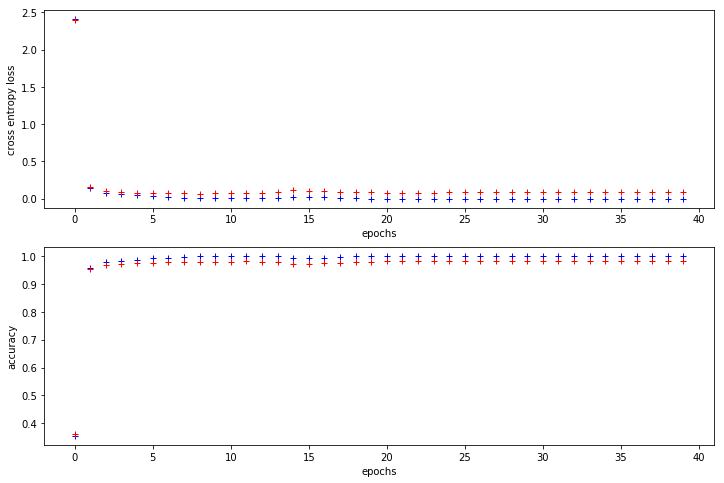

[[{'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}, {'epoch': 39, 'batch': 0, 'train_loss': 0.0012776013, 'train_accuracy': 1.0, 'test_loss': 0.067735404, 'test_accuracy': 0.9826}], [{'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}, {'epoch': 39, 'batch': 0, 'train_loss': 3.092673e-05, 'train_accuracy': 1.0, 'test_loss': 0.0984368, 'test_accuracy': 0.9823}], [{'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0

In [458]:
"""
1 Layer Hidden Network
Architecture: X -> Hidden Layer -> Relu/Sigmoid -> Output Layer -> Argmax -> Y
Grid search over learning rate, optimizers, size of hidden layer, hidden layer activation fn
Goal: find optimal hyper parameters for 1 layer hidden network
Educated Guesses:
- best with accuracy larger network, adam optimizer, relu, relu activation
- some overfitting with gradient descent optimizer
"""

parameter_combinations = []
# reduce optimizer/learning rate combinations based on past observations
optimizer_fns = [
    [tf.train.GradientDescentOptimizer, 0.5], 
    [tf.train.GradientDescentOptimizer, 1], 
    [tf.train.AdamOptimizer, 0.1],
    [tf.train.AdamOptimizer, 0.01]
]

for optimizer_fn in optimizer_fns:
    for hidden_activation_fn in [tf.nn.relu, tf.nn.sigmoid]:
        for hidden_initialization_fn in [relu_initializer, xavier_initializer]:
            for n_hidden_layer in [32, 64, 128, 256]:
                parameters = {
                    'optimizer_fn': optimizer_fn,
                    'hidden_activation_fn': hidden_activation_fn,
                    'hidden_initialization_fn': hidden_initialization_fn,
                    'n_hidden_layer': n_hidden_layer
                }
                parameter_combinations.append(parameters)
                
results = []
for parameters in parameter_combinations:
    print('parameters: ', parameters)
    tf.reset_default_graph()
    tf.set_random_seed(0)
    X = tf.placeholder(tf.float32, shape=[None, n_X])                    
    hidden_layer = nn_layer(X, n_X, parameters['n_hidden_layer'], weight_initializer=parameters['hidden_initialization_fn'], bias_initializer=tf.zeros, activation=parameters['hidden_activation_fn'])['output']
    output_layer = nn_layer(hidden_layer, parameters['n_hidden_layer'], n_Y, weight_initializer=parameters['hidden_initialization_fn'], bias_initializer=tf.zeros, activation=pass_through_activation)['output']
    optimizer = parameters['optimizer_fn'][0](learning_rate=parameters['optimizer_fn'][1])
    summaries = train(output_layer, optimizer, batch_size=256, epochs=40, print_progress=False)['summaries']
    plot_summaries(summaries)
    results.append([parameters, summaries[-1]])

best_results = sorted(results, key=lambda result: result[1]['test_accuracy'], reverse=True)  
print(best_results)
                                                                                                                             

In [494]:
print("best results")
for result in best_results[0:20]:
    template = "test acc: {test_accuracy:5.4f} loss_diff: {loss_diff:4.3f} opt: {optimizer_fn:<25s} learn: {learning_rate:3.2f} size: {n_hidden_layer:3d} act: {activation_fn:<9s} init: {initialization_fn:<20s}"
    print(template.format(test_accuracy=result[1]['test_accuracy'], 
                          optimizer_fn=result[0]['optimizer_fn'][0].__name__, 
                          learning_rate=result[0]['optimizer_fn'][1], 
                          n_hidden_layer=result[0]['n_hidden_layer'], 
                          activation_fn=result[0]['hidden_activation_fn'].__name__, 
                          initialization_fn=result[0]['hidden_initialization_fn'].__name__, 
                          loss_diff=result[1]['test_loss'] - result[1]['train_loss']))
print("worst results")
for result in list(reversed(best_results))[0:20]:
    template = "test acc: {test_accuracy:5.4f} loss_diff: {loss_diff:4.3f} opt: {optimizer_fn:<25s} learn: {learning_rate:3.2f} size: {n_hidden_layer:3d} act: {activation_fn:<9s} init: {initialization_fn:<20s}"
    print(template.format(test_accuracy=result[1]['test_accuracy'], 
                          optimizer_fn=result[0]['optimizer_fn'][0].__name__, 
                          learning_rate=result[0]['optimizer_fn'][1], 
                          n_hidden_layer=result[0]['n_hidden_layer'], 
                          activation_fn=result[0]['hidden_activation_fn'].__name__, 
                          initialization_fn=result[0]['hidden_initialization_fn'].__name__, 
                          loss_diff=result[1]['test_loss'] - result[1]['train_loss']))

best results
test acc: 0.9826 loss_diff: 0.066 opt: GradientDescentOptimizer  learn: 1.00 size: 256 act: relu      init: xavier_initializer  
test acc: 0.9823 loss_diff: 0.098 opt: AdamOptimizer             learn: 0.01 size: 256 act: sigmoid   init: relu_initializer    
test acc: 0.9821 loss_diff: 0.059 opt: GradientDescentOptimizer  learn: 0.50 size: 256 act: relu      init: xavier_initializer  
test acc: 0.9819 loss_diff: 0.089 opt: AdamOptimizer             learn: 0.01 size: 256 act: sigmoid   init: xavier_initializer  
test acc: 0.9818 loss_diff: 0.065 opt: GradientDescentOptimizer  learn: 1.00 size: 256 act: relu      init: relu_initializer    
test acc: 0.9814 loss_diff: 0.059 opt: GradientDescentOptimizer  learn: 0.50 size: 256 act: relu      init: relu_initializer    
test acc: 0.9808 loss_diff: 0.041 opt: GradientDescentOptimizer  learn: 1.00 size: 256 act: sigmoid   init: relu_initializer    
test acc: 0.9805 loss_diff: 0.066 opt: GradientDescentOptimizer  learn: 0.50 size: 1

# Notes using 1 hidden and 1 output layer 
- suprised to see gradient descent optimizer topping results, though not significantly
- adam opt seemed to overfit more often than grad desc.  I suspect learning rate choices for adam still need more tuning
- comparing test acc at fixed epochs probably don't give fair comparisons, some overfit at later epochs
- sigmoid vs relu, and xavier vs relu init, didn't see any meaningful pattern, i suspect it'll get more apparent at deeper networks
- adam was happier with 0.01 learning rate, worst ones were 0.1 learning rate. should grid search around 0.01
- unsuprisingly, larger networks performed better, i'll stick with 128-256 range, with potential for overfitting

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


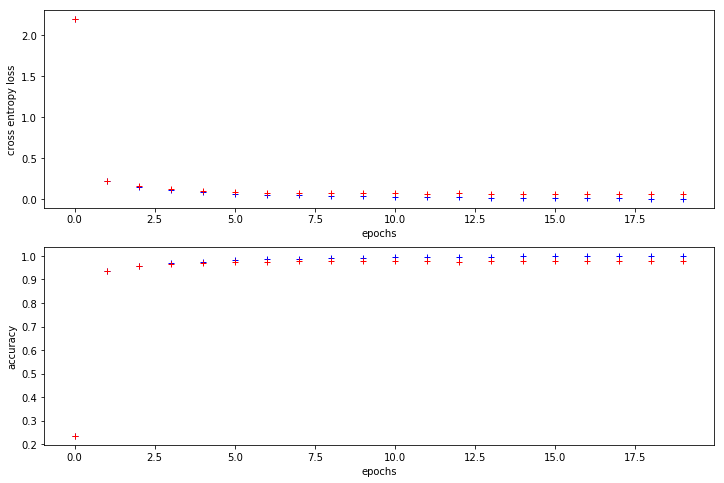

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


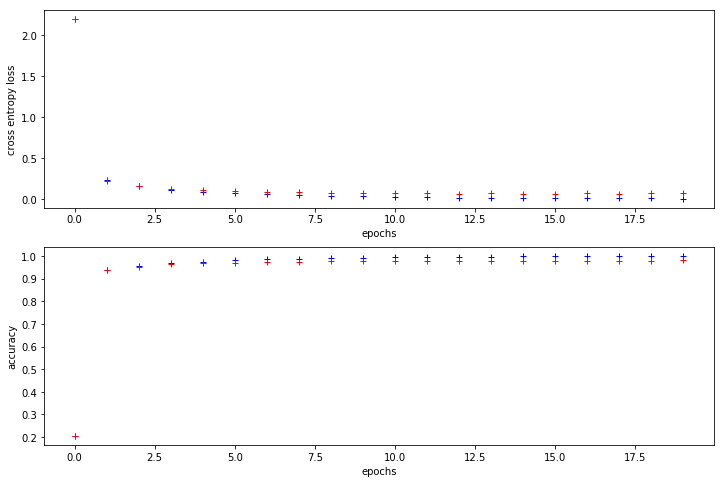

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


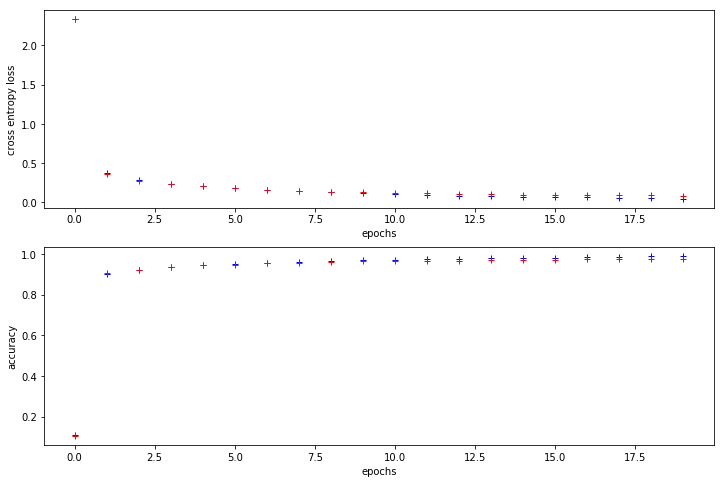

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


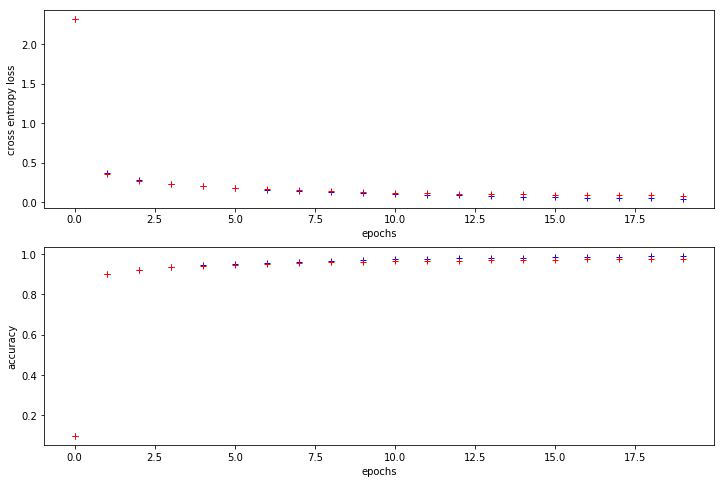

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


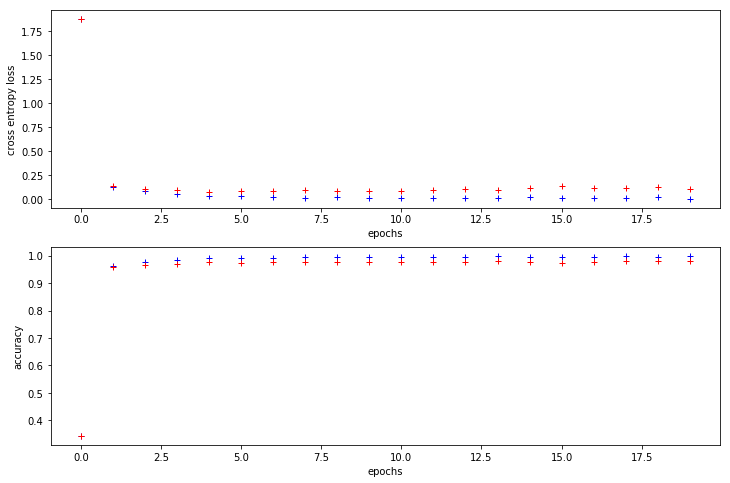

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


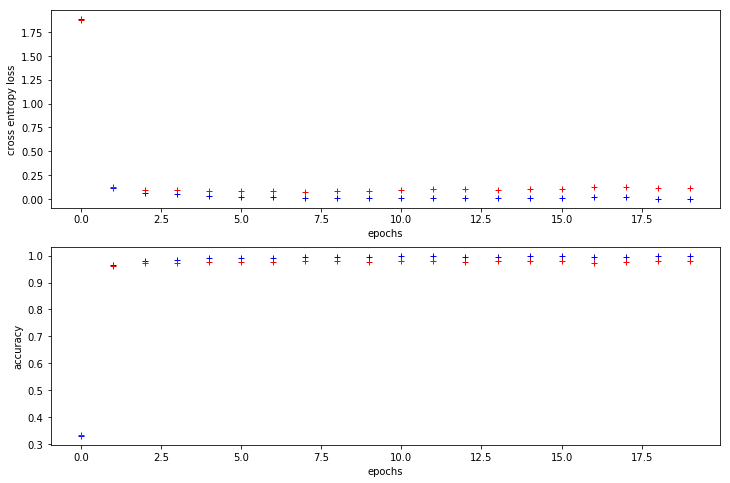

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


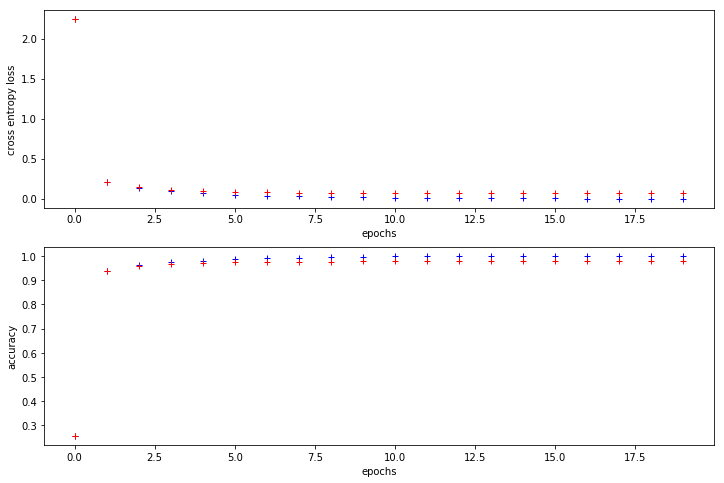

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


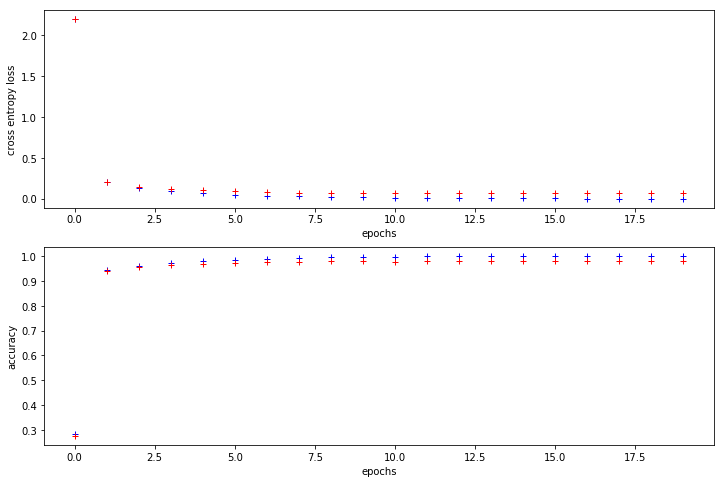

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


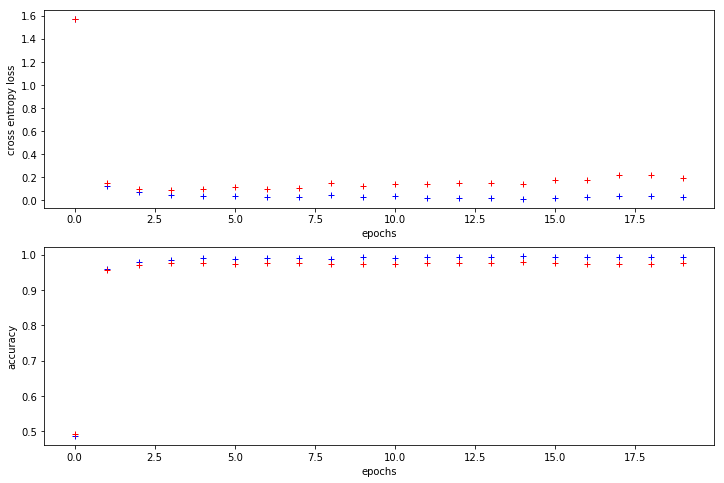

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


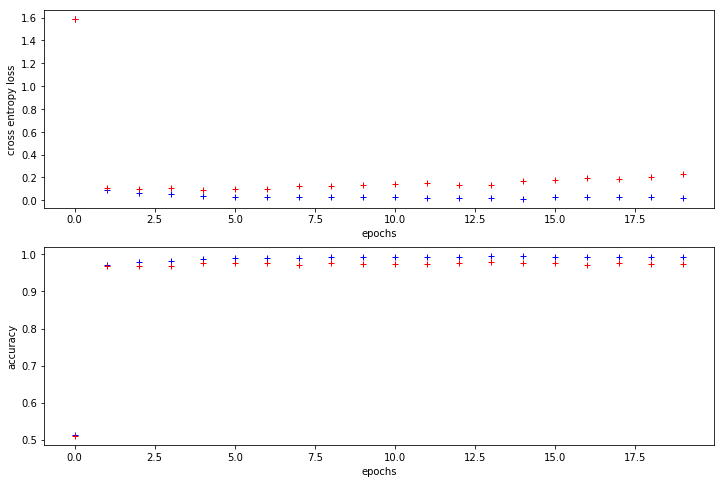

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


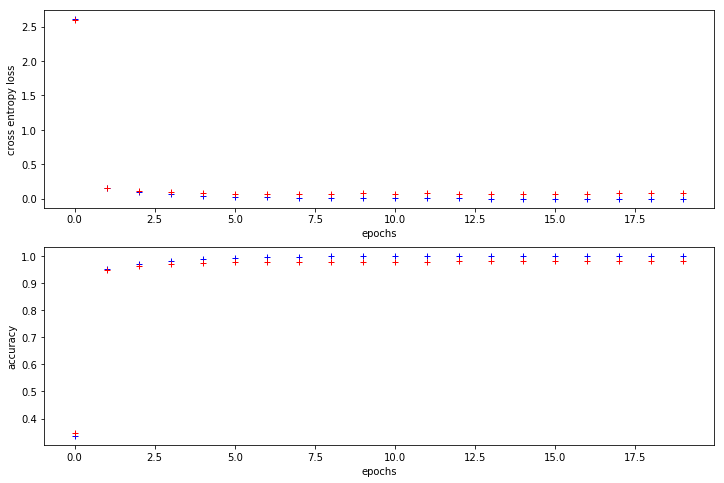

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.01], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


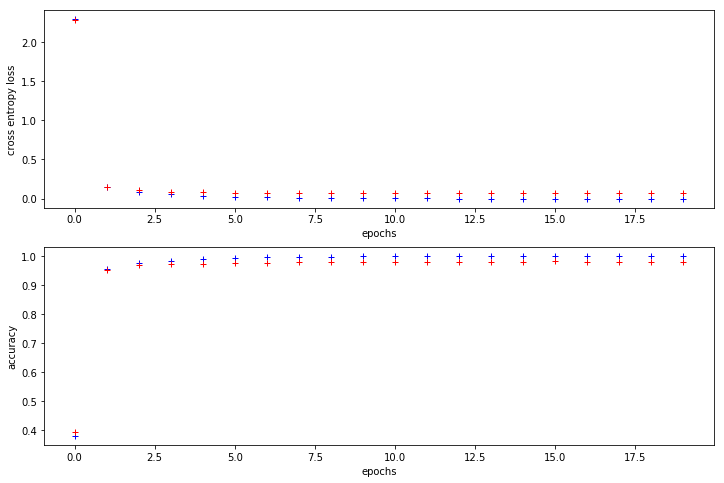

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.05], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


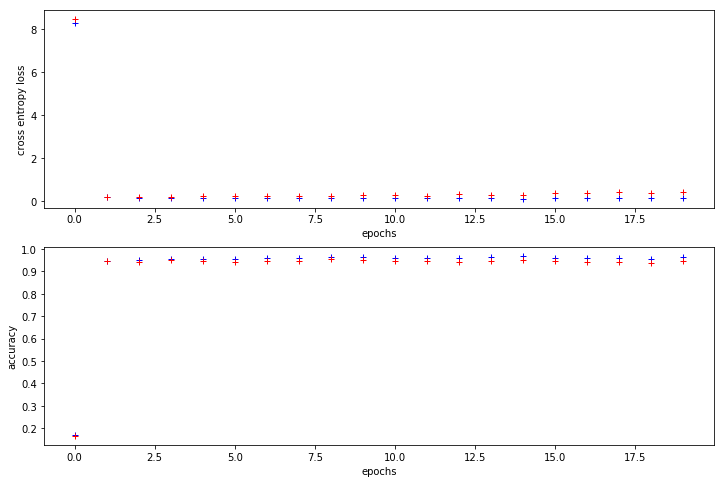

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.05], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


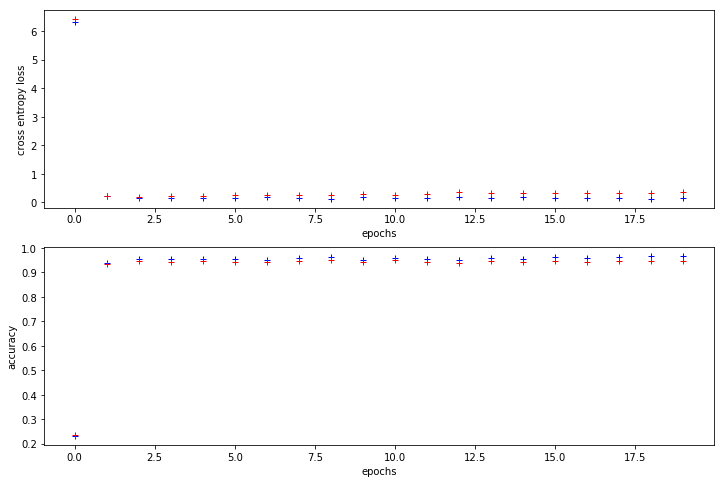

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.05], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer': 256}


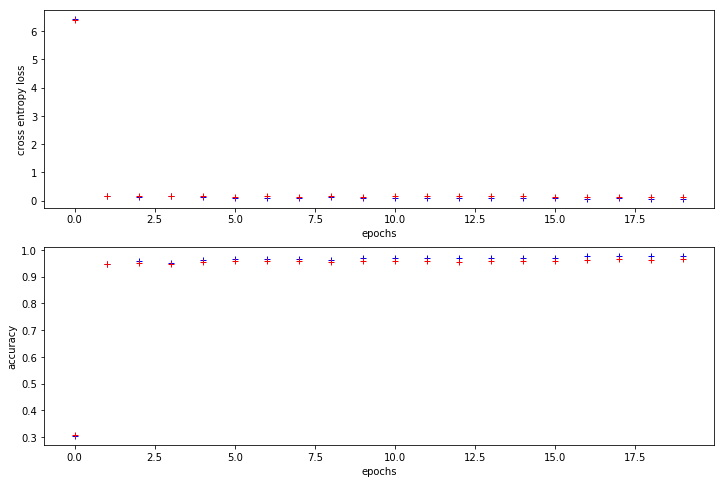

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.05], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer': 256}


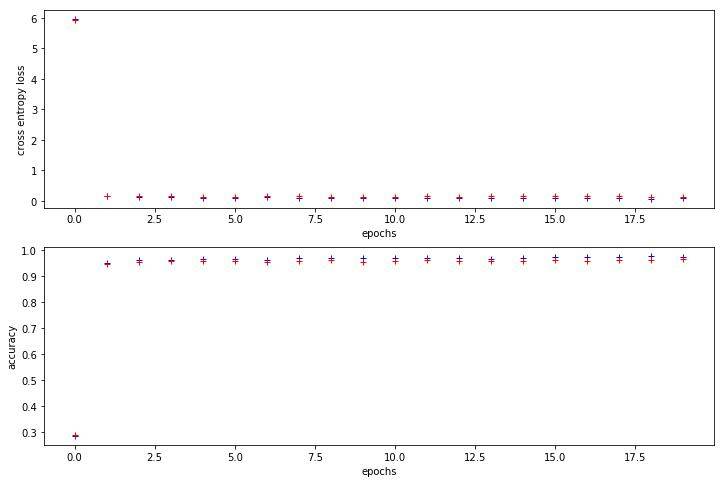

In [499]:
"""
1 Layer Hidden Network
Architecture: X -> Hidden Layer -> Relu/Sigmoid -> Output Layer -> Argmax -> Y
Grid search over learning rate, size of hidden layer, hidden layer activation fn
Goal: grid search over parameters for adam optimizer
Educated Guesses:
- best with accuracy larger network, adam optimizer, relu, relu activation
- some overfitting with gradient descent optimizer
"""

parameter_combinations = []
optimizer_fns = [
    [tf.train.AdamOptimizer, 0.001],
    [tf.train.AdamOptimizer, 0.005],
    [tf.train.AdamOptimizer, 0.01],
    [tf.train.AdamOptimizer, 0.05]
]

for optimizer_fn in optimizer_fns:
    for hidden_activation_fn in [tf.nn.relu, tf.nn.sigmoid]:
        for hidden_initialization_fn in [relu_initializer, xavier_initializer]:
            for n_hidden_layer in [256]:
                parameters = {
                    'optimizer_fn': optimizer_fn,
                    'hidden_activation_fn': hidden_activation_fn,
                    'hidden_initialization_fn': hidden_initialization_fn,
                    'n_hidden_layer': n_hidden_layer
                }
                parameter_combinations.append(parameters)
                
results = []
for parameters in parameter_combinations:
    print('parameters: ', parameters)
    tf.reset_default_graph()
    tf.set_random_seed(0)
    X = tf.placeholder(tf.float32, shape=[None, n_X])                    
    hidden_layer = nn_layer(X, n_X, parameters['n_hidden_layer'], weight_initializer=parameters['hidden_initialization_fn'], bias_initializer=tf.zeros, activation=parameters['hidden_activation_fn'])['output']
    output_layer = nn_layer(hidden_layer, parameters['n_hidden_layer'], n_Y, weight_initializer=parameters['hidden_initialization_fn'], bias_initializer=tf.zeros, activation=pass_through_activation)['output']
    optimizer = parameters['optimizer_fn'][0](learning_rate=parameters['optimizer_fn'][1])
    summaries = train(output_layer, optimizer, batch_size=256, epochs=20, print_progress=False)['summaries']
    plot_summaries(summaries)
    results.append([parameters, summaries])


                                                                                                                             

In [510]:
# compare of last 5 epochs
for epoch in range(10,20,1):
    print('epoch: ', epoch)
    best_results = sorted(results, key=lambda result: result[1][epoch]['test_accuracy'], reverse=True)  
    print("best results")
    for result in best_results:
        template = "test acc: {test_accuracy:5.4f} loss_diff: {loss_diff:4.3f} opt: {optimizer_fn:<25s} learn: {learning_rate:3.3f} size: {n_hidden_layer:3d} act: {activation_fn:<9s} init: {initialization_fn:<20s}"
        print(template.format(test_accuracy=result[1][epoch]['test_accuracy'], 
                              optimizer_fn=result[0]['optimizer_fn'][0].__name__, 
                              learning_rate=result[0]['optimizer_fn'][1], 
                              n_hidden_layer=result[0]['n_hidden_layer'], 
                              activation_fn=result[0]['hidden_activation_fn'].__name__, 
                              initialization_fn=result[0]['hidden_initialization_fn'].__name__, 
                              loss_diff=result[1][epoch]['test_loss'] - result[1][epoch]['train_loss']))


epoch:  10
best results
test acc: 0.9798 loss_diff: 0.069 opt: AdamOptimizer             learn: 0.010 size: 256 act: sigmoid   init: xavier_initializer  
test acc: 0.9793 loss_diff: 0.057 opt: AdamOptimizer             learn: 0.005 size: 256 act: sigmoid   init: relu_initializer    
test acc: 0.9790 loss_diff: 0.085 opt: AdamOptimizer             learn: 0.005 size: 256 act: relu      init: xavier_initializer  
test acc: 0.9785 loss_diff: 0.077 opt: AdamOptimizer             learn: 0.005 size: 256 act: relu      init: relu_initializer    
test acc: 0.9779 loss_diff: 0.068 opt: AdamOptimizer             learn: 0.010 size: 256 act: sigmoid   init: relu_initializer    
test acc: 0.9778 loss_diff: 0.044 opt: AdamOptimizer             learn: 0.001 size: 256 act: relu      init: relu_initializer    
test acc: 0.9776 loss_diff: 0.059 opt: AdamOptimizer             learn: 0.005 size: 256 act: sigmoid   init: xavier_initializer  
test acc: 0.9772 loss_diff: 0.045 opt: AdamOptimizer             l

# observations
- sigmoid activations inches out relu in this shallow but wide network
- ideal learning rate for adam range seems to be .005 - 0.010 for this network
- no significant accuracy differences between relu/xavier init

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


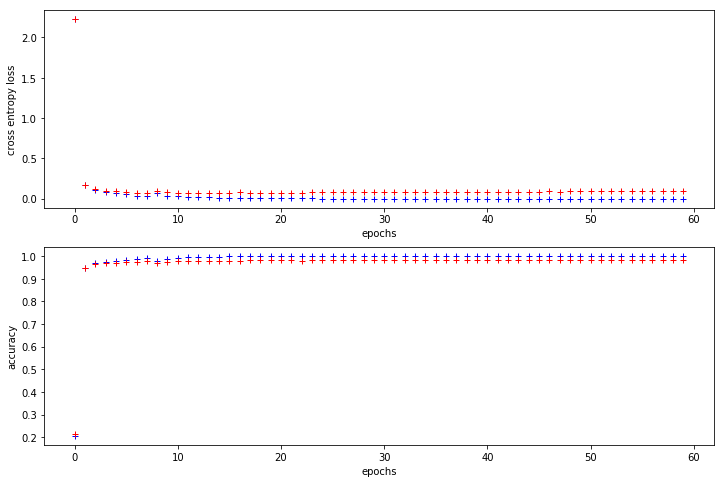

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


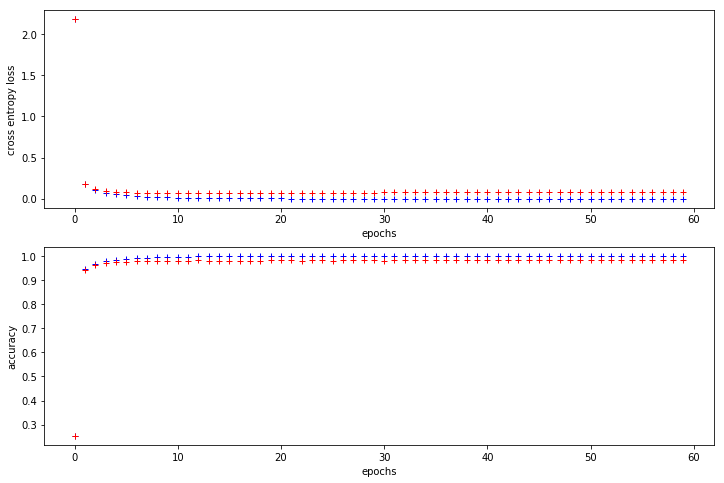

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


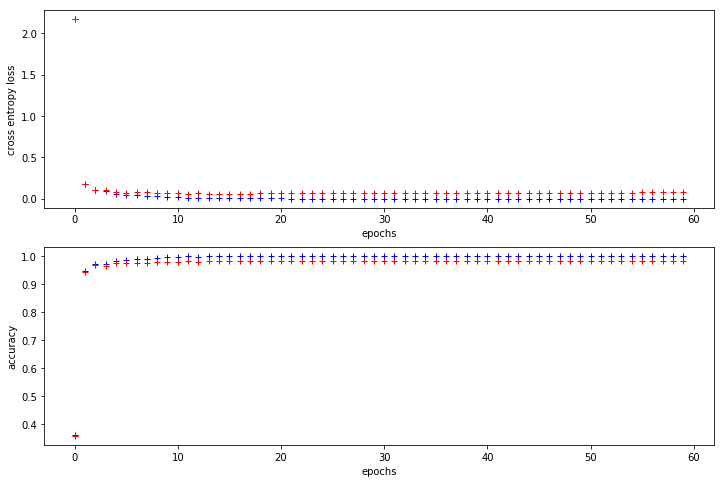

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


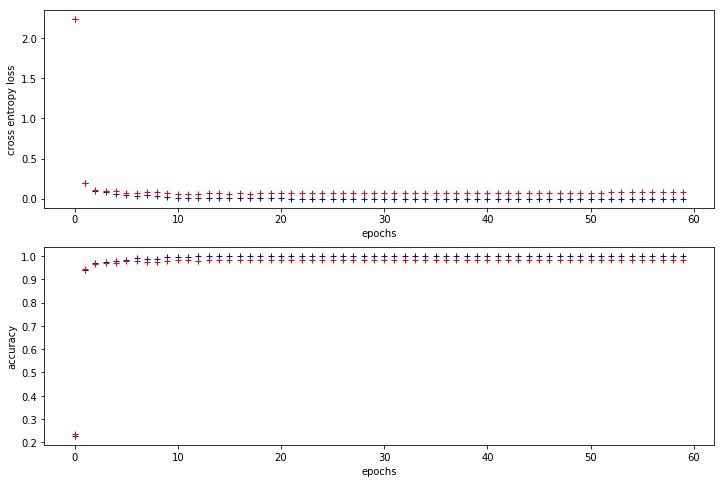

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


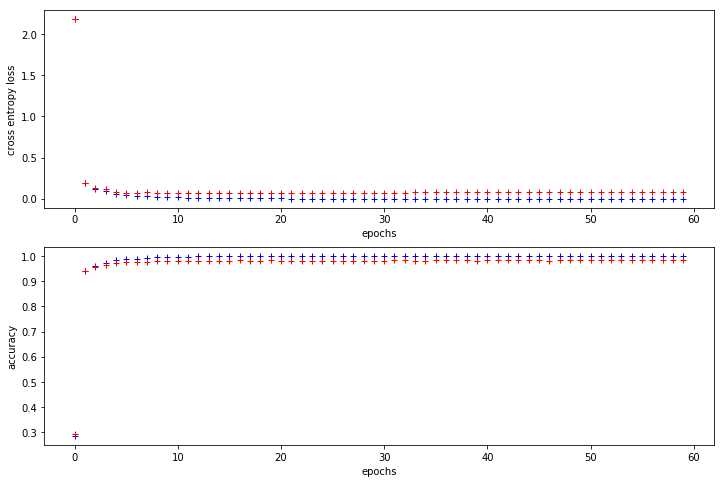

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


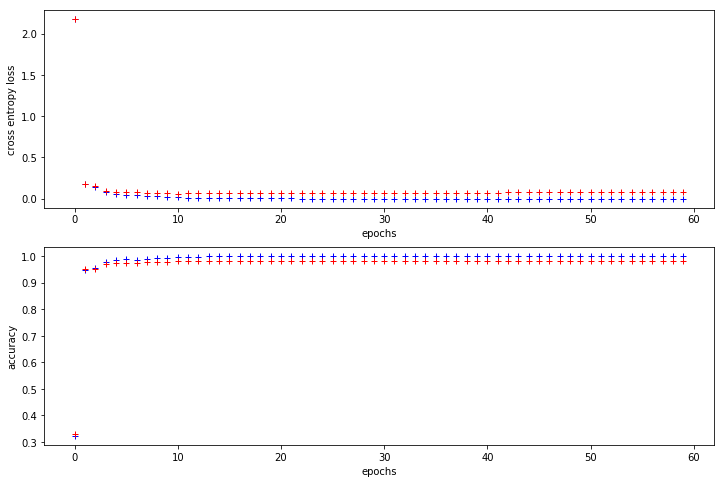

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


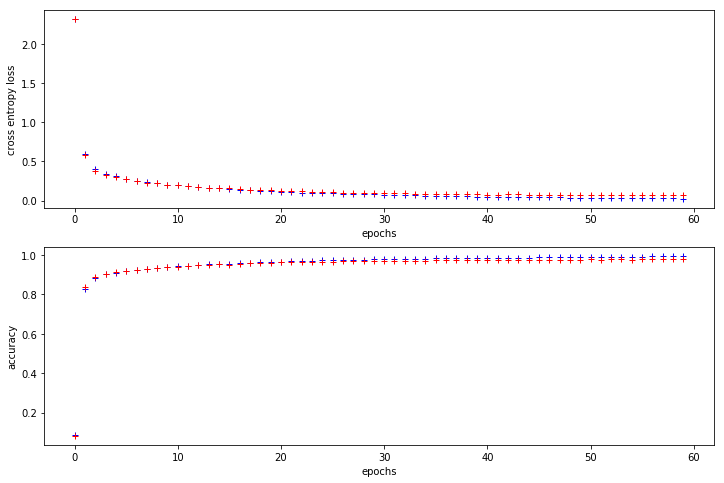

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


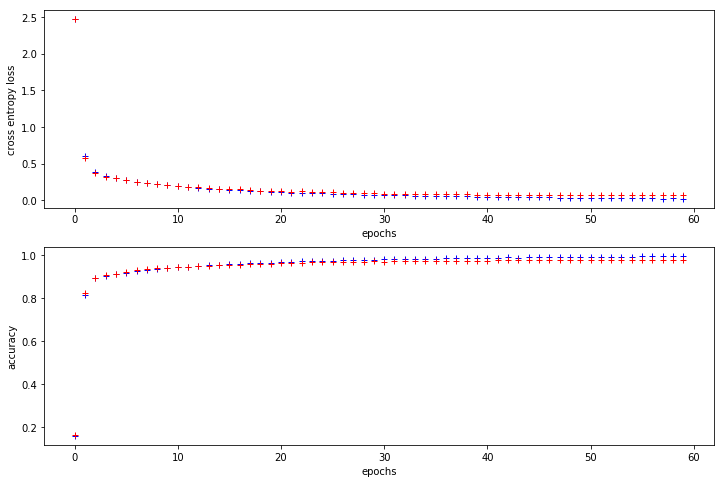

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


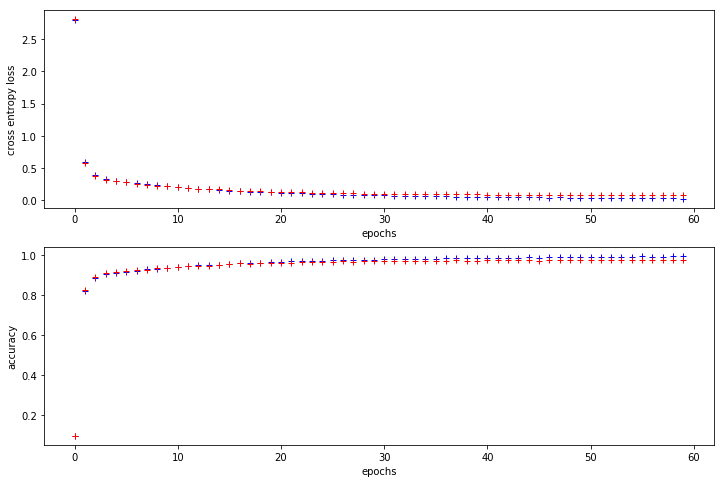

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


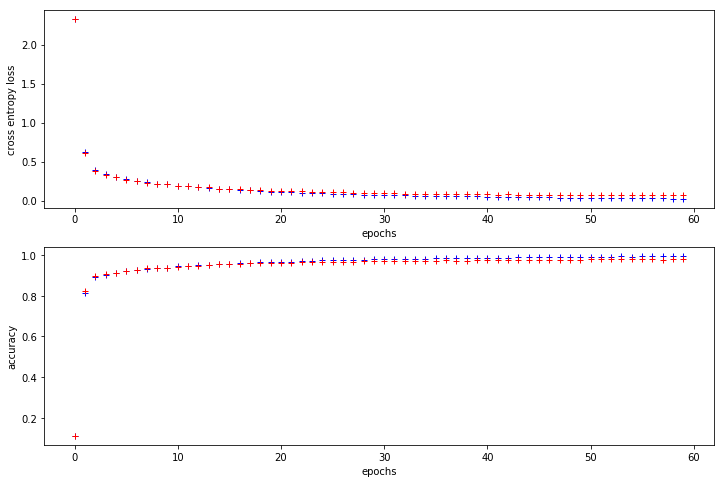

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


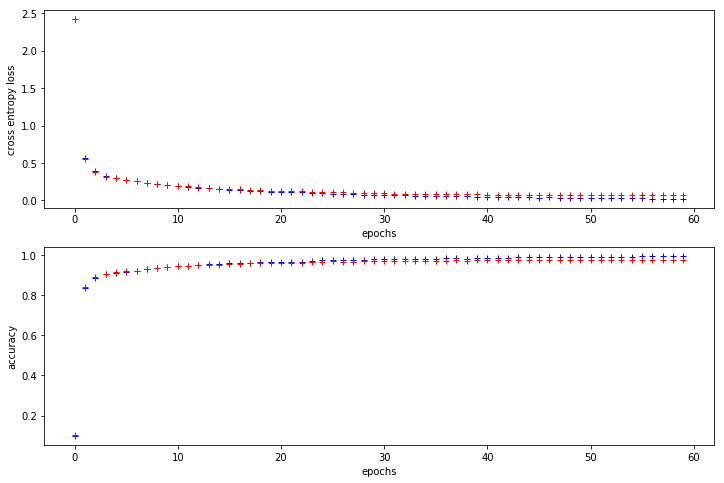

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.5], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


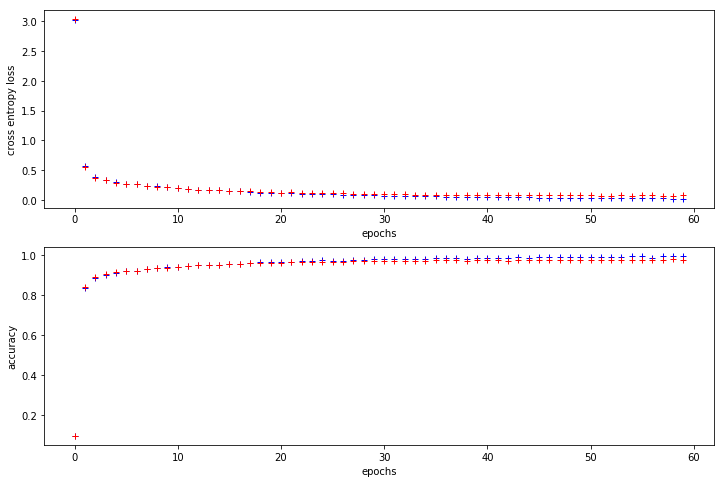

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


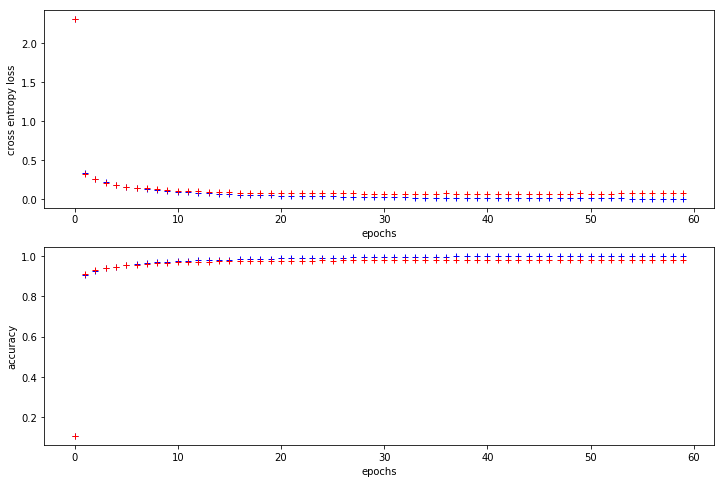

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


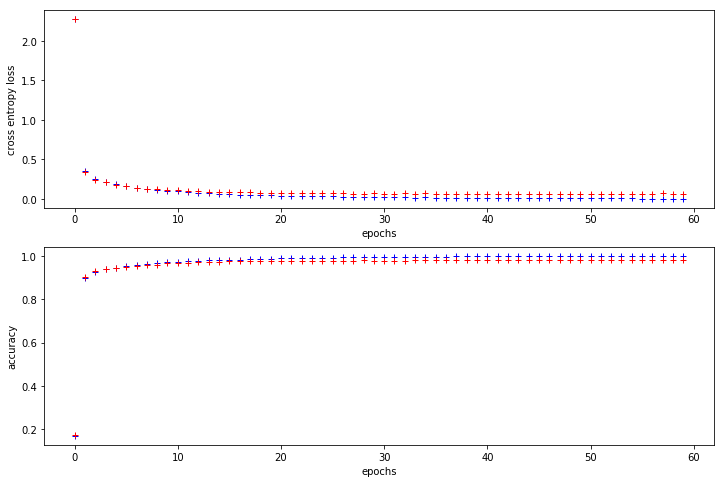

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


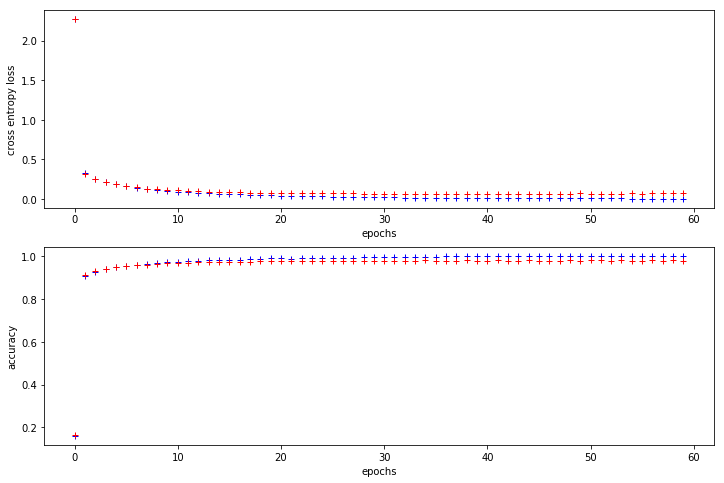

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


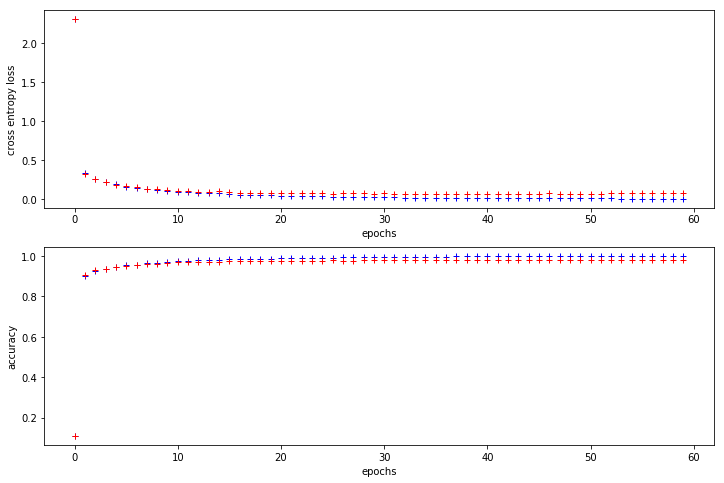

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


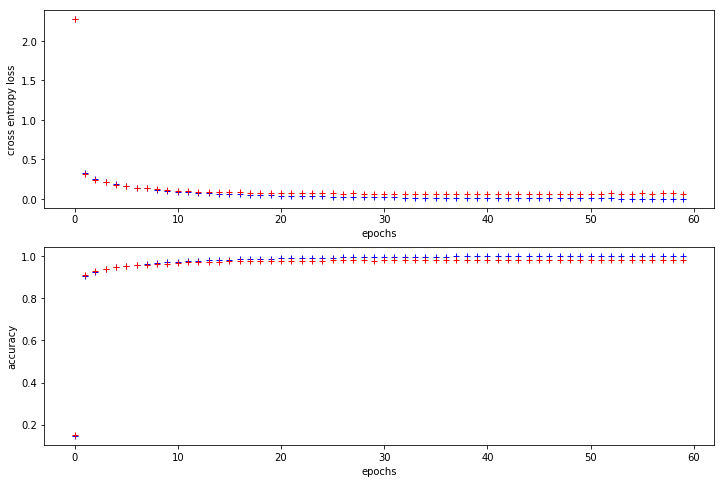

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


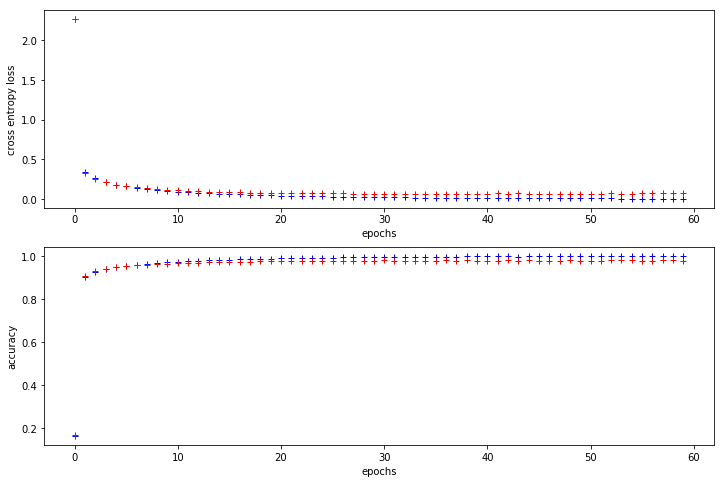

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


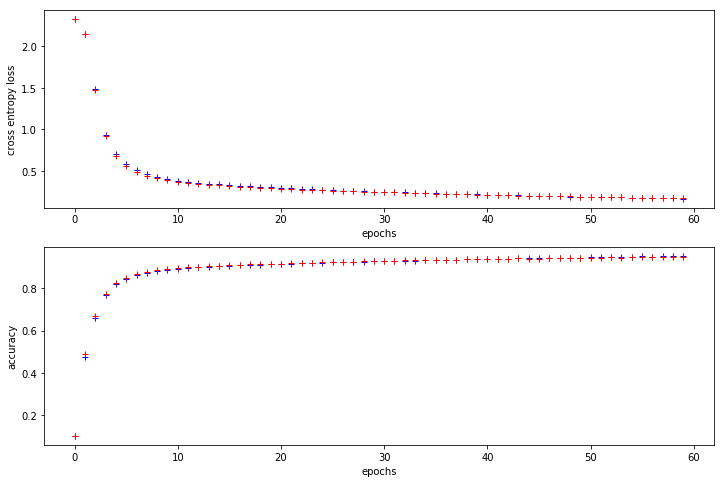

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


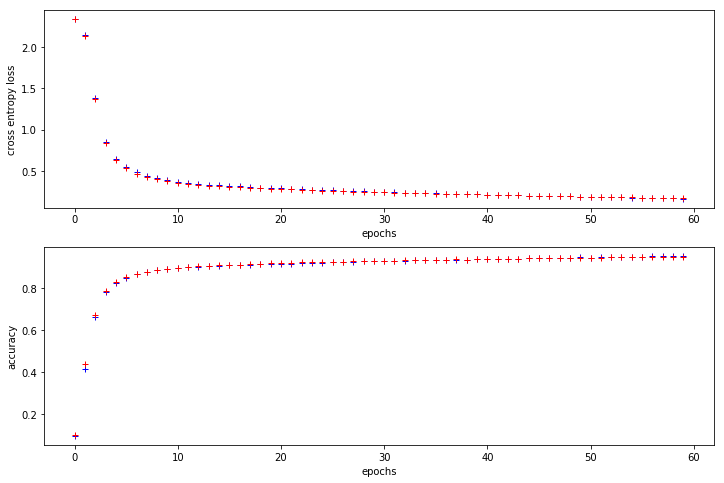

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


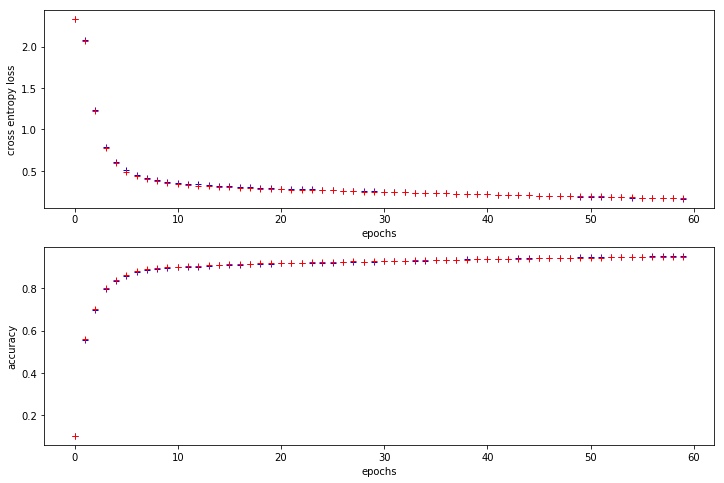

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


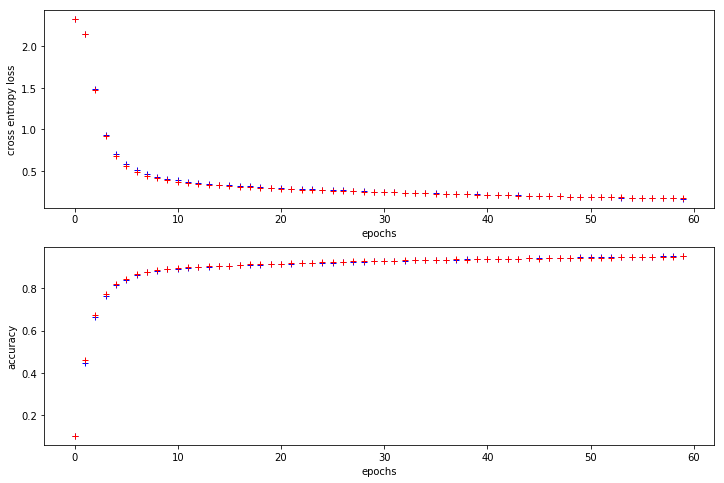

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


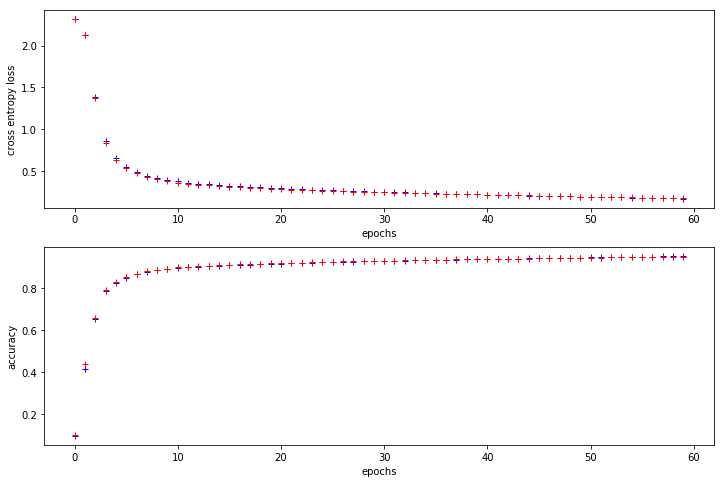

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 0.1], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


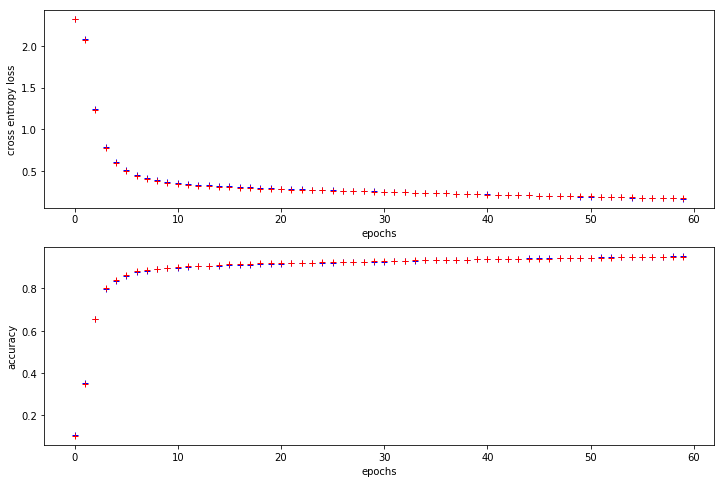

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


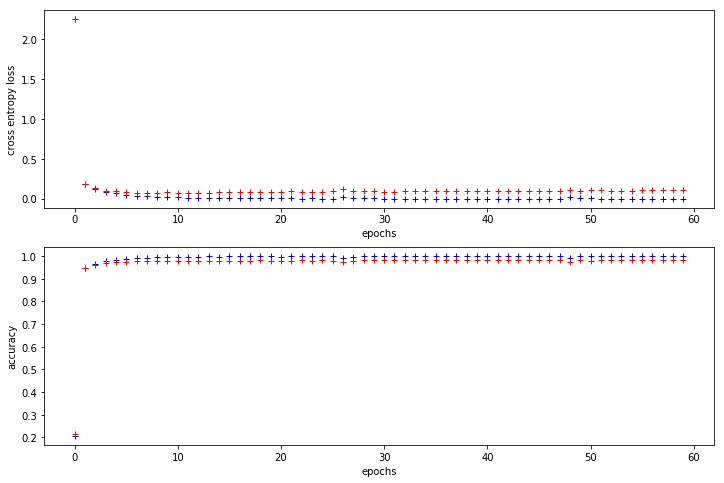

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


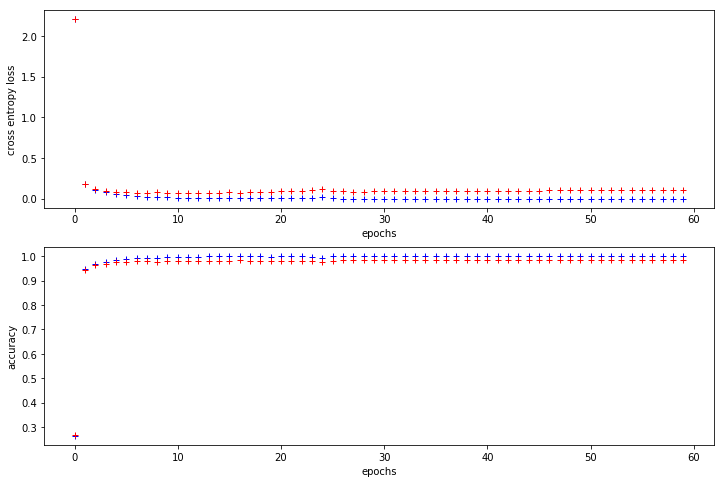

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


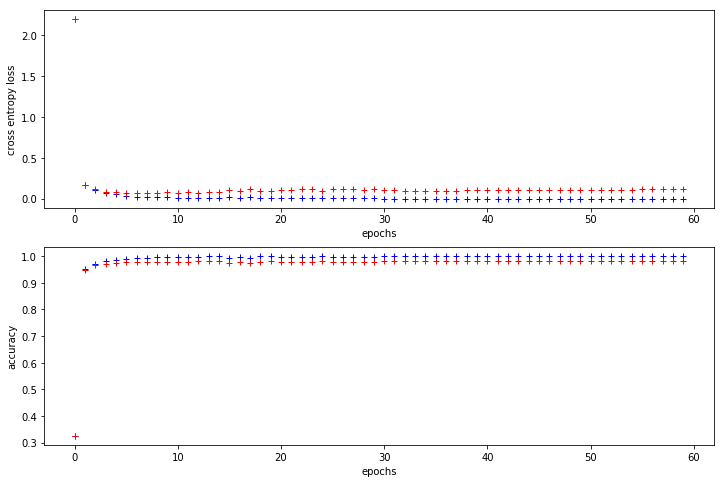

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


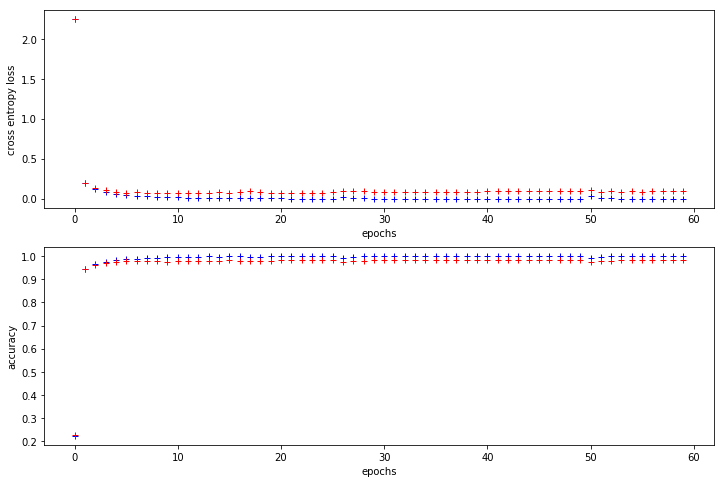

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


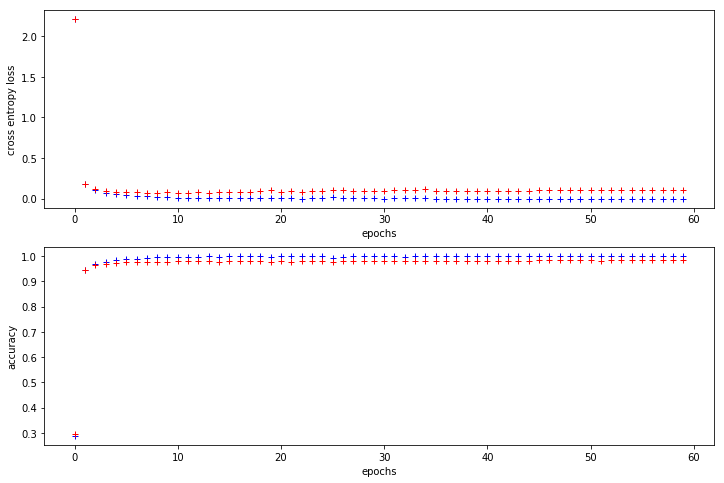

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


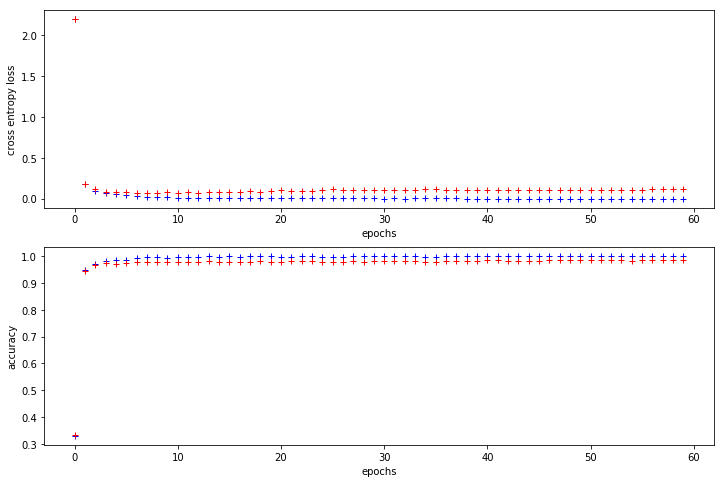

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


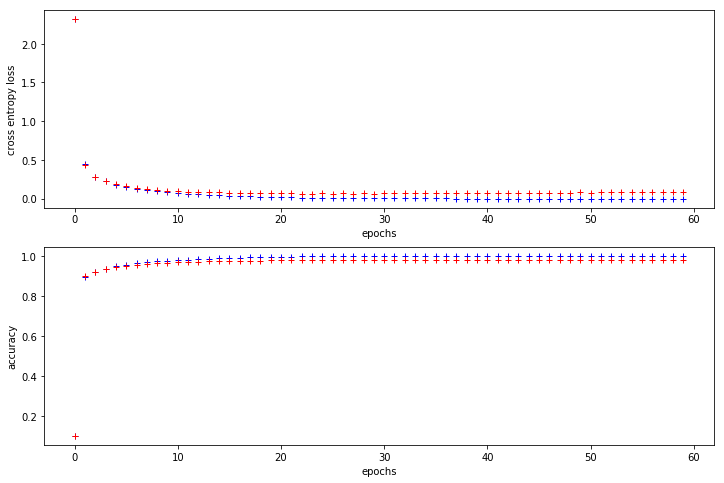

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


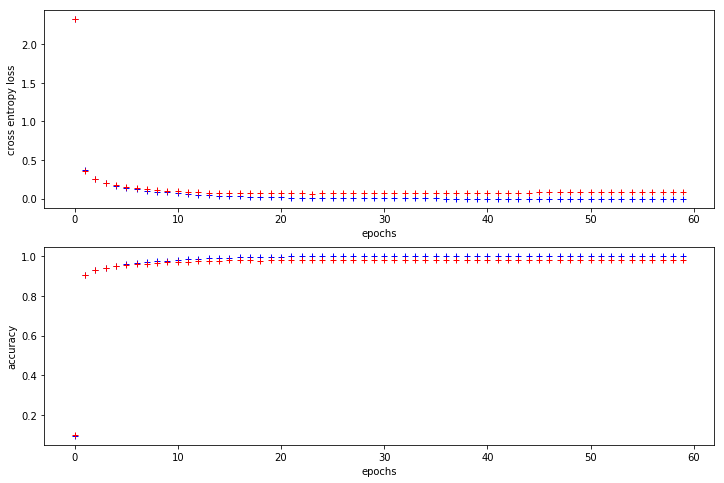

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


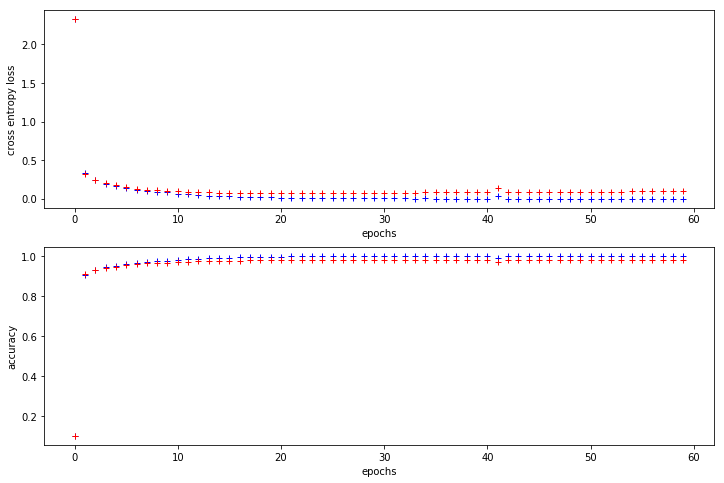

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


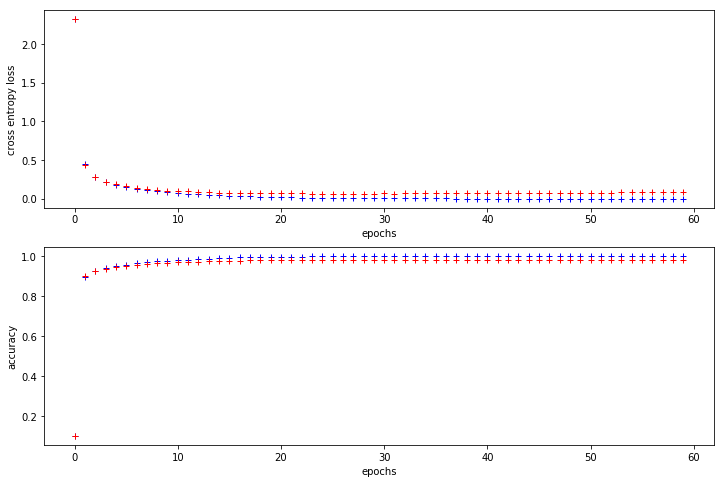

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


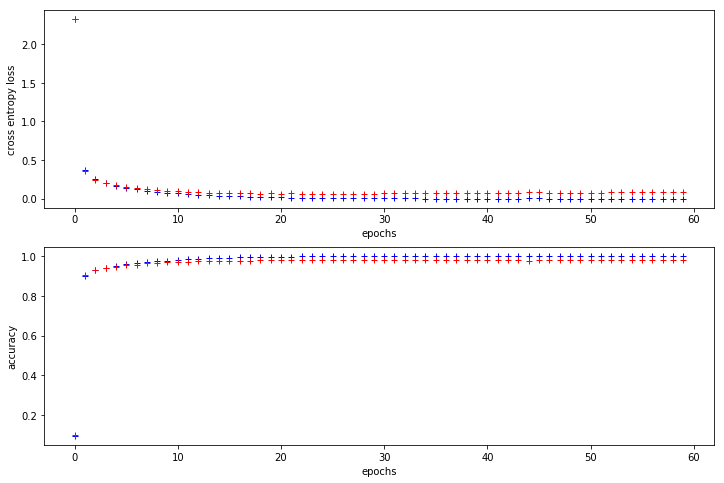

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.001], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


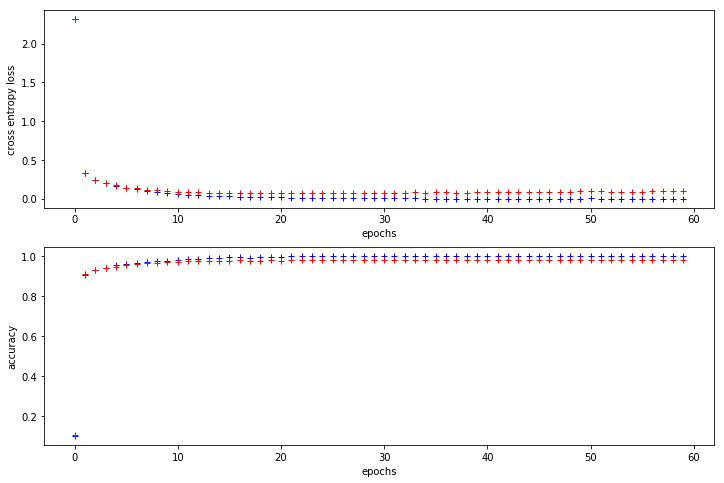

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


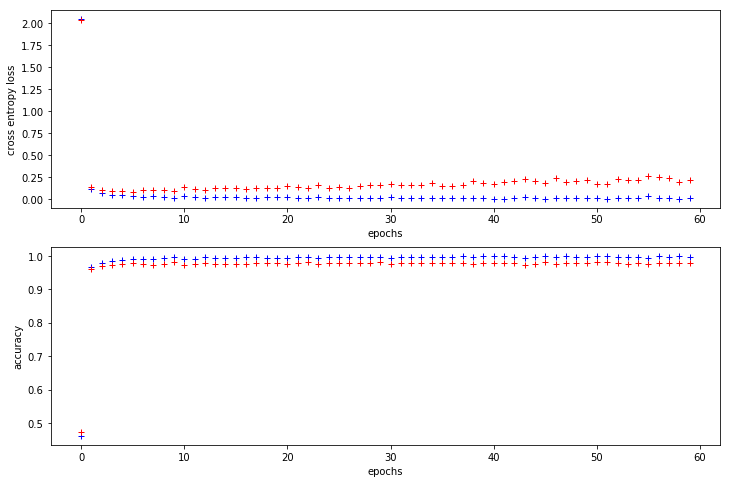

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


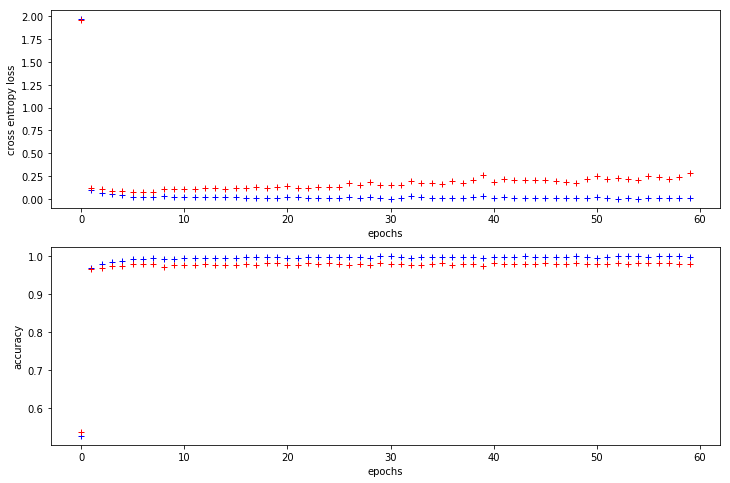

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


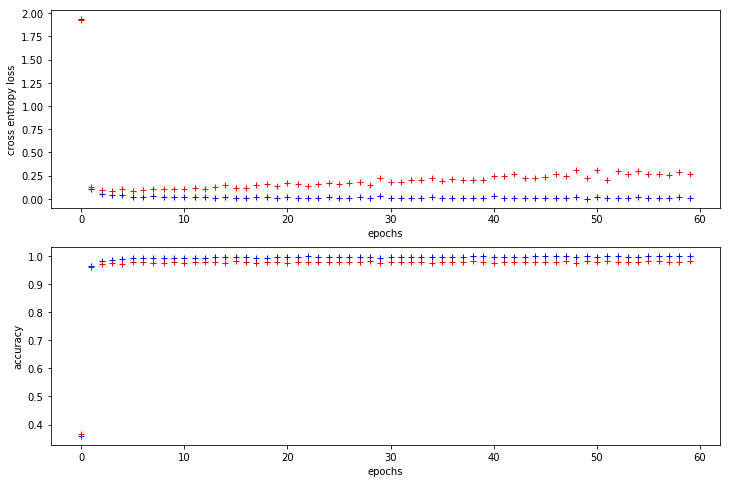

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


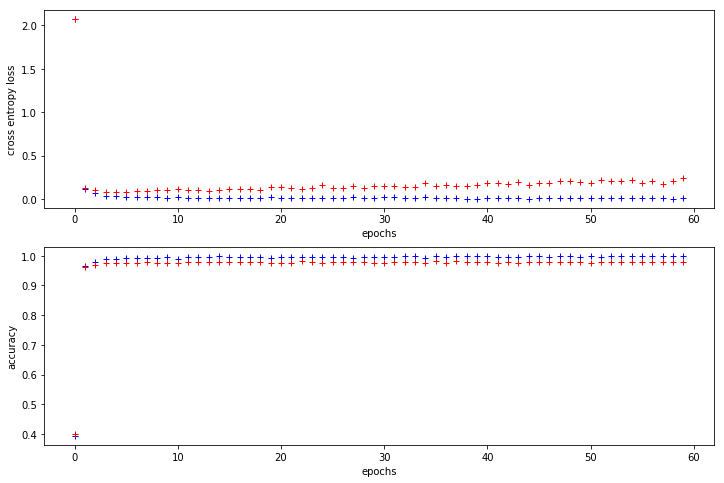

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


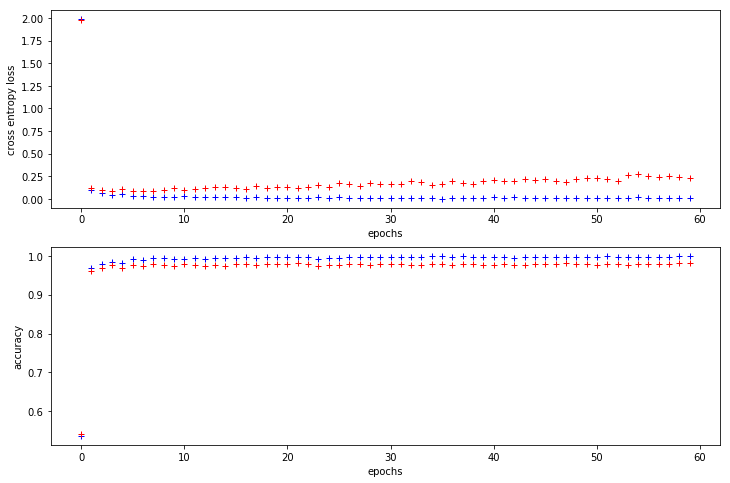

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


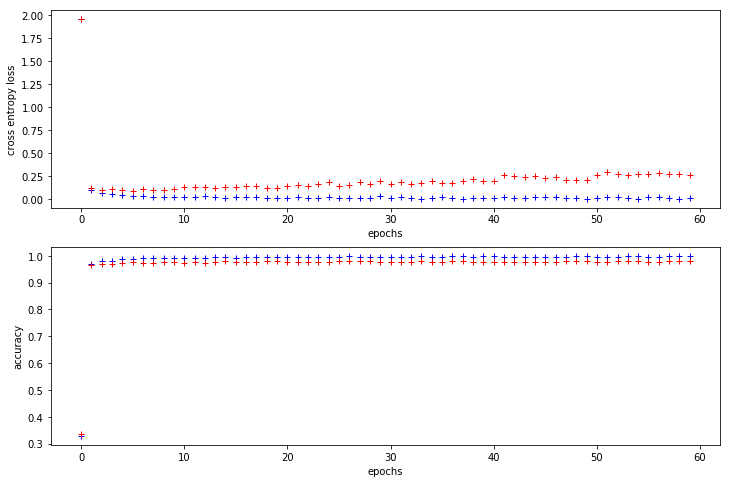

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


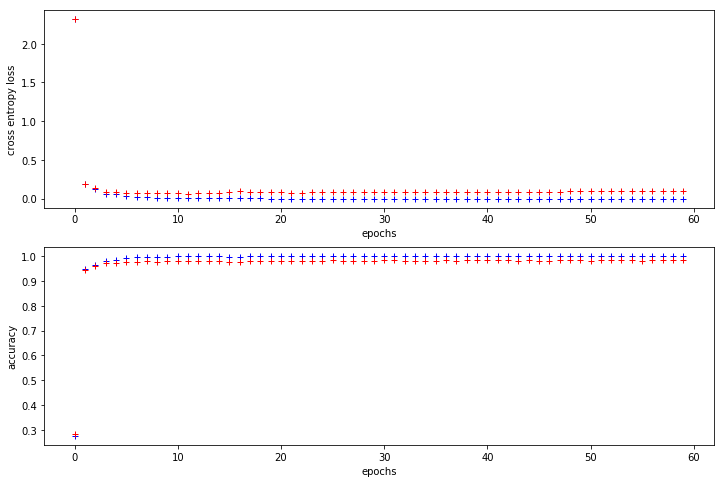

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


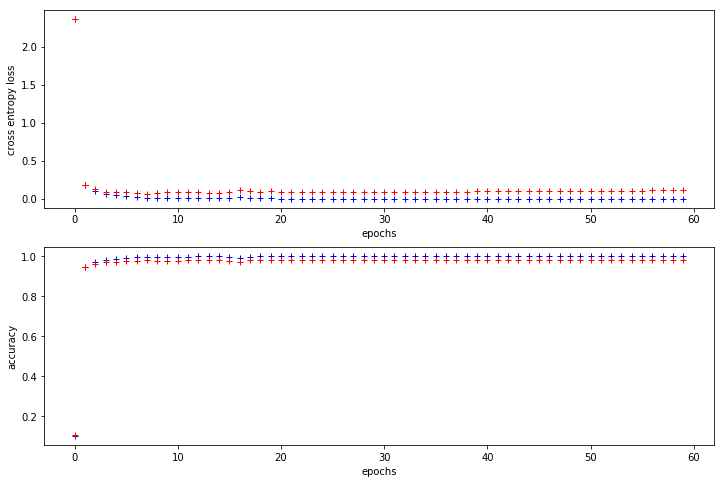

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function relu_initializer at 0x7f9cafc0f0d0>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


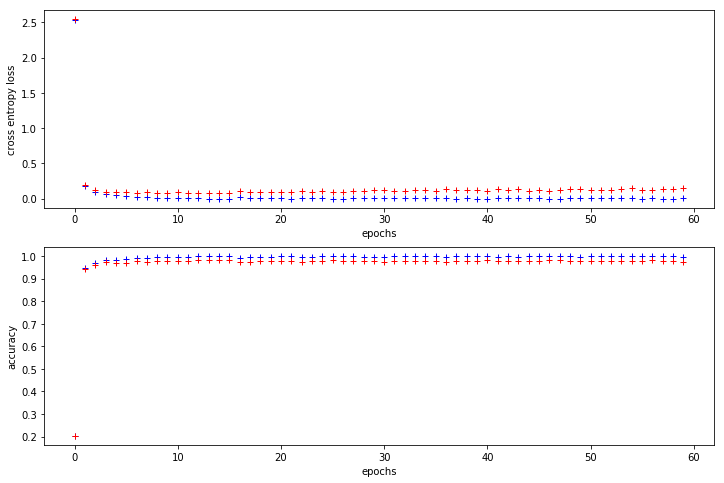

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 64}


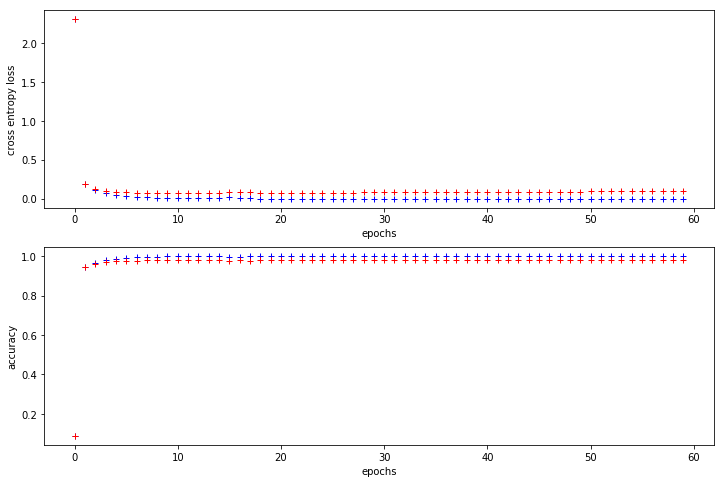

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 128}


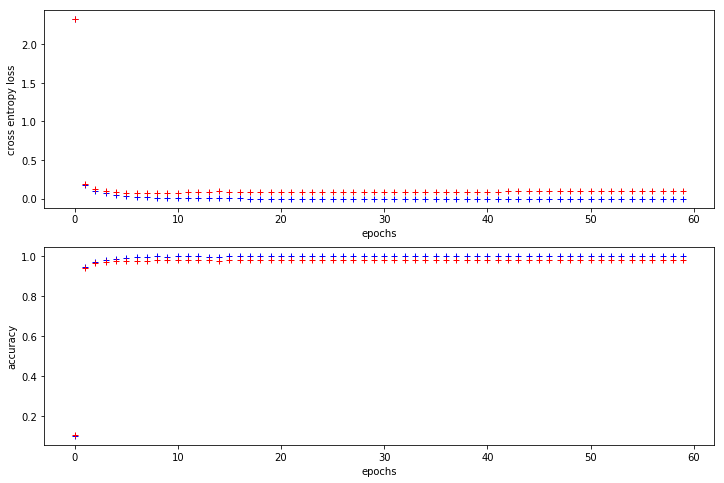

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.005], 'hidden_activation_fn': <function sigmoid at 0x7f9df035ea60>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256}


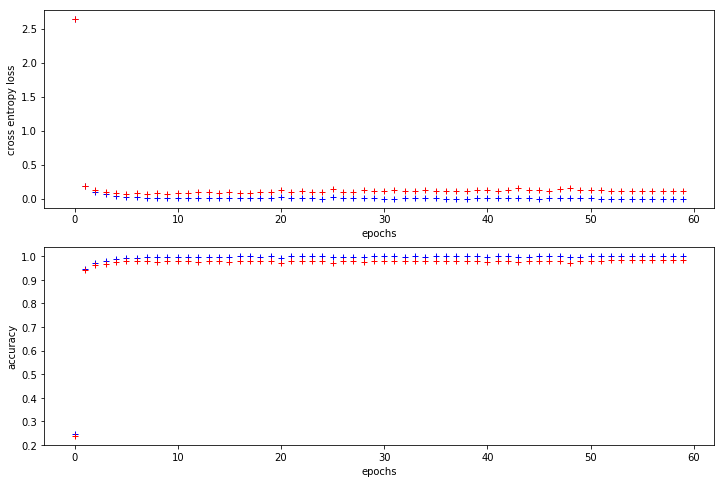

In [519]:
"""
2 Layer Hidden Network
Architecture: X -> Hidden Layer -> Relu/Sigmoid -> Hidden Layer -> Relu/Sigmoid-> Output Layer -> Argmax -> Y
Grid search over learning rate, optimizers, size of 2nd hidden layer, hidden layer activation fn
Goal: find optimal hyper parameters for 2 layer hidden network
"""

parameter_combinations = []
optimizer_fns = [
    [tf.train.GradientDescentOptimizer, 0.5], 
    [tf.train.GradientDescentOptimizer, 0.1], 
    [tf.train.AdamOptimizer, 0.001],
    [tf.train.AdamOptimizer, 0.005]
]

for optimizer_fn in optimizer_fns:
    for hidden_activation_fn in [tf.nn.relu, tf.nn.sigmoid]:
        for hidden_initialization_fn in [relu_initializer, xavier_initializer]:
            for n_hidden_layer_1 in [256]:
                for n_hidden_layer_2 in [64, 128, 256]:
                    parameters = {
                        'optimizer_fn': optimizer_fn,
                        'hidden_activation_fn': hidden_activation_fn,
                        'hidden_initialization_fn': hidden_initialization_fn,
                        'n_hidden_layer_1': n_hidden_layer_1,
                        'n_hidden_layer_2': n_hidden_layer_2
                    }
                    parameter_combinations.append(parameters)
                
results = []
for parameters in parameter_combinations:
    print('parameters: ', parameters)
    tf.reset_default_graph()
    tf.set_random_seed(0)
    X = tf.placeholder(tf.float32, shape=[None, n_X])                    
    hidden_layer_1 = nn_layer(X, n_X, parameters['n_hidden_layer_1'], weight_initializer=parameters['hidden_initialization_fn'], bias_initializer=tf.zeros, activation=parameters['hidden_activation_fn'])['output']
    hidden_layer_2 = nn_layer(hidden_layer_1, parameters['n_hidden_layer_1'], parameters['n_hidden_layer_2'], weight_initializer=parameters['hidden_initialization_fn'], bias_initializer=tf.zeros, activation=parameters['hidden_activation_fn'])['output']
    output_layer = nn_layer(hidden_layer_2, parameters['n_hidden_layer_2'], n_Y, weight_initializer=parameters['hidden_initialization_fn'], bias_initializer=tf.zeros, activation=pass_through_activation)['output']
    optimizer = parameters['optimizer_fn'][0](learning_rate=parameters['optimizer_fn'][1])
    summaries = train(output_layer, optimizer, batch_size=256, epochs=60, print_progress=False)['summaries']
    plot_summaries(summaries)
    results.append([parameters, summaries])
                                                                                                                             

In [522]:
# compare of last 10 epochs
for epoch in range(50,60,1):
    print('epoch: ', epoch)
    best_results = sorted(results, key=lambda result: result[1][epoch]['test_accuracy'], reverse=True)  
    print("best results")
    for result in best_results:
        template = "test acc: {test_accuracy:5.4f} loss_diff: {loss_diff:4.3f} opt: {optimizer_fn:<25s} learn: {learning_rate:3.3f} size: 256x{n_hidden_layer_2:3d} act: {activation_fn:<9s} init: {initialization_fn:<20s}"
        print(template.format(test_accuracy=result[1][epoch]['test_accuracy'], 
                              optimizer_fn=result[0]['optimizer_fn'][0].__name__, 
                              learning_rate=result[0]['optimizer_fn'][1], 
                              n_hidden_layer_2=result[0]['n_hidden_layer_2'], 
                              activation_fn=result[0]['hidden_activation_fn'].__name__, 
                              initialization_fn=result[0]['hidden_initialization_fn'].__name__, 
                              loss_diff=result[1][epoch]['test_loss'] - result[1][epoch]['train_loss']))



epoch:  50
best results
test acc: 0.9837 loss_diff: 0.108 opt: AdamOptimizer             learn: 0.001 size: 256x256 act: relu      init: xavier_initializer  
test acc: 0.9831 loss_diff: 0.076 opt: GradientDescentOptimizer  learn: 0.500 size: 256x 64 act: relu      init: xavier_initializer  
test acc: 0.9829 loss_diff: 0.102 opt: AdamOptimizer             learn: 0.001 size: 256x128 act: relu      init: xavier_initializer  
test acc: 0.9828 loss_diff: 0.104 opt: AdamOptimizer             learn: 0.001 size: 256x128 act: relu      init: relu_initializer    
test acc: 0.9828 loss_diff: 0.109 opt: AdamOptimizer             learn: 0.001 size: 256x256 act: relu      init: relu_initializer    
test acc: 0.9827 loss_diff: 0.079 opt: GradientDescentOptimizer  learn: 0.500 size: 256x128 act: relu      init: xavier_initializer  
test acc: 0.9825 loss_diff: 0.076 opt: GradientDescentOptimizer  learn: 0.500 size: 256x256 act: relu      init: xavier_initializer  
test acc: 0.9824 loss_diff: 0.098 opt:

# observations
- 256x64 vs 256vs256 both performed very well, with 256x64 having less loss difference between training and testing indicating better generalization
- top performing models trended towards to be relu hidden activation, while bottom performing models trended toward sigmoid hidden activation
- top model was AdamOptimizer with 0.001 with 256x256 with relu activation and xavier initializer at 98.38% accuracy on test, though it like looked it had some minor overfitting on training
- future exploration should include regularization with maybe dropout or l2


parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.0008], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256, 'dropout_keep_prob': 0.4}


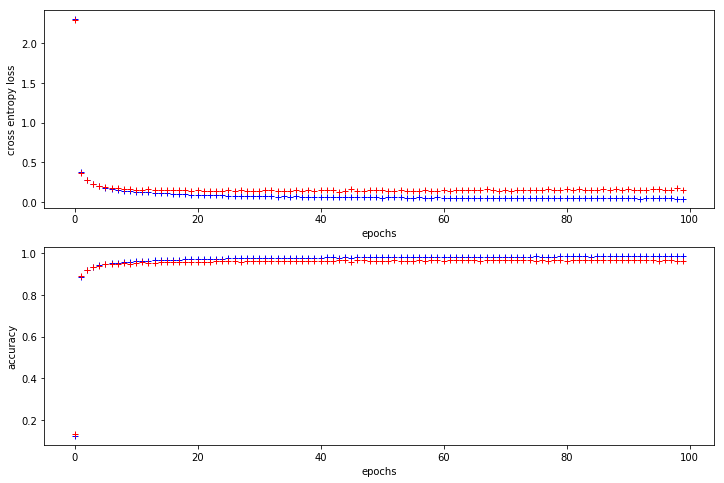

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.0008], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256, 'dropout_keep_prob': 0.6}


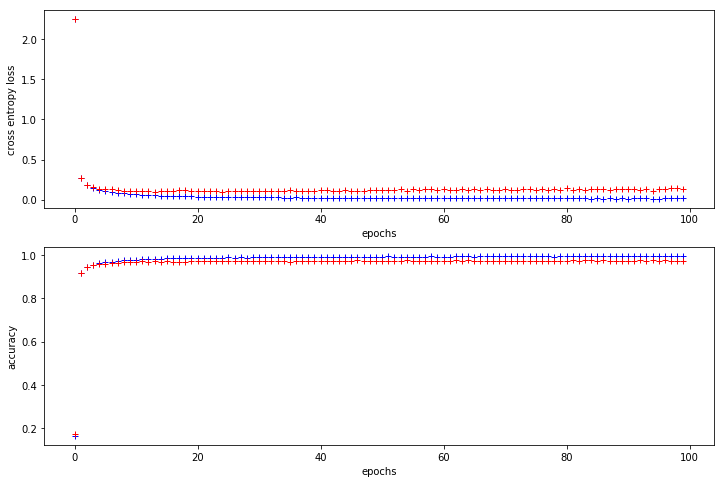

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.0008], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256, 'dropout_keep_prob': 0.8}


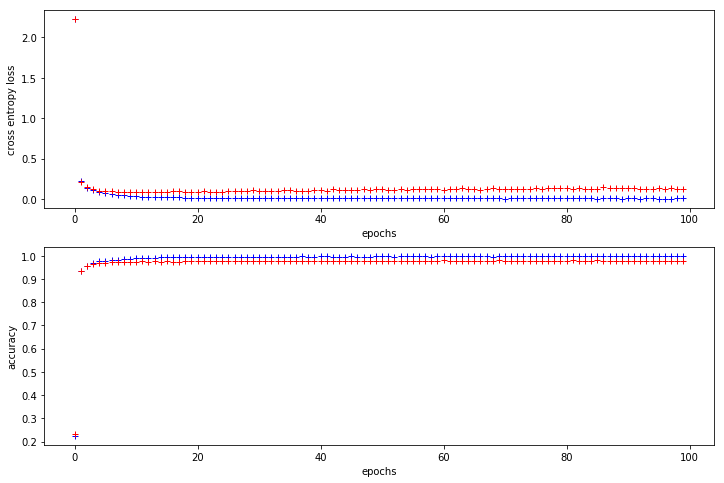

parameters:  {'optimizer_fn': [<class 'tensorflow.python.training.adam.AdamOptimizer'>, 0.0008], 'hidden_activation_fn': <function relu at 0x7f9df0441d08>, 'hidden_initialization_fn': <function xavier_initializer at 0x7f9cafc0f620>, 'n_hidden_layer_1': 256, 'n_hidden_layer_2': 256, 'dropout_keep_prob': 1.0}


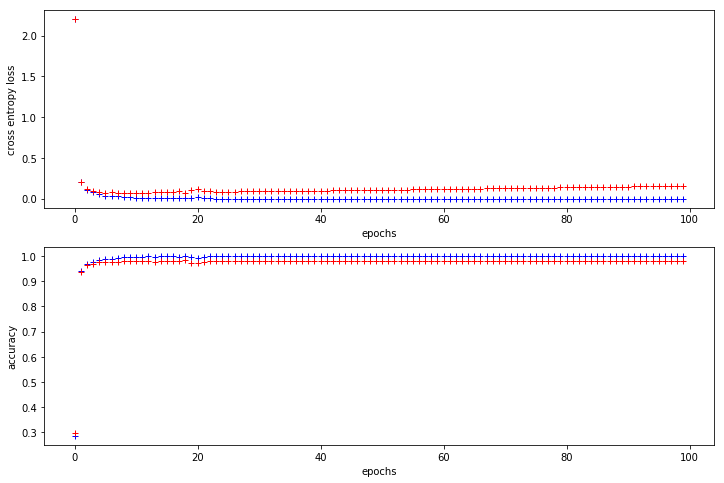

In [539]:
"""
2 Layer Hidden Network With Dropout Regularization
Architecture: X -> Hidden Layer -> Relu -> Dropout -> Hidden Layer -> Relu -> Dropout -> Output Layer -> Argmax -> Y
Adam Optimizer with 0.001 learning rate
Grid search Dropout percentage
Goal: find optimal hyper parameters for 2 layer hidden network
"""

parameter_combinations = []
for dropout_keep_prob in [0.4, 0.6, 0.8, 1.0]:
    parameters = {
        'optimizer_fn': [tf.train.AdamOptimizer,0.0008],
        'hidden_activation_fn': tf.nn.relu,
        'hidden_initialization_fn': xavier_initializer,
        'n_hidden_layer_1': 256,
        'n_hidden_layer_2': 256,
        'dropout_keep_prob': dropout_keep_prob
    }
    parameter_combinations.append(parameters)
                
results = []
for parameters in parameter_combinations:
    print('parameters: ', parameters)
    tf.reset_default_graph()
    tf.set_random_seed(0)
    X = tf.placeholder(tf.float32, shape=[None, n_X])                    
    hidden_layer_1 = nn_layer(X, n_X, parameters['n_hidden_layer_1'], weight_initializer=parameters['hidden_initialization_fn'], bias_initializer=tf.zeros, activation=parameters['hidden_activation_fn'])['output']
    dropout_1 = tf.nn.dropout(hidden_layer_1, parameters['dropout_keep_prob'])
    hidden_layer_2 = nn_layer(dropout_1, parameters['n_hidden_layer_1'], parameters['n_hidden_layer_2'], weight_initializer=parameters['hidden_initialization_fn'], bias_initializer=tf.zeros, activation=parameters['hidden_activation_fn'])['output']
    dropout_2 = tf.nn.dropout(hidden_layer_2, parameters['dropout_keep_prob'])
    output_layer = nn_layer(dropout_2, parameters['n_hidden_layer_2'], n_Y, weight_initializer=parameters['hidden_initialization_fn'], bias_initializer=tf.zeros, activation=pass_through_activation)['output']
    optimizer = parameters['optimizer_fn'][0](learning_rate=parameters['optimizer_fn'][1])
    summaries = train(output_layer, optimizer, batch_size=256, epochs=100, print_progress=False)['summaries']
    plot_summaries(summaries)
    results.append([parameters, summaries])
                                                                                                                             

In [540]:
# compare of last 50 epochs, every 10 epochs
for epoch in range(50,100,10):
    print('epoch: ', epoch)
    best_results = sorted(results, key=lambda result: result[1][epoch]['test_accuracy'], reverse=True)  
    print("best results")
    for result in best_results:
        template = "test acc: {test_accuracy:5.4f} loss_diff: {loss_diff:4.3f} opt: {optimizer_fn:<10s} learn: {learning_rate:3.3f} size: 256x256 act: {activation_fn:<5s} init: {initialization_fn:<20s} dropout_keep_%: {dropout_keep_prob:2.1f}"
        print(template.format(test_accuracy=result[1][epoch]['test_accuracy'], 
                              optimizer_fn=result[0]['optimizer_fn'][0].__name__, 
                              learning_rate=result[0]['optimizer_fn'][1], 
                              n_hidden_layer_2=result[0]['n_hidden_layer_2'], 
                              activation_fn=result[0]['hidden_activation_fn'].__name__, 
                              initialization_fn=result[0]['hidden_initialization_fn'].__name__, 
                              loss_diff=result[1][epoch]['test_loss'] - result[1][epoch]['train_loss'],
                              dropout_keep_prob= result[0]['dropout_keep_prob']))




epoch:  50
best results
test acc: 0.9818 loss_diff: 0.107 opt: AdamOptimizer learn: 0.001 size: 256x256 act: relu  init: xavier_initializer   dropout_keep_%: 1.0
test acc: 0.9763 loss_diff: 0.111 opt: AdamOptimizer learn: 0.001 size: 256x256 act: relu  init: xavier_initializer   dropout_keep_%: 0.8
test acc: 0.9735 loss_diff: 0.099 opt: AdamOptimizer learn: 0.001 size: 256x256 act: relu  init: xavier_initializer   dropout_keep_%: 0.6
test acc: 0.9628 loss_diff: 0.091 opt: AdamOptimizer learn: 0.001 size: 256x256 act: relu  init: xavier_initializer   dropout_keep_%: 0.4
epoch:  60
best results
test acc: 0.9819 loss_diff: 0.108 opt: AdamOptimizer learn: 0.001 size: 256x256 act: relu  init: xavier_initializer   dropout_keep_%: 0.8
test acc: 0.9816 loss_diff: 0.117 opt: AdamOptimizer learn: 0.001 size: 256x256 act: relu  init: xavier_initializer   dropout_keep_%: 1.0
test acc: 0.9744 loss_diff: 0.111 opt: AdamOptimizer learn: 0.001 size: 256x256 act: relu  init: xavier_initializer   dropou